# Setup Paths

```
module purge
rm -rf ~/sde_env
python -m venv ~/sde_env
source ~/sde_env/bin/activate

which python
python -m ensurepip --upgrade
python -m pip install --upgrade pip setuptools packaging
python -m pip install --no-index --no-user --prefix="$VIRTUAL_ENV" \
    dill KDEpy scikit-learn numpy scipy matplotlib pandas sympy sklearn
source ~/sde_env/bin/activate
python -m ipykernel install --user --name sde_env --display-name "Python (SDE Stack)"

python - <<'EOF'
import sys, numpy, scipy, matplotlib, sklearn, dill
print("python:", sys.executable)
print("numpy:", numpy.__file__, numpy.__version__)
print("scipy:", scipy.__file__)
print("matplotlib:", matplotlib.__file__)
print("sklearn:", sklearn.__file__)
print("dill:", dill.__file__)
EOF
```

Change kernel to something else and change it back

In [1]:
import sys
import os

target_folder_name = "SymbolicDensityEstimation"
# 1. Get the current directory of the notebook.
current_dir = os.getcwd()

# # 2. Join it with '..' to get the parent directory.
parent_dir = os.path.join(current_dir, '..')

# # 3. change directory
current_folder_name = os.path.basename(current_dir)
is_match = current_folder_name == target_folder_name
if not is_match:
    os.chdir(parent_dir)

# # Get the current working directory as a string
current_directory = os.getcwd()

print("The current working directory is:")
print(current_directory)

The current working directory is:
/project/6001884/aa3rajen/SymbolicDensityEstimation


# Imports

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
from sklearn.neighbors import KernelDensity
import scipy
from scipy.stats import gaussian_kde
import pandas as pd
from config_management.data_config_4d_gaussian import DataConfig
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from matplotlib import cm  # For colormap
from KDEpy import FFTKDE
from scipy.stats import multivariate_normal
from scipy.interpolate import RegularGridInterpolator
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
import gc
import dill
from pgmpy.estimators import PC
import networkx as nx

/home/aa3rajen/sde_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Exploration

In [4]:
file_path = './data/gaussian_4d_samples.csv'
df = pd.read_csv(file_path)
print(df.head())
columns = ['x1', 'x2', 'x3', 'x4']
samples = df[columns].to_numpy()
# Extract m13^2 and m23^2 columns
x1 = df["x1"]
x2 = df["x2"]
x3 = df["x3"]
x4 = df["x4"]

         x1        x2        x3        x4
0  2.016969 -5.364023 -5.088255  4.329010
1  1.927835 -5.471277 -3.025009  4.879264
2  4.052371 -3.856527 -4.849410  4.070354
3  3.137654 -4.581622 -4.220948  3.990086
4  2.483591 -5.318407 -3.535281  3.924541


Working for n conditional variables: 2:  40%|████      | 2/5 [00:00<00:00, 74.43it/s]


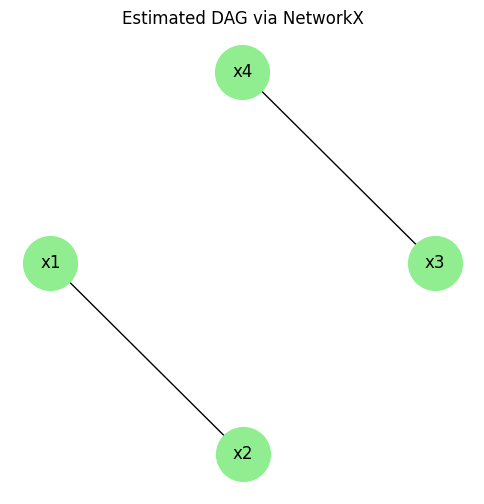

In [5]:
from pgmpy.estimators import PC
df = pd.DataFrame(samples[:250000,:], columns=['x1', 'x2', 'x3', 'x4'])
est = PC(data=df)
estimated_model = est.estimate(ci_test='pearsonr', significance_level=1/250000)

# Get a graphviz object.
# model_graph = estimated_model.to_graphviz()
# # To open the plot
# model_graph.draw("./data/pgm.png", format='png', prog='dot')

G_dag = estimated_model  # Might raise if edges can't be fully oriented

plt.figure(figsize=(6,6))
pos = nx.circular_layout(G_dag)

nx.draw_networkx_nodes(G_dag, pos, node_color='lightgreen', node_size=1500)
nx.draw_networkx_labels(G_dag, pos, font_size=12)
nx.draw_networkx_edges(G_dag, pos, arrowstyle='->', arrowsize=20, edge_color='black')

plt.title("Estimated DAG via NetworkX")
plt.axis('off')
plt.show()

## Scatter Plot

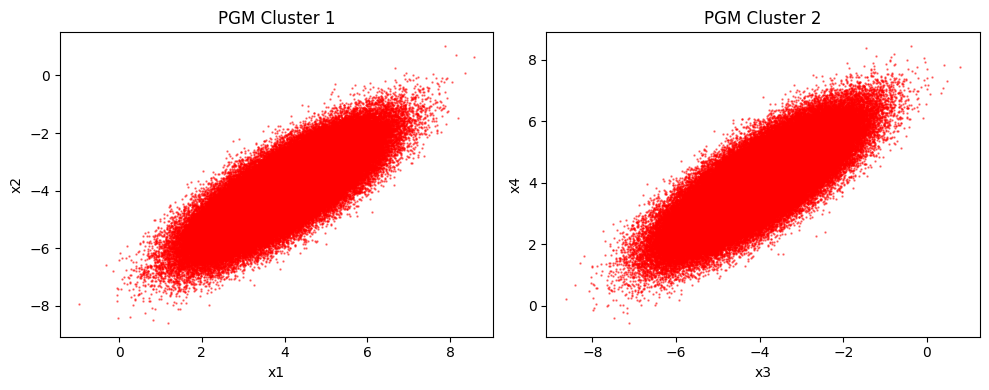

3127

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Left subplot
axes[0].scatter(x1, x2, s=0.5, alpha=0.5, color='red', label='Data Points')
axes[0].set_title('PGM Cluster 1')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

# Right subplot (example: same data or different)
axes[1].scatter(x3, x4, s=0.5, alpha=0.5, color='red', label='Data Points')
axes[1].set_title('PGM Cluster 2')
axes[1].set_xlabel('x3')
axes[1].set_ylabel('x4')

plt.tight_layout()
plt.show()
plt.show()
plt.close() 
gc.collect()

In [7]:
if DataConfig.slices is None:
    wmin, wmax = x1.min()-DataConfig.grid_tolerance, x1.max()+DataConfig.grid_tolerance
    xmin, xmax = x2.min()-DataConfig.grid_tolerance, x2.max()+DataConfig.grid_tolerance   
    ymin, ymax = x3.min()-DataConfig.grid_tolerance, x3.max()+DataConfig.grid_tolerance 
    zmin, zmax = x4.min()-DataConfig.grid_tolerance, x4.max()+DataConfig.grid_tolerance 
    grids = np.mgrid[wmin:wmax:DataConfig.jxbins, xmin:xmax:DataConfig.jxbins, ymin:ymax:DataConfig.jxbins, zmin:zmax:DataConfig.jxbins]
else:
    slices = [slice(-13.0, 13.0, DataConfig.jxbins), slice(-13.0, 13.0, DataConfig.jxbins), slice(-13.0, 13.0, DataConfig.jxbins), slice(-13.0, 13.0, DataConfig.jxbins)]
    grids = np.mgrid[tuple(slices)]

grid_coordinates = np.vstack([grids[0].ravel(), grids[1].ravel(), grids[2].ravel(), grids[3].ravel()])
grid_coordinates = grid_coordinates.T

In [8]:
with open(f"models/gaussian_4d_kde_wrapped.pkl", "rb") as f:
    wrapper_model = dill.load(f)

In [9]:
kde_predicted_density = wrapper_model.evaluate(grid_coordinates).reshape(grids[0].shape)

In [10]:
axes = [
    grids[0][:,0,0,0],  # x1
    grids[1][0,:,0,0],  # x2
    grids[2][0,0,:,0],  # x3
    grids[3][0,0,0,:]   # x4
]

total_mass = np.trapezoid(
    np.trapezoid(
      np.trapezoid(
        np.trapezoid(kde_predicted_density, x=axes[3], axis=3),
      x=axes[2], axis=2),
    x=axes[1], axis=1),
  x=axes[0], axis=0)

print("total mass of joint:", total_mass)

total mass of joint: 2.4006975434472646


# KDE Heatmap

In [11]:
def conditional_and_marginal_generation(
    joint_density,
    grids,
    conditioning_xa_target,
    conditioning_xb_target,
    ab_idx,
    fill_value=0.0,
    trapz_tol=1e-12,
    log_plot=False,
    plot=True,
    contour_levels=60,
    total_mass = total_mass
):
    """
    Return an interpolated conditional slice p(xc,xd | xa=conditioning_xa_target, xb=conditioning_xb_target).

    Parameters
    ----------
    joint_density : ndarray
        4-D array with shape (N,N,N,N) representing the joint density p(x1,x2,x3,x4).
    grids : ndarray-like
        The output of np.mgrid for the 4 axes, shape (4, N, N, N, N).
        Each grids[i] contains the coordinate values for axis i.
    conditioning_xa_target, conditioning_xb_target : float
        The values of xa and xb to condition on.
    ab_idx: tuple
        Either (1,2) or (3,4)
    fill_value : float
        Value to use outside the grid in the interpolator (default 0.0).
    trapz_tol : float
        If marginal <= trapz_tol, raise an error (slice likely in tail / numerical underflow).
    log_plot : bool
        If True, plot log10(cond + eps) instead of cond.
    plot : bool
        If True, show a contourf plot of the conditional.
    contour_levels : int
        Number of contour levels for plotting.
    total_mass: float
        total mass of joint_density used for normalizing the marginal

    Returns
    -------
    X1, X2 : 2D arrays
        Meshgrid arrays for xc and xd (shape (N,N)).
    joint_density_on_slice : 2D array
        Interpolated joint p(xc,xd,xa=conditioning_xa_target,xb=conditioning_xb_target).
    conditional_density : 2D array
        Normalized conditional p(xc, xd | xa, xb).
    marginal_for_slice: float
        The marginal p(xa=conditioning_xa_target, xb=conditioning_xb_target) (approx).
    marginal_density: 2D array
        Marginal density p(xc, xd)
    """
    # Basic shape checks
    if joint_density.ndim != 4:
        raise ValueError("joint_density must be 4-D.")
    if len(grids) != 4:
        raise ValueError("grids must have length 4 (from np.mgrid).")
    assert (ab_idx == (1,2)) or (ab_idx == (3,4)), "Unsupported indices for conditioning"

    # --- extract separate 1-D axis arrays (preserve order and spacing) ---
    x1 = grids[0][:,0,0,0]
    x2 = grids[1][0,:,0,0]
    x3 = grids[2][0,0,:,0]
    x4 = grids[3][0,0,0,:]

    if not (np.allclose(x1, x2) and np.allclose(x2, x3) and np.allclose(x3, x4)):
        raise ValueError('Bad grids provided')

    if 3 in ab_idx and 4 in ab_idx:
        a_idx = 3
        b_idx = 4
        c_idx = 1
        d_idx = 2
    elif 1 in ab_idx and 2 in ab_idx:
        a_idx = 1
        b_idx = 2
        c_idx = 3
        d_idx = 4
    else:
        raise ValueError("bad ab_idx")

    

    # choose axis vectors in canonical order for interpolator
    axes = (x1, x2, x3, x4)
    for n, xi in enumerate(axes):
        if len(xi) != joint_density.shape[n]:
            raise ValueError(f"axis {n+1} length mismatch: {len(xi)} != {joint_density.shape[n]}")
    
    # quick monotonicity checks (clear error if not strictly increasing)
    for xi, name in ((x1,'x1'),(x2,'x2'),(x3,'x3'),(x4,'x4')):
        if not np.all(np.diff(xi) > 0):
            raise ValueError(f"Axis {name} is not strictly increasing.")

    # Build the interpolator with explicit axes
    # target-in-range sanity check (clear error if conditioning outside grid)
    xa_range = axes[a_idx-1][[0,-1]]
    xb_range = axes[b_idx-1][[0,-1]]
    if not (xa_range[0] <= conditioning_xa_target <= xa_range[1]):
        raise ValueError("conditioning_xa_target outside axis range")
    if not (xb_range[0] <= conditioning_xb_target <= xb_range[1]):
        raise ValueError("conditioning_xb_target outside axis range")
        
    interp = RegularGridInterpolator(axes, joint_density, bounds_error=False, fill_value=fill_value)

    # Determine which axes are c,d and which are a,b
    if (a_idx, b_idx) == (3,4):   # you already set a_idx,b_idx earlier
        x_c = x1; x_d = x2
    else:
        x_c = x3; x_d = x4

    # Build mesh for c,d using their true axes
    Xc, Xd = np.meshgrid(x_c, x_d, indexing='ij')

    if 3 in ab_idx and 4 in ab_idx:
    # Prepare query points for (conditioning_xa_target, conditioning_xb_target)
        pts = np.column_stack([
            Xc.ravel(),
            Xd.ravel(),
            np.full(Xc.size, conditioning_xa_target),
            np.full(Xc.size, conditioning_xb_target)
        ])  # shape (N*N, 4)
    elif 1 in ab_idx and 2 in ab_idx:
    # Prepare query points for (xc_target, xd_target)
        pts = np.column_stack([
            np.full(Xc.size, conditioning_xa_target),
            np.full(Xc.size, conditioning_xb_target),
            Xc.ravel(),
            Xd.ravel(),
        ])  # shape (N*N, 4)  
    else:
        raise ValueError("Bad conditonal indices")

    # Evaluate interpolated joint density on the plane
    density_flat = interp(pts)              # (N*N,)
    joint_density_on_slice = density_flat.reshape(Xc.shape)  # (N,N)

    # Compute marginal p(xa,xb) by integrating joint_density_on_slice over xc,xd
    # integrate over c,d using the correct x arrays (x_d then x_c)
    marginal_for_slice = np.trapezoid(
        np.trapezoid(joint_density_on_slice, x=x_d, axis=1),
        x=x_c, axis=0
    )

    if not np.isfinite(marginal_for_slice) or marginal_for_slice <= trapz_tol:
        print(
            f"Marginal at (x{ab_idx[0]}={conditioning_xa_target}, x{ab_idx[1]}={conditioning_xb_target}) is zero, too small, or non-finite: {marginal_for_slice}. "
            "This usually means the slice is in the extreme tail (densities ~ 0) or numeric underflow."
        )

    conditional_density = joint_density_on_slice / marginal_for_slice

    axis_a = a_idx - 1
    axis_b = b_idx - 1

    first = max(axis_a, axis_b)
    second = min(axis_a, axis_b)

    tmp = np.trapezoid(joint_density, axes[first], axis=first)
    marginal_density = np.trapezoid(tmp, axes[second], axis=second)
    marginal_density = marginal_density/total_mass

    # Plot if requested
    if plot:
        plt.figure(figsize=(8,6))
        if log_plot:
            eps = 1e-20
            data_to_plot = np.log10(conditional_density + eps)
            label = f'log10 p(x{c_idx},x{d_idx} | x{a_idx}, x{b_idx})'
        else:
            data_to_plot = conditional_density
            label = f'p(x{c_idx},x{d_idx} | x{a_idx}, x{b_idx})'

        cf = plt.contourf(Xc, Xd, data_to_plot, levels=contour_levels)
        cbar = plt.colorbar(cf)
        cbar.set_label(label)
        plt.xlabel(f'x{c_idx}')
        plt.ylabel(f'x{d_idx}')
        plt.title(f'Conditional p(x{c_idx},x{d_idx} | x{a_idx}={conditioning_xa_target}, x{b_idx}={conditioning_xb_target})')
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(8,6))
        cf = plt.contourf(Xc, Xd, marginal_density, levels=contour_levels, cmap='viridis')
        plt.title(f'Marginal p(x{c_idx}, x{d_idx})')
        label = f'p(x{c_idx},x{d_idx})'
        cbar = plt.colorbar(cf)
        cbar.set_label(label)
        plt.xlabel(f'x{c_idx}')
        plt.ylabel(f'x{d_idx}')
        plt.tight_layout()
        plt.show()

    return Xc, Xd, joint_density_on_slice, conditional_density, marginal_for_slice, marginal_density

### Debug conditional and marginal generation

In [12]:
c_idx = 1 
d_idx = 2 
a_idx = 3 
b_idx = 4

# build 1D axes exactly as in your function 
axes = [ 
    grids[0][:,0,0,0], # x1 
    grids[1][0,:,0,0], # x2 
    grids[2][0,0,:,0], # x3 
    grids[3][0,0,0,:] # x4 
]

X1, X2, kde12_joint_density_on_slice, kde12_conditional_density, kde12_marginal_for_slice, kde12_marginal_density = conditional_and_marginal_generation( 
    joint_density=kde_predicted_density, 
    grids=grids, 
    conditioning_xa_target=-4.0, 
    conditioning_xb_target=4.0, 
    ab_idx = (a_idx, b_idx), 
    plot=False, 
    log_plot=False, # use log scale for tail densities trapz_tol=1e-20, # lower tolerance to accept tiny marginals 
)

# which indices did your function set for c,d? (1-based) 
print("c_idx, d_idx:", c_idx, d_idx) # pick the exact 1D arrays for integration over the conditional output 
x_c = axes[c_idx-1] 
x_d = axes[d_idx-1]

# integral of conditional (should be ~1) 
I_cond = np.trapezoid(np.trapezoid(kde12_conditional_density, x=x_d, axis=1), x=x_c, axis=0) 
print("∫ cond =", I_cond)

# integral of marginal_density using the same (c,d) axes (should be ~1 for normalized joint) 
I_marg = np.trapezoid(np.trapezoid(kde12_marginal_density, x=x_d, axis=1), x=x_c, axis=0) 
print("∫ marginal (p(x_c,x_d)) =", I_marg)

# recompute marginal directly from full joint and compare 
def compute_marginal_cd_from_joint(kde_predicted_density, axes, a_idx, b_idx): 
    axis_a = a_idx - 1 
    axis_b = b_idx - 1 
    first = max(axis_a, axis_b) 
    second = min(axis_a, axis_b) 
    tmp = np.trapezoid(kde_predicted_density, x=axes[first], axis=first) 
    marg_cd = np.trapezoid(tmp, x=axes[second], axis=second) / total_mass
    return marg_cd

marg_from_joint = compute_marginal_cd_from_joint(kde_predicted_density, axes, a_idx, b_idx) 
print("max abs diff between marginal_density and recomputed:", np.max(np.abs(kde12_marginal_density - marg_from_joint)))

c_idx, d_idx: 1 2
∫ cond = 0.9999999999999996
∫ marginal (p(x_c,x_d)) = 1.0000000000000002
max abs diff between marginal_density and recomputed: 0.0


## KDE Marginals and Conditional Plots

In [13]:
X1, X2, kde12_joint_density_on_slice, kde12_conditional_density, kde12_marginal_for_slice, kde12_marginal_density = conditional_and_marginal_generation(
    joint_density=kde_predicted_density,
    grids=grids,
    conditioning_xa_target=-4.0,
    conditioning_xb_target=4.0,
    ab_idx = (3,4),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
)

X3, X4, kde34_joint_density_on_slice, kde34_conditional_density, kde34_marginal_for_slice, kde34_marginal_density = conditional_and_marginal_generation(
    joint_density=kde_predicted_density,
    grids=grids,
    conditioning_xa_target=4.0,
    conditioning_xb_target=-4.0,
    ab_idx = (1,2),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
)

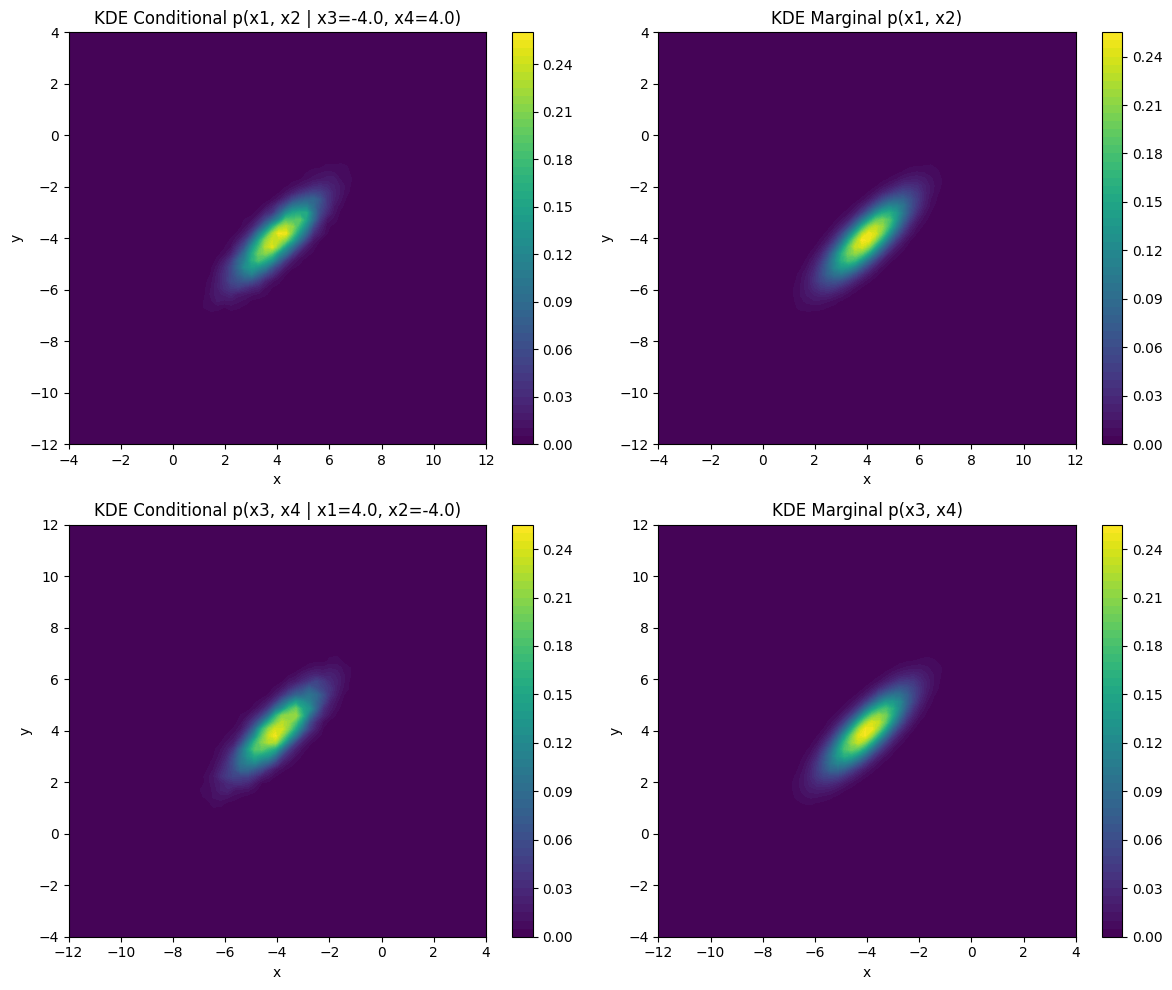

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

cf00 = axs[0, 0].contourf(X1, X2, kde12_conditional_density, levels=60)
fig.colorbar(cf00, ax=axs[0, 0])
axs[0, 0].set_title("KDE Conditional p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0, 0].set_xlim([-4, 12])
axs[0, 0].set_ylim([-12, 4])

cf01 = axs[0, 1].contourf(X1, X2, kde12_marginal_density, levels=60)
fig.colorbar(cf01, ax=axs[0, 1])
axs[0, 1].set_title("KDE Marginal p(x1, x2)")
axs[0, 1].set_xlim([-4, 12])
axs[0, 1].set_ylim([-12, 4])

cf10 = axs[1, 0].contourf(X3, X4, kde34_conditional_density, levels=60)
fig.colorbar(cf10, ax=axs[1, 0])
axs[1, 0].set_title("KDE Conditional p(x3, x4 | x1=4.0, x2=-4.0)")
axs[1, 0].set_xlim([-12, 4])
axs[1, 0].set_ylim([-4, 12])

cf11 = axs[1, 1].contourf(X3, X4, kde34_marginal_density, levels=60)
fig.colorbar(cf11, ax=axs[1, 1])
axs[1, 1].set_title("KDE Marginal p(x3, x4)")
axs[1, 1].set_xlim([-12, 4])
axs[1, 1].set_ylim([-4, 12])

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

## Ground Truth Defintion

In [15]:
pow2 = lambda x: x ** 2
pow3 = lambda x: x ** 3
pow4 = lambda x: x ** 4
pow5 = lambda x: x ** 5

def ground_truth_cluster_2(x1, x2):
    # Mean and covariance
    mu = [-4, 4]
    sigma = [[1, 0.8], [0.8, 1]]
    
    # Stack grid into a (..., 2) shape expected by multivariate_normal
    pos = np.stack([x1, x2], axis=-1)
    
    # Evaluate the PDF
    rv = multivariate_normal(mean=mu, cov=sigma)
    return rv.pdf(pos)

def ground_truth_cluster_1(x1, x2):
    # Mean and covariance
    mu = [4, -4]
    sigma = [[1, 0.8], [0.8, 1]]
    
    # Stack grid into a (..., 2) shape expected by multivariate_normal
    pos = np.stack([x1, x2], axis=-1)
    
    # Evaluate the PDF
    rv = multivariate_normal(mean=mu, cov=sigma)
    return rv.pdf(pos)

ground_truth_density = ground_truth_cluster_1(grids[0], grids[1]) * ground_truth_cluster_2(grids[2], grids[3])

In [20]:
X1, X2, groundtruth12_joint_density, groundtruth12_conditional_density, groundtruth12_marginal_for_slice, groundtruth12_marginal_density = conditional_and_marginal_generation(
    joint_density=ground_truth_density,
    grids=grids,
    conditioning_xa_target=-4.0,
    conditioning_xb_target=4.0,
    ab_idx = (3,4),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
)

X1, X2, groundtruth34_joint_density, groundtruth34_conditional_density, groundtruth34_marginal_for_slice, groundtruth34_marginal_density = conditional_and_marginal_generation(
    joint_density=ground_truth_density,
    grids=grids,
    conditioning_xa_target=4.0,
    conditioning_xb_target=-4.0,
    ab_idx = (1,2),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
)

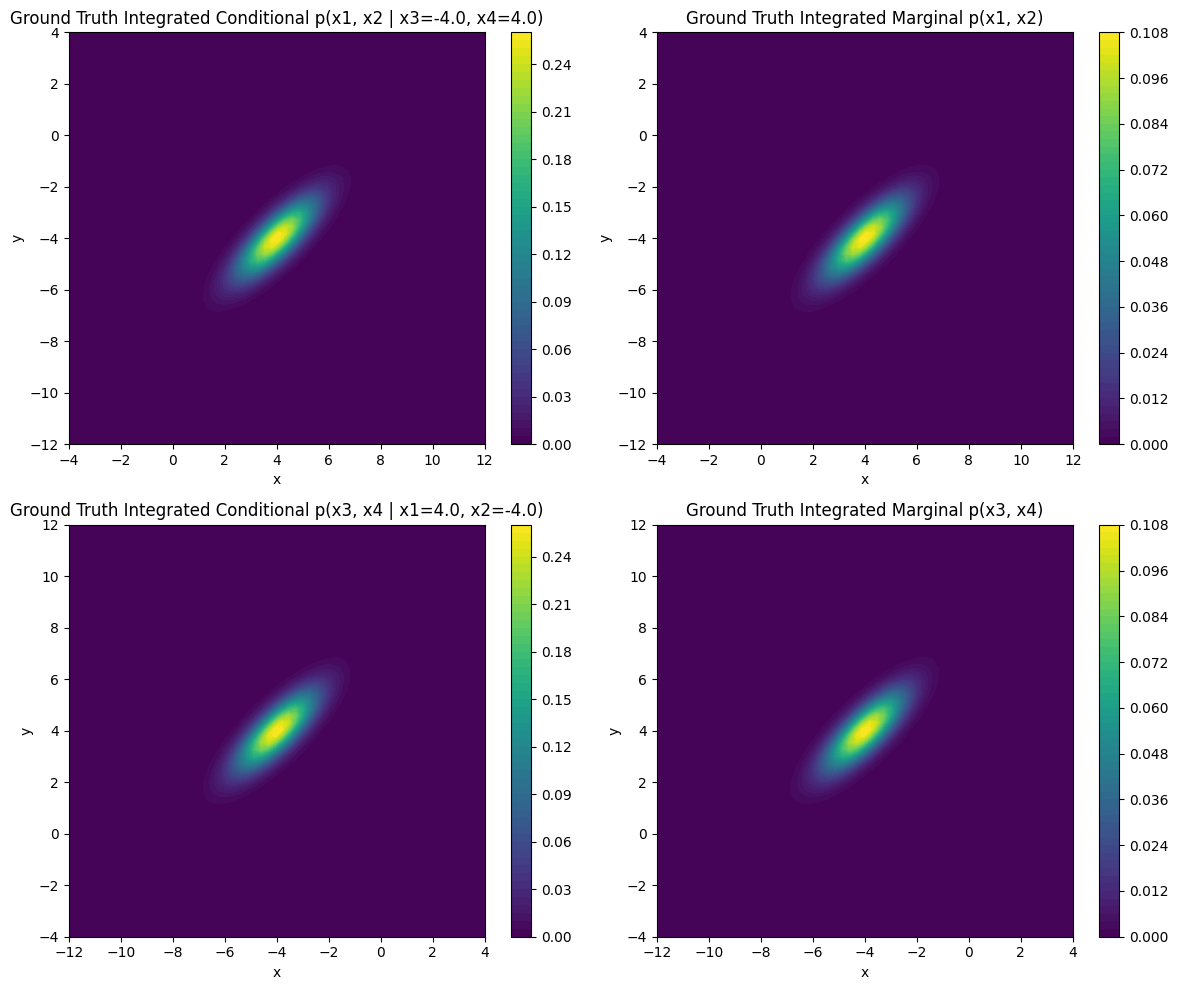

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

cf00 = axs[0, 0].contourf(X1, X2, groundtruth12_conditional_density, levels=60)
fig.colorbar(cf00, ax=axs[0, 0])
axs[0, 0].set_title("Ground Truth Integrated Conditional p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0, 0].set_xlim([-4, 12])
axs[0, 0].set_ylim([-12, 4])

cf01 = axs[0, 1].contourf(X1, X2, groundtruth12_marginal_density, levels=60)
fig.colorbar(cf01, ax=axs[0, 1])
axs[0, 1].set_title("Ground Truth Integrated Marginal p(x1, x2)")
axs[0, 1].set_xlim([-4, 12])
axs[0, 1].set_ylim([-12, 4])

cf10 = axs[1, 0].contourf(X3, X4, groundtruth34_conditional_density, levels=60)
fig.colorbar(cf10, ax=axs[1, 0])
axs[1, 0].set_title("Ground Truth Integrated Conditional p(x3, x4 | x1=4.0, x2=-4.0)")
axs[1, 0].set_xlim([-12, 4])
axs[1, 0].set_ylim([-4, 12])

cf11 = axs[1, 1].contourf(X3, X4, groundtruth34_marginal_density, levels=60)
fig.colorbar(cf11, ax=axs[1, 1])
axs[1, 1].set_title("Ground Truth Integrated Marginal p(x3, x4)")
axs[1, 1].set_xlim([-12, 4])
axs[1, 1].set_ylim([-4, 12])

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

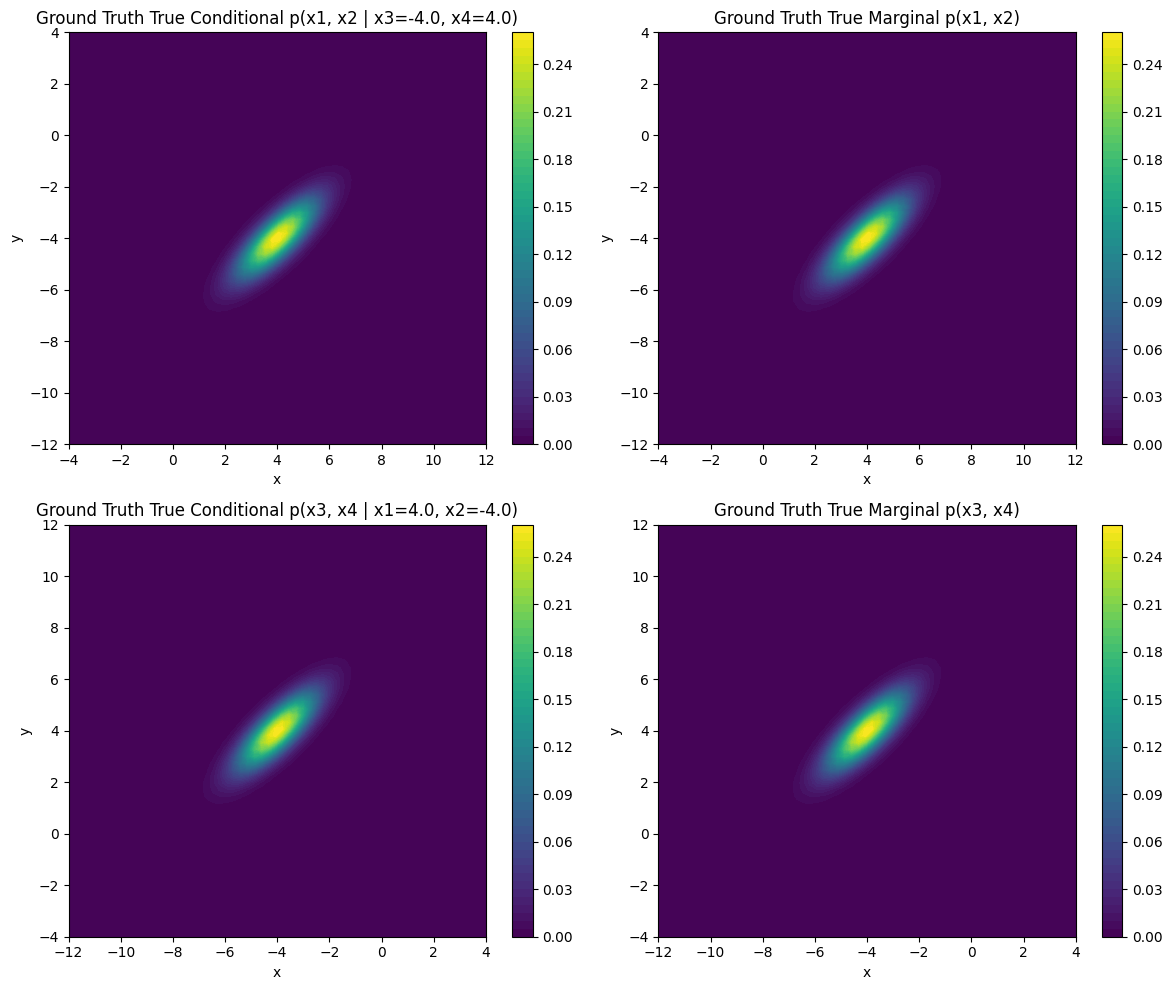

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

cf00 = axs[0, 0].contourf(X1, X2, ground_truth_cluster_1(X1, X2), levels=60)
fig.colorbar(cf00, ax=axs[0, 0])
axs[0, 0].set_title("Ground Truth True Conditional p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0, 0].set_xlim([-4, 12])
axs[0, 0].set_ylim([-12, 4])

cf01 = axs[0, 1].contourf(X1, X2, ground_truth_cluster_1(X1, X2), levels=60)
fig.colorbar(cf01, ax=axs[0, 1])
axs[0, 1].set_title("Ground Truth True Marginal p(x1, x2)")
axs[0, 1].set_xlim([-4, 12])
axs[0, 1].set_ylim([-12, 4])

cf10 = axs[1, 0].contourf(X3, X4, ground_truth_cluster_2(X3, X4), levels=60)
fig.colorbar(cf10, ax=axs[1, 0])
axs[1, 0].set_title("Ground Truth True Conditional p(x3, x4 | x1=4.0, x2=-4.0)")
axs[1, 0].set_xlim([-12, 4])
axs[1, 0].set_ylim([-4, 12])

cf11 = axs[1, 1].contourf(X3, X4, ground_truth_cluster_2(X3, X4), levels=60)
fig.colorbar(cf11, ax=axs[1, 1])
axs[1, 1].set_title("Ground Truth True Marginal p(x3, x4)")
axs[1, 1].set_xlim([-12, 4])
axs[1, 1].set_ylim([-4, 12])

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

In [23]:
xlim = (-13, 13)
ylim = (-13, 13)
color_level_min, color_level_max = 0.0, 0.25

res_color_level_min, res_color_level_max = -0.025, 0.025
levels = np.linspace(res_color_level_min, res_color_level_max, 100)  # for 100 intervals

## Residual of KDE and Ground Truth

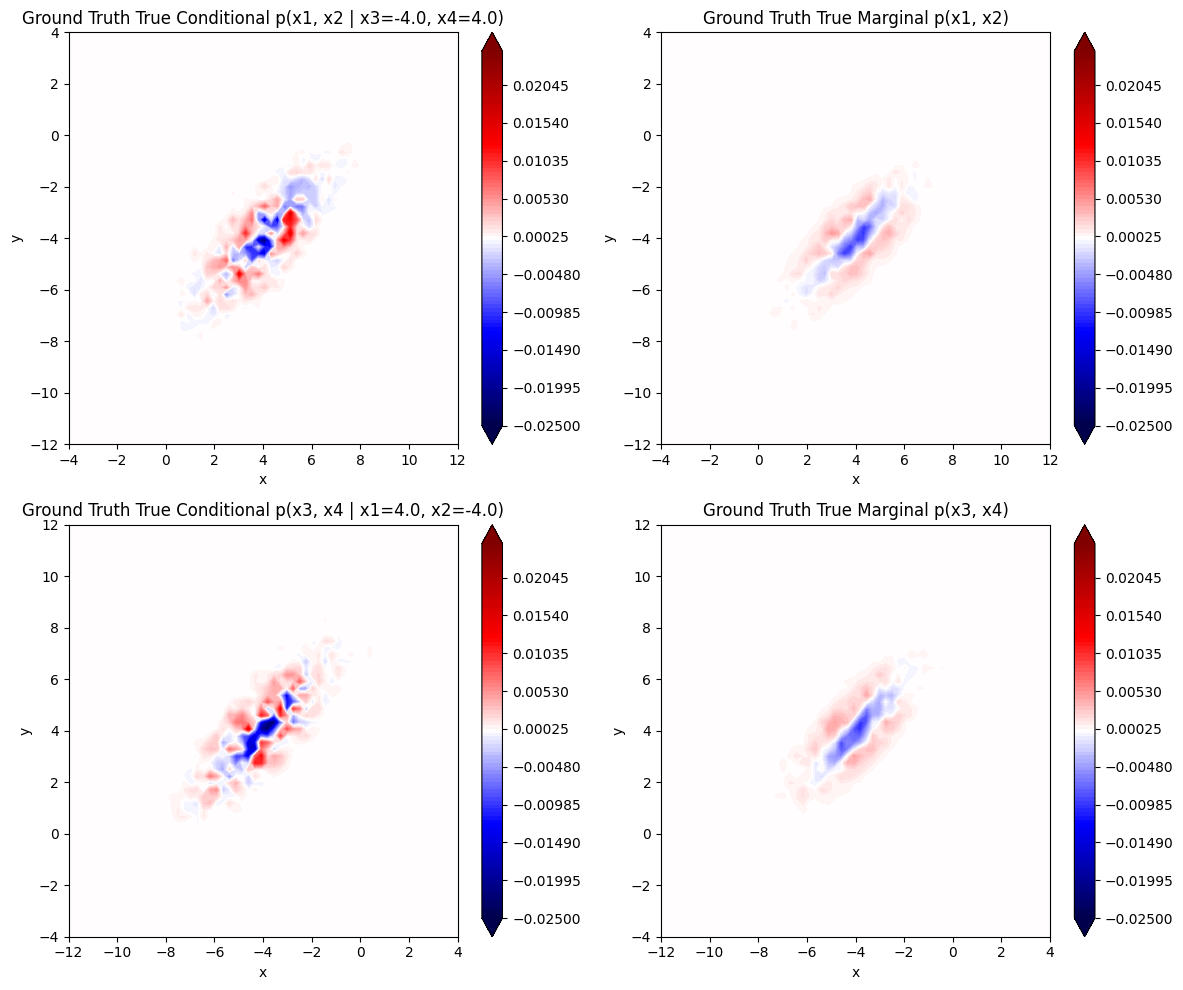

max conditional p(x1,x2|x3=-4,x4=4) residual = 0.015996326678914263
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.014606395100880576
max marginal p(x1,x2) residual = 0.015996326678914263
max marginal p(x3,x4) residual = 0.014606395100880576

min conditional p(x1,x2|x3=-4,x4=4) residual = -0.024690649704313977
min conditional p(x3,x4|x1=4,x2=-4) residual = -0.02307028010601614
min marginal p(x1,x2) residual = -0.024690649704313977
min marginal p(x3,x4) residual = -0.02307028010601614



In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

cf00 = axs[0, 0].contourf(X1, X2, kde12_conditional_density - ground_truth_cluster_1(X1, X2), levels=levels, cmap="seismic", extend="both")
fig.colorbar(cf00, ax=axs[0, 0])
axs[0, 0].set_title("Ground Truth True Conditional p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0, 0].set_xlim([-4, 12])
axs[0, 0].set_ylim([-12, 4])

cf01 = axs[0, 1].contourf(X1, X2, kde12_marginal_density - ground_truth_cluster_1(X1, X2), levels=levels, cmap="seismic", extend="both")
fig.colorbar(cf01, ax=axs[0, 1])
axs[0, 1].set_title("Ground Truth True Marginal p(x1, x2)")
axs[0, 1].set_xlim([-4, 12])
axs[0, 1].set_ylim([-12, 4])

cf10 = axs[1, 0].contourf(X3, X4, kde34_conditional_density - ground_truth_cluster_2(X3, X4), levels=levels, cmap="seismic", extend="both")
fig.colorbar(cf10, ax=axs[1, 0])
axs[1, 0].set_title("Ground Truth True Conditional p(x3, x4 | x1=4.0, x2=-4.0)")
axs[1, 0].set_xlim([-12, 4])
axs[1, 0].set_ylim([-4, 12])

cf11 = axs[1, 1].contourf(X3, X4, kde34_marginal_density - ground_truth_cluster_2(X3, X4), levels=levels, cmap="seismic", extend="both")
fig.colorbar(cf11, ax=axs[1, 1])
axs[1, 1].set_title("Ground Truth True Marginal p(x3, x4)")
axs[1, 1].set_xlim([-12, 4])
axs[1, 1].set_ylim([-4, 12])

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

print(f"max conditional p(x1,x2|x3=-4,x4=4) residual = {np.max(kde12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"max conditional p(x3,x4|x1=4,x2=-4) residual = {np.max(kde34_conditional_density - ground_truth_cluster_2(X3, X4))}")
print(f"max marginal p(x1,x2) residual = {np.max(kde12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"max marginal p(x3,x4) residual = {np.max(kde34_conditional_density - ground_truth_cluster_2(X3, X4))}\n")
print(f"min conditional p(x1,x2|x3=-4,x4=4) residual = {np.min(kde12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"min conditional p(x3,x4|x1=4,x2=-4) residual = {np.min(kde34_conditional_density - ground_truth_cluster_2(X3, X4))}")
print(f"min marginal p(x1,x2) residual = {np.min(kde12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"min marginal p(x3,x4) residual = {np.min(kde34_conditional_density - ground_truth_cluster_2(X3, X4))}\n")

In [25]:
density_scale_factor = np.loadtxt("data/processed_data/gaussian_4d_scale_factor.txt")
density_scale_factor_i12 = np.loadtxt("data/processed_data/gaussian_independent_set12_scale_factor.txt")
density_scale_factor_i34 = np.loadtxt("data/processed_data/gaussian_independent_set34_scale_factor.txt")
print(f"scale factor: {density_scale_factor}")
print(f"max kde density: {np.max(kde_predicted_density)}, min kde density: {np.min(kde_predicted_density)}")
print(f"max ground truth density: {np.max(ground_truth_density)}, min ground truth density: {np.min(ground_truth_density)}")
print(f"max integrated conditonal kde12 density: {np.max(kde12_conditional_density)}, min kde12 density: {np.min(kde12_conditional_density)}")
print(f"max integrated marginal kde12 density: {np.max(kde12_marginal_density)}, min kde12 density: {np.min(kde12_marginal_density)}")
print(f"max integrated conditonal kde34 density: {np.max(kde34_conditional_density)}, min kde34 density: {np.min(kde34_conditional_density)}")
print(f"max integrated marginal kde34 density: {np.max(kde34_marginal_density)}, min kde34 density: {np.min(kde34_marginal_density)}")
kde_predicted_density_scaled = kde_predicted_density * density_scale_factor
ground_truth_density_scaled = ground_truth_density * density_scale_factor
print(f"max scaled kde density: {np.max(kde_predicted_density_scaled)}, min scaled kde density: {np.min(kde_predicted_density_scaled)}")
print(f"max scaled ground truth density: {np.max(ground_truth_density_scaled)}, min scaled ground truth density: {np.min(ground_truth_density_scaled)}")

data_in_pipeline = np.loadtxt('data/processed_data/gaussian_4d_joint_data_in_pipeline.csv', delimiter=',', skiprows=1)
print(f"max data in pipeline: {np.max(data_in_pipeline[:,2])}, min data in pipeline: {np.min(data_in_pipeline[:,2])}")


scale factor: 61.96022118965926
max kde density: 0.16139387187450752, min kde density: 1.9621531233353659e-16
max ground truth density: 0.0669306825625229, min ground truth density: 0.0
max integrated conditonal kde12 density: 0.25596417240968844, min kde12 density: 3.5416243111625043e-16
max integrated marginal kde12 density: 0.2518396818443299, min kde12 density: 6.250408154754976e-14
max integrated conditonal kde34 density: 0.25011203295620416, min kde34 density: 3.446020993522268e-16
max integrated marginal kde34 density: 0.2505823902288904, min kde34 density: 6.250598822753528e-14
max scaled kde density: 10.000000000000012, min scaled kde density: 1.2157544152984003e-14
max scaled ground truth density: 4.147039895948788, min scaled ground truth density: 0.0
max data in pipeline: 13.000000000000004, min data in pipeline: -13.0


# Results

In [26]:
pow2 = lambda x: x ** 2
pow3 = lambda x: x ** 3
pow4 = lambda x: x ** 4
pow5 = lambda x: x ** 5

In [27]:
file_path = "data/pareto_results/gaussian_4d_results.py"
exec(open(file_path).read())

Original at complexity 1: 0.0003967275776458808
function_ready: 0.0003967275776458808
Processed: 0.000400000000000000
LaTeX: 0.0004

Original at complexity 2: pow3(0.07348626213844892)
function_ready: pow3(0.07348626213844892)
Processed: pow3(0.073)
LaTeX: 0.00039

Original at complexity 3: -0.0003455370536579901 * -1.148908032587352
function_ready: -0.0003455370536579901 * -1.148908032587352
Processed: 0.000400000000000000
LaTeX: 0.0004

Original at complexity 4: pow3(pow2(exp(-1.3052306727373593)))
function_ready: pow3(pow2(np.exp(-1.3052306727373593)))
Processed: pow3(pow2(0.27))
LaTeX: 0.00039

Original at complexity 5: log(0.9999664716881431) / pow3(-0.4386913125770685)
function_ready: np.log(0.9999664716881431) / pow3(-0.4386913125770685)
Processed: -3.4e-5/pow3(-0.44)
LaTeX: 0.0004

Original at complexity 6: 0.0004126136545285206 / (exp(x3) - -0.4888107564723538)
function_ready: 0.0004126136545285206 / (np.exp(x3) - -0.4888107564723538)
Processed: 0.00041/(exp(x3) + 0.49)
LaTeX:

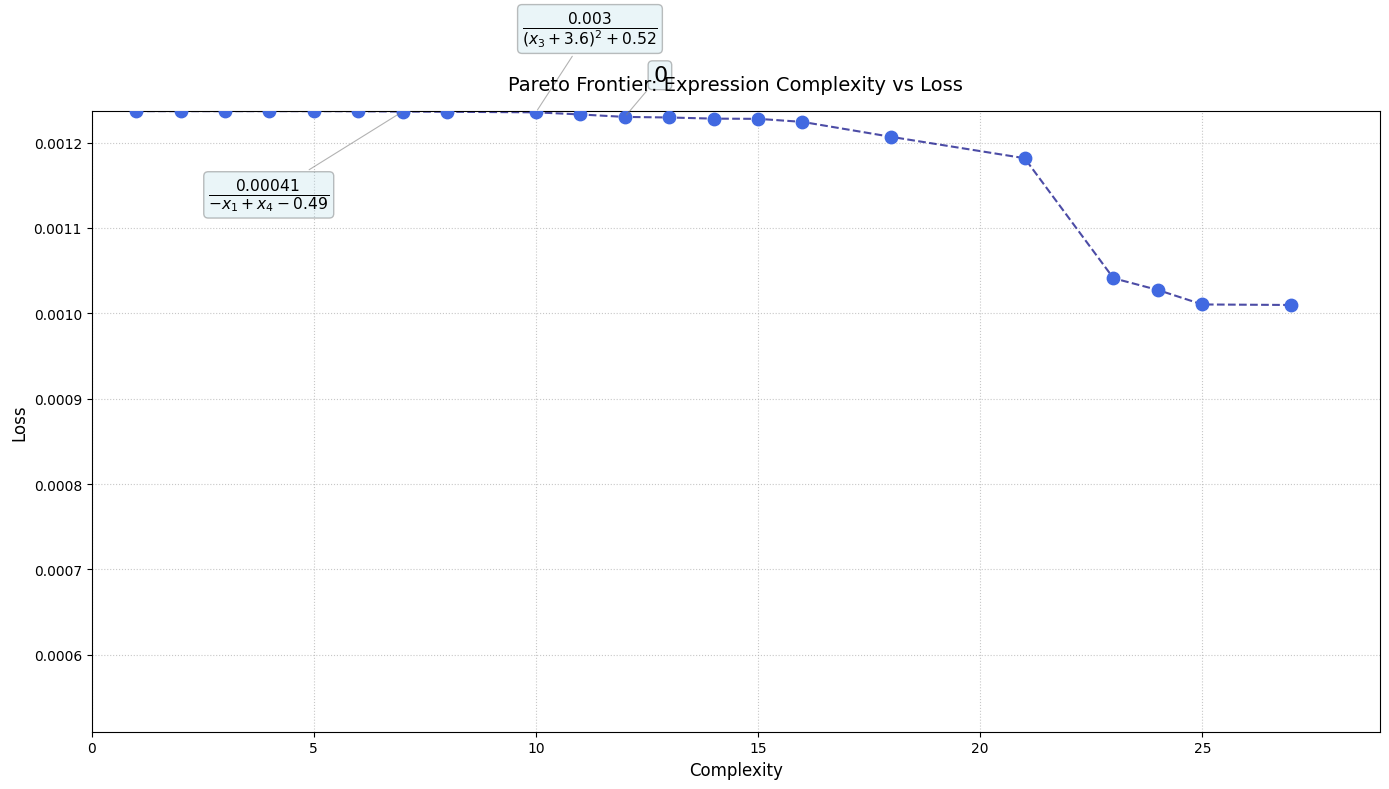

In [28]:
range_of_interest = (1, 48)
indices_of_interest = [i for i, c in enumerate(complexity) if range_of_interest[0] <= c <= range_of_interest[1]]
complexity = [complexity[i] for i in indices_of_interest]
loss = [loss[i] for i in indices_of_interest]
raw_equations = [raw_equations[i] for i in indices_of_interest]

# 2) Sympy setup
x1, x2, x3, x4 = sp.symbols('x1 x2 x3 x4')

# 3) Custom function to round constants only (not function arguments)
def round_constants(expr, ndigits=1):
    """
    Round every bare Float in `expr` so that, when printed,
    it has exactly `ndigits` digits after the decimal point
    in scientific notation (i.e. nd+1 significant figures).
    """
    def _is_leaf_float(e):
        return e.is_Float and not e.args

    def _round_sci(e):
        f = float(e)
        # format with `ndigits` places after the decimal in the mantissa:
        sci_str = f"{f:.{ndigits}e}"
        return sp.Float(sci_str)

    return expr.replace(_is_leaf_float, _round_sci)

# 4) Function to convert pow2 to squared form without evaluation
def convert_pow2(expr):
    # Find all pow2 calls
    if expr.func.__name__ == 'pow2':
        return sp.Pow(convert_pow2(expr.args[0]), 2, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow2(arg) for arg in expr.args]) if expr.args else expr

def convert_pow3(expr):
    # Find all pow3 calls
    if expr.func.__name__ == 'pow3':
        return sp.Pow(convert_pow3(expr.args[0]), 3, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow3(arg) for arg in expr.args]) if expr.args else expr

def convert_pow4(expr):
    # Find all pow4 calls
    if expr.func.__name__ == 'pow4':
        return sp.Pow(convert_pow4(expr.args[0]), 4, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow4(arg) for arg in expr.args]) if expr.args else expr

def convert_pow5(expr):
    # Find all pow5 calls
    if expr.func.__name__ == 'pow5':
        return sp.Pow(convert_pow5(expr.args[0]), 5, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow5(arg) for arg in expr.args]) if expr.args else expr

# 4) Function to convert pow_int without evaluation
def convert_pow_int(expr):
    # Find all pow_int calls
    if expr.func.__name__ == 'pow_int':
        base, exp = expr.args
        # If exp is literally an integer, convert to a Python int
        if exp.is_integer and exp.is_number:
            exp = int(exp)
        # Otherwise leave exp symbolic
        return sp.Pow(convert_pow_int(base), convert_pow_int(exp), evaluate=False)

    # Recursively descend into all other function applications
    if expr.args:
        return expr.func(*[convert_pow_int(arg) for arg in expr.args])
    else:
        return expr
    
def replace_pow_functions_recursive(expr: sp.Expr) -> sp.Expr:
    """
    Recursively replaces custom functions like powN(x) with standard power notation x**N.
    E.g. pow3(x + pow2(y)) → (x + y**2)**3
    """
    # First, apply recursively to all arguments (bottom-up),
    # so that nested pow-functions inside arguments get replaced too.
    expr = expr.xreplace({})  # no-op; just ensures expr is a Basic (not strictly needed)

    # Define replacement function
    def _repl(f):
        # check it's a function call
        if not isinstance(f, sp.Function):
            return f

        name = f.func.__name__
        if not name.startswith("pow"):
            return f

        # parse N from “powN”
        try:
            N = int(name[len("pow"):])
        except ValueError:
            return f

        if len(f.args) != 1:
            # unexpected arity, leave unchanged
            return f

        base = f.args[0]
        # Recursively transform the base
        new_base = replace_pow_functions_recursive(base)
        return new_base ** N

    # Use replace with map=False (so it returns an Expr)
    new_expr = expr.replace(
        lambda x: isinstance(x, sp.Function) and x.func.__name__.startswith("pow"),
        _repl,
        map=False
    )
    return new_expr

# 5) Build MathText labels
latex_labels = []
exprs_final = []
function_ready = []
for id, s in enumerate(raw_equations):
    try:
        # Pre-process pow2 -> custom function
        s_processed = s.replace('pow2', 'pow2_func')
        s_processed = s.replace('pow3', 'pow3_func')
        s_processed = s.replace('pow4', 'pow4_func')
        s_processed = s.replace('pow5', 'pow5_func')
        s_processed = s_processed.replace('pow_int', 'pow_int_func')
        
        # Define custom functions
        locals_dict = {
            'x1': x1,
            'x2': x2,
            'x3': x3,
            'x4': x4,
            'pow2_func': sp.Function('pow2'),
            'pow3_func': sp.Function('pow3'),
            'pow4_func': sp.Function('pow4'),
            'pow5_func': sp.Function('pow5'),
            'pow_int_func': sp.Function('pow_int'),
            'asin': sp.asin,
            'atan': sp.atan,
            'tan': sp.tan,
            'exp': sp.exp,
        }
        
        # Parse while preserving structure
        expr = parse_expr(s_processed, evaluate=False, local_dict=locals_dict)
        
        # Convert pow2_func to squared form
        expr_converted_pow2 = convert_pow2(expr)
        expr_converted_pow3 = convert_pow3(expr)
        expr_converted_pow4 = convert_pow4(expr)
        expr_converted_pow5 = convert_pow5(expr)
        expr_converted = convert_pow_int(expr_converted_pow5)
        
        # Round constants (only standalone floats)
        expr_converted_int1 = round_constants(expr_converted)
        expr_converted_int2 = round_constants(expr_converted_int1)
        expr_final = round_constants(expr_converted_int2)
        # expr_final = expr_final.simplify()
        # expr_final = expr_final.expand()
        exprs_final.append(expr_final)

        # Get MathText-friendly LaTeX
        mt = replace_pow_functions_recursive(expr_final)
        expr_converted_int1 = round_constants(mt)
        expr_converted_int2 = round_constants(expr_converted_int1)
        mt = round_constants(expr_converted_int2)
        mt = sp.latex(mt)
        latex_labels.append(f"${mt}$")
        
        # Replace 'exp' with 'np.exp'
        modified_expression = s.replace('exp', 'np.exp')
    
        # Replace 'log' with 'np.log'
        modified_expression = modified_expression.replace('log', 'np.log')
        function_ready.append(modified_expression)
        # Debug print
        print(f"Original at complexity {complexity[id]}: {s}")
        print(f"function_ready: {modified_expression}")
        print(f"Processed: {expr_final}")
        print(f"LaTeX: {mt}\n")
    except Exception as e:
        print(f"Error processing expression: {s}\n{e}")
        latex_labels.append(f"Error: {s}")

# 6) Manual offsets for clarity
offsets = [
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (-140, -60), (0, 0), (-10, 60), (0, 0),
    (20, 30), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (-150, 60), (0, 0), (0, 0),
]

# 7) Plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(complexity, loss, s=80, zorder=3, color='royalblue')
ax.plot(complexity, loss, linestyle='--', alpha=0.7, zorder=2, color='navy')

# Set axis limits
ax.set_xlim(min(complexity) - 1, max(complexity) + 2)
ax.set_ylim(min(loss) - 0.0005, max(loss))
fig.subplots_adjust(right=0.75)


skip_indices = []
keep_indices = [7-1, 9-1, 11-1, 23-1]
# Annotate with MathText labels
for i, (x, y, lbl, (dx, dy)) in enumerate(zip(complexity, loss, latex_labels, offsets)):
    if i in skip_indices or (i not in keep_indices):
        continue
    ax.annotate(
        lbl,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords='offset points',
        ha='left',
        va='center',
        fontsize=16,
        bbox=dict(boxstyle='round,pad=0.2', alpha=0.25, fc='lightblue'),
        arrowprops=dict(arrowstyle='-', lw=0.8, alpha=0.6, color='gray')
    )

ax.set_title("Pareto Frontier: Expression Complexity vs Loss", fontsize=14, pad=15)
ax.set_xlabel("Complexity", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# Residuals: Prediction - Ground Truth

In [29]:
level_min = 0
level_max = 0.5
level_min_delta = -0.5
level_max_delta = 0.5

levels_results = np.linspace(level_min, level_max, 100)
levels_results_residuals = np.linspace(level_min_delta, level_max_delta, 100)

In [30]:
predicted_functions = [eval(f'lambda x1, x2, x3, x4: {str_func}', {'np':np, 'pow2':pow2, 'pow3':pow3, 'pow4':pow4, 'pow5':pow5}) for str_func in function_ready]

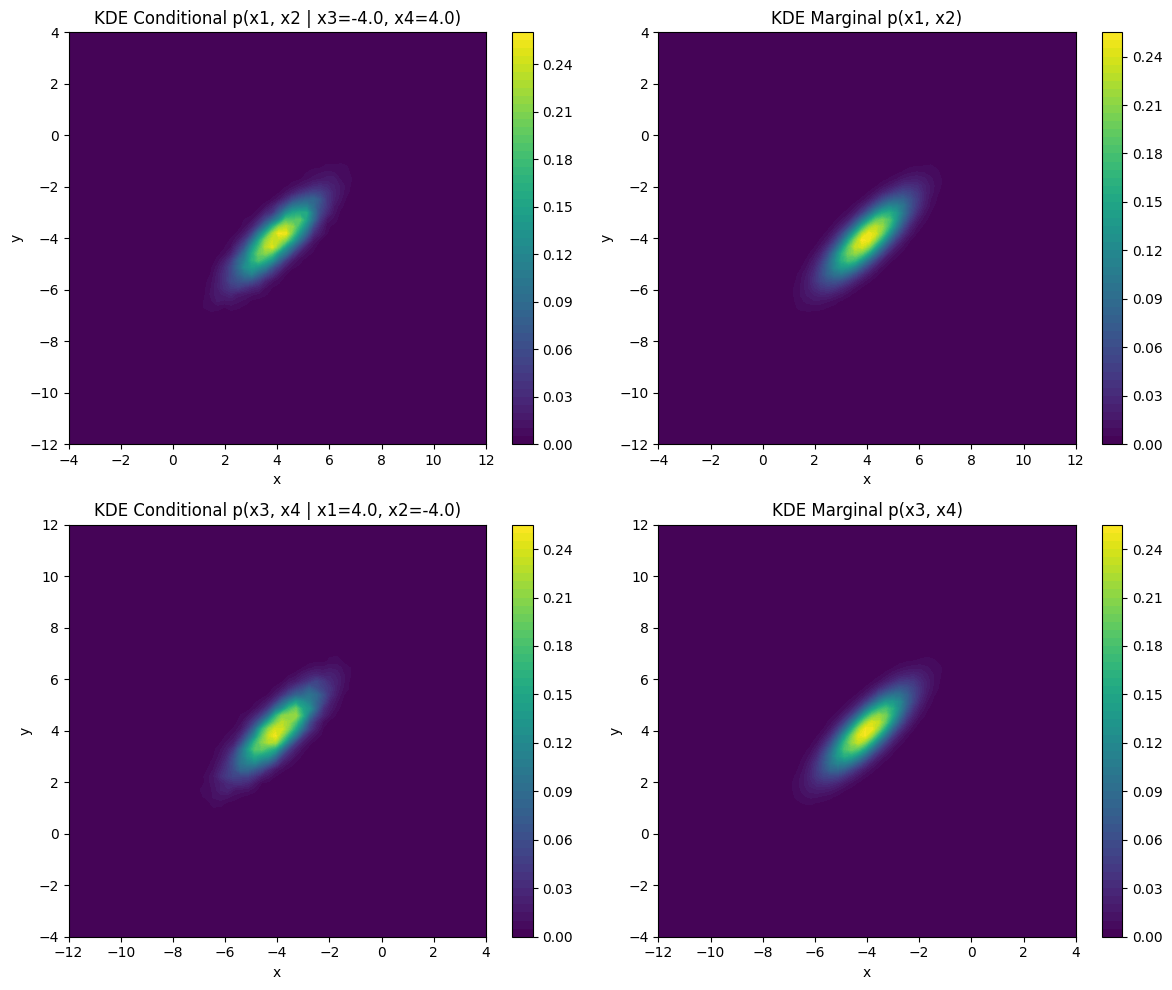

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

cf00 = axs[0, 0].contourf(X1, X2, kde12_conditional_density, levels=60)
fig.colorbar(cf00, ax=axs[0, 0])
axs[0, 0].set_title("KDE Conditional p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0, 0].set_xlim([-4, 12])
axs[0, 0].set_ylim([-12, 4])

cf01 = axs[0, 1].contourf(X1, X2, kde12_marginal_density, levels=60)
fig.colorbar(cf01, ax=axs[0, 1])
axs[0, 1].set_title("KDE Marginal p(x1, x2)")
axs[0, 1].set_xlim([-4, 12])
axs[0, 1].set_ylim([-12, 4])

cf10 = axs[1, 0].contourf(X3, X4, kde34_conditional_density, levels=60)
fig.colorbar(cf10, ax=axs[1, 0])
axs[1, 0].set_title("KDE Conditional p(x3, x4 | x1=4.0, x2=-4.0)")
axs[1, 0].set_xlim([-12, 4])
axs[1, 0].set_ylim([-4, 12])

cf11 = axs[1, 1].contourf(X3, X4, kde34_marginal_density, levels=60)
fig.colorbar(cf11, ax=axs[1, 1])
axs[1, 1].set_title("KDE Marginal p(x3, x4)")
axs[1, 1].set_xlim([-12, 4])
axs[1, 1].set_ylim([-4, 12])

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

In [32]:
# 2. Interpolate the reflected function at the original grid points
# Prepare the interpolator for the original function
interp_kde_at_samples = RegularGridInterpolator(
    (grids[0][:,0,0,0], grids[1][0,:,0,0], grids[2][0,0,:,0], grids[3][0,0,0,:]),  # axes of the grid
    kde_predicted_density,            # function values
    bounds_error=False,
    fill_value=0
)

# Load the test set for the Gaussian mixture
test_samples = np.loadtxt("./data/processed_data/gaussian_4d_test_samples.csv", delimiter=",")

# For each original grid point, get the value of the reflected functions at that location
kde_eval_at_samples = interp_kde_at_samples(test_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}")

Likelihood score of the corrected KDE: -94,623.55705924894


In [33]:
print(f"min kde: {np.min(kde_predicted_density):.3f}, max kde: {np.max(kde_predicted_density):.3f}")

min kde: 0.000, max kde: 0.161


In [34]:
kde_eval_at_samples = interp_kde_at_samples(test_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}\n")

for idx, func in enumerate(predicted_functions):
    # Compute likelihood scores
    prediction_eval_at_samples = func(test_samples[:, 0], test_samples[:, 1], test_samples[:, 2], test_samples[:, 3])
    likelihood_score_pred = np.sum(np.log(prediction_eval_at_samples/density_scale_factor + 1e-12))  # add small value to avoid log(0)
    print(f"Function at complexity {complexity[idx]}: Likelihood score = {likelihood_score_pred:,}")

Likelihood score of the corrected KDE: -94,623.55705924894

Function at complexity 1: Likelihood score = -11.958753144467385
Function at complexity 2: Likelihood score = -11.958462829029996
Function at complexity 3: Likelihood score = -11.958091148976331
Function at complexity 4: Likelihood score = -11.957876465803363
Function at complexity 5: Likelihood score = -11.957718190041566
Function at complexity 6: Likelihood score = -281,531.7016656487
Function at complexity 7: Likelihood score = nan
Function at complexity 8: Likelihood score = -332,874.36882399075
Function at complexity 10: Likelihood score = -253,496.03936867192
Function at complexity 11: Likelihood score = nan
Function at complexity 12: Likelihood score = nan
Function at complexity 13: Likelihood score = nan
Function at complexity 14: Likelihood score = nan
Function at complexity 15: Likelihood score = nan
Function at complexity 16: Likelihood score = -454,225.33472019306
Function at complexity 18: Likelihood score = nan
F

/tmp/ipykernel_2424218/3031941868.py:8: RuntimeWarning: invalid value encountered in log
  likelihood_score_pred = np.sum(np.log(prediction_eval_at_samples/density_scale_factor + 1e-12))  # add small value to avoid log(0)


In [35]:
current_function = predicted_functions[0]
func_predicted_density = current_function(grid_coordinates[:,0], grid_coordinates[:,1], grid_coordinates[:,2], grid_coordinates[:,3])/density_scale_factor
func_predicted_density
np.shape(grids[0])

(100, 100, 100, 100)

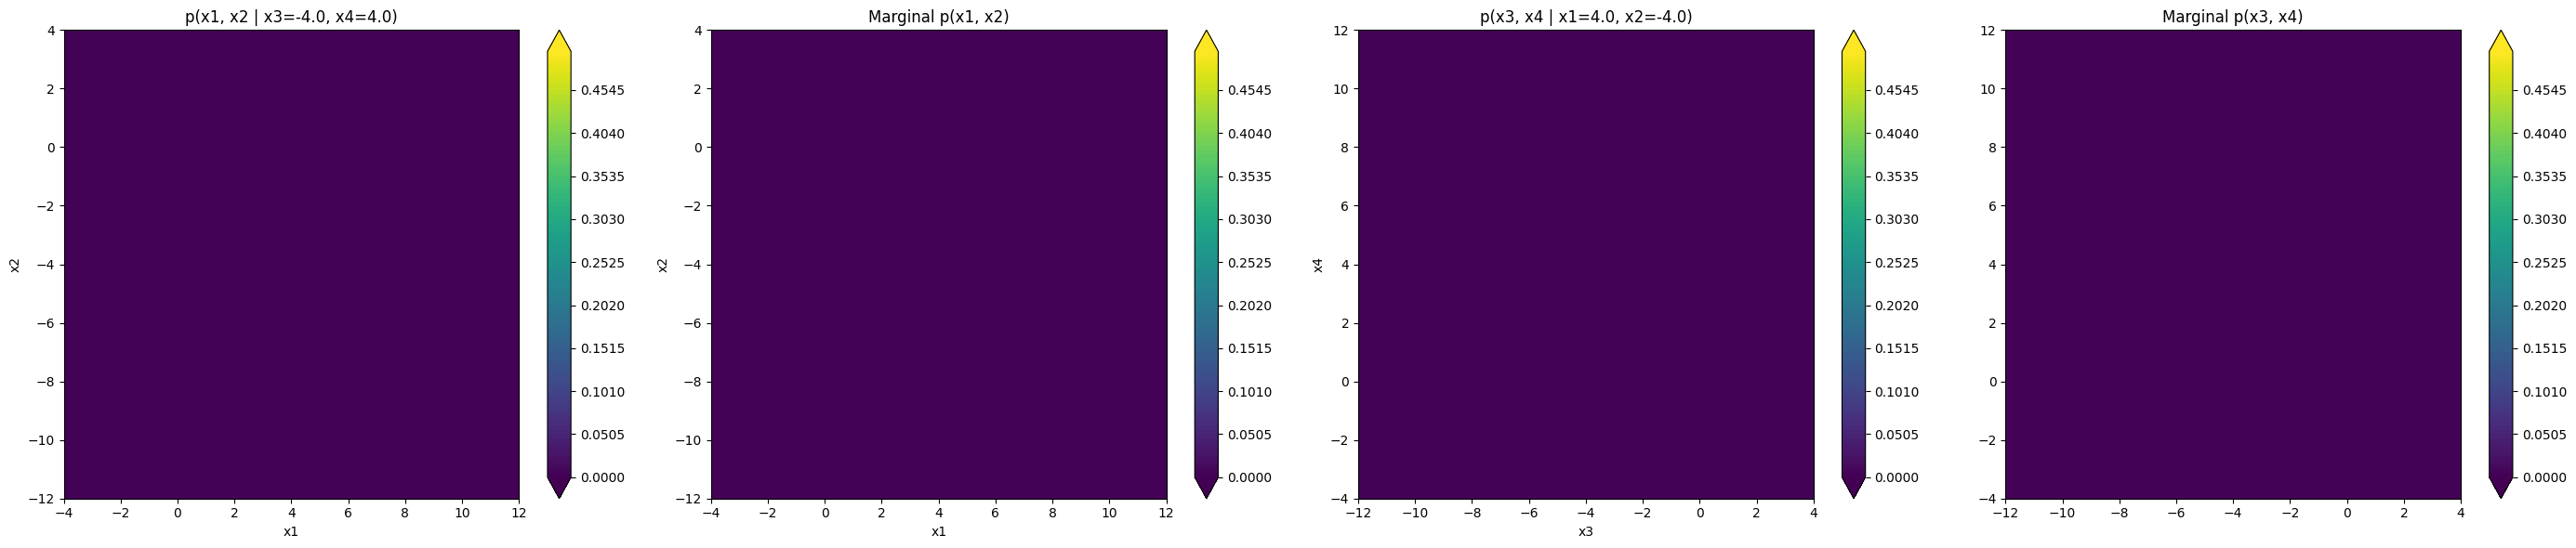

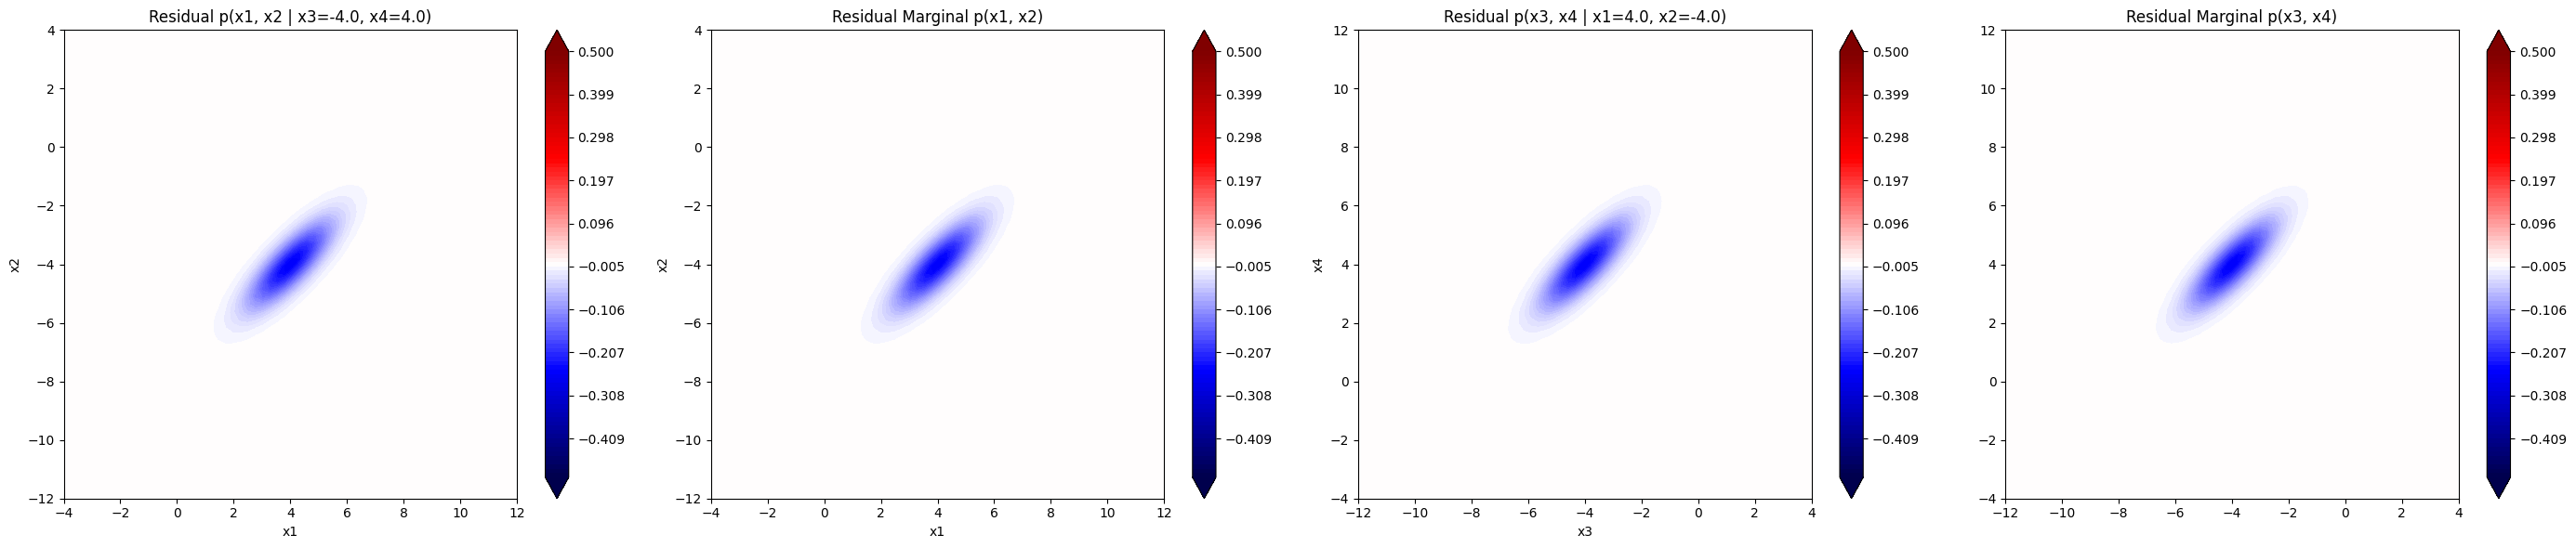

Complexity 1: Likelihood score: -11.958753300645629
complexity 1 :: min predict conditional 12: 0.0014792899408284015, max predict conditional 12: 0.0014792899408284015
complexity 1 :: min predict marginal 12: 0.0014792899408284023, max predict marginal 12: 0.0014792899408284023
complexity 1 :: min predict conditional 34: 0.0014792899408284015, max predict conditional 34: 0.0014792899408284015
complexity 1 :: min predict marginal 34: 0.001802970741027005, max predict marginal 34: 0.001802970741027005
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.0014792899408284015
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.0014792899408284015
max marginal p(x1,x2) residual = 0.0014792899408284015
max marginal p(x3,x4) residual = 0.0014792899408284015



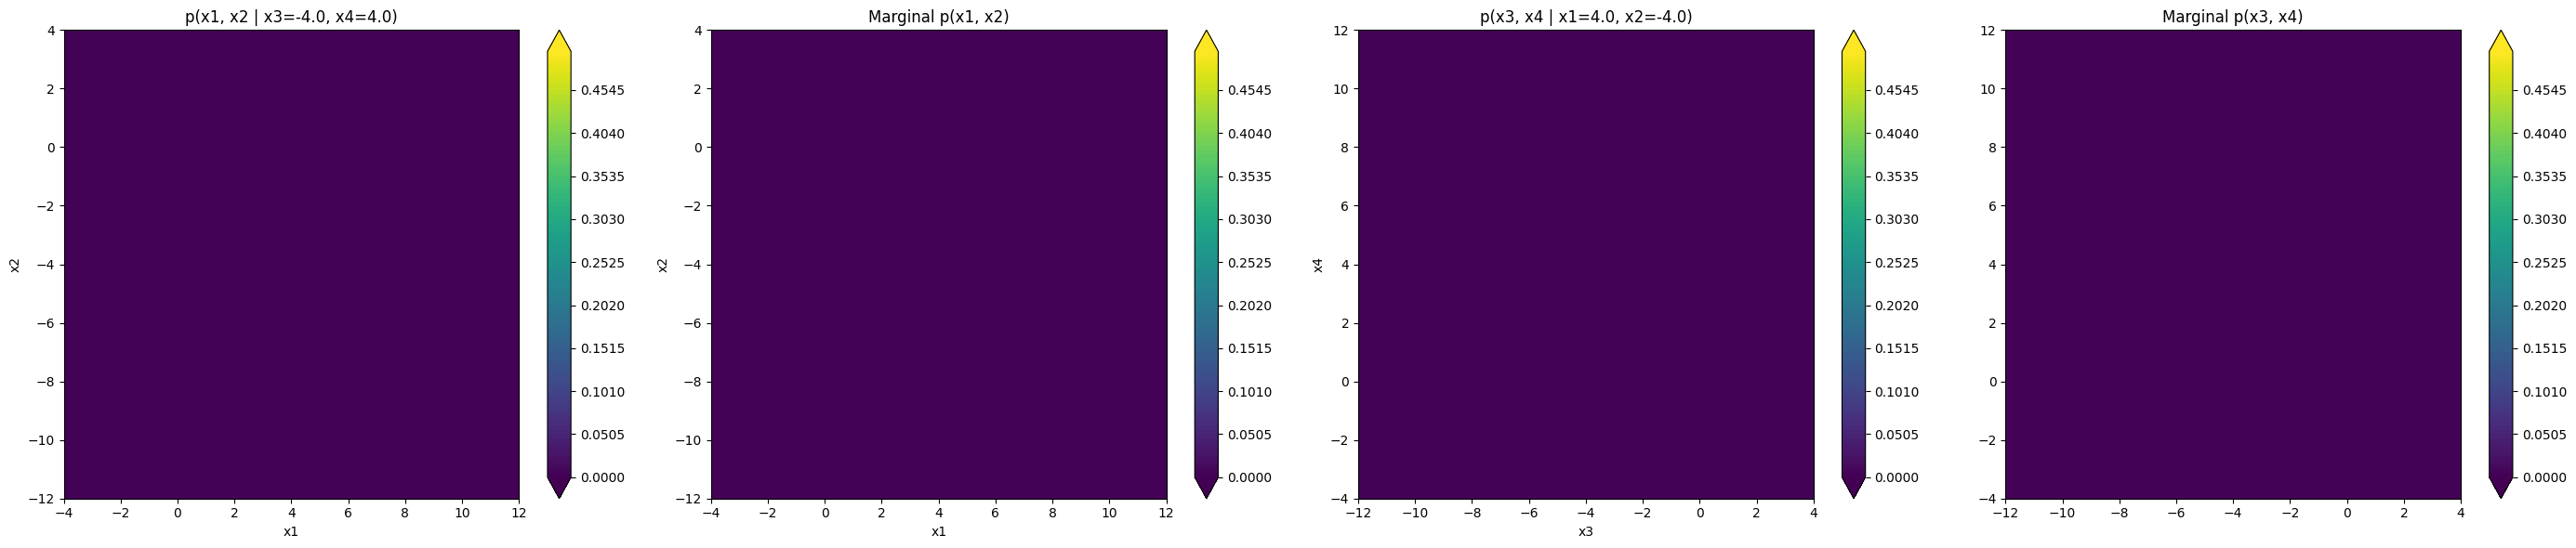

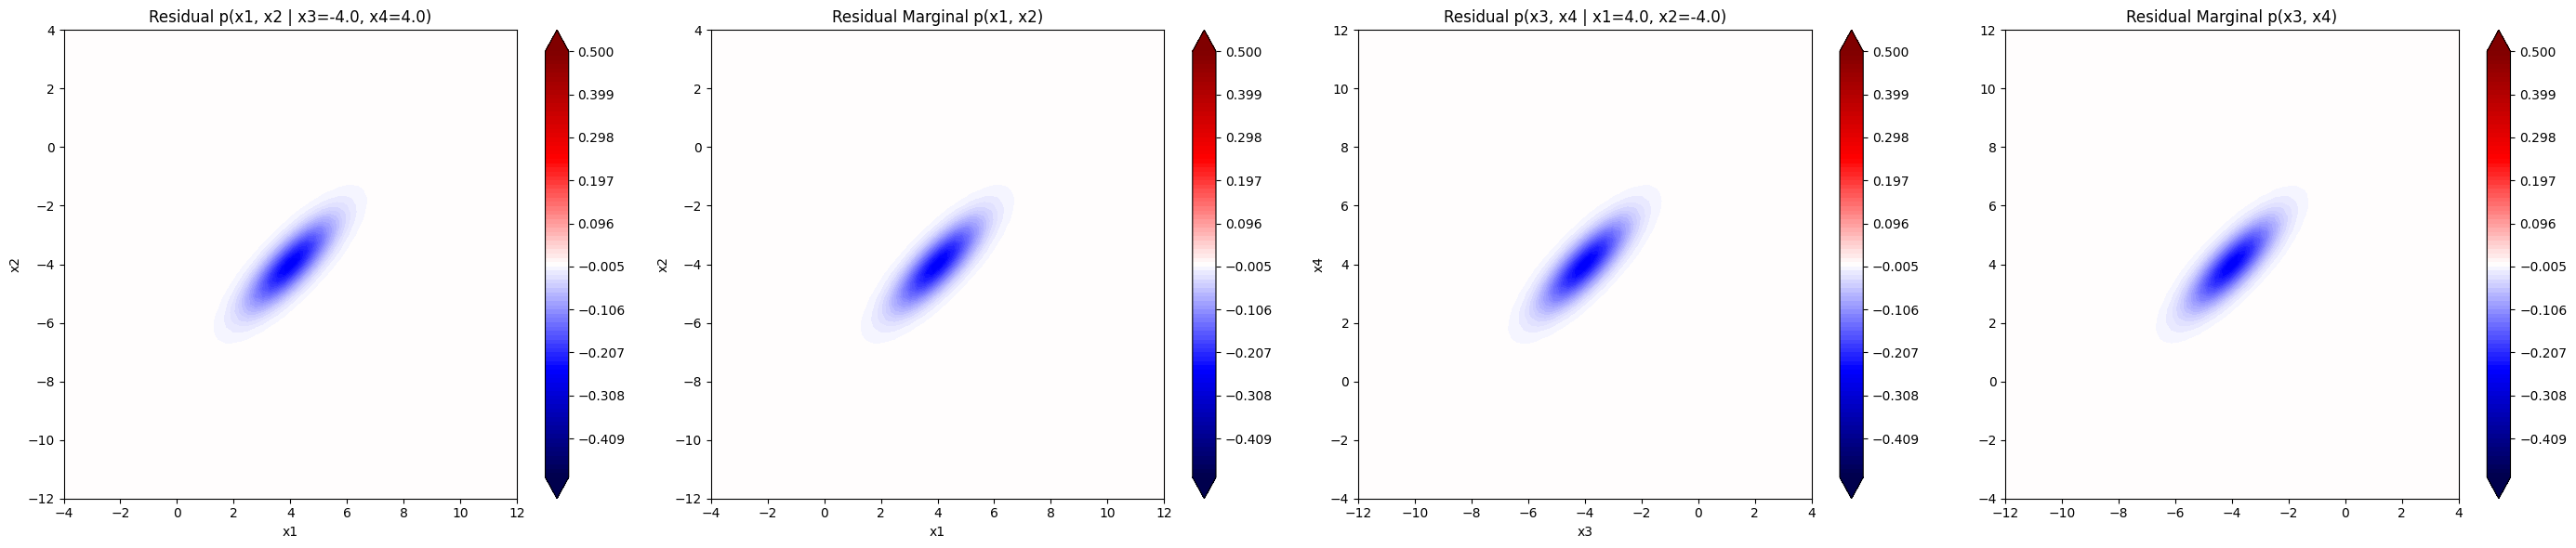

Complexity 2: Likelihood score: -11.958462985162907
complexity 2 :: min predict conditional 12: 0.001479289940828402, max predict conditional 12: 0.001479289940828402
complexity 2 :: min predict marginal 12: 0.0014792899408284017, max predict marginal 12: 0.0014792899408284017
complexity 2 :: min predict conditional 34: 0.001479289940828402, max predict conditional 34: 0.001479289940828402
complexity 2 :: min predict marginal 34: 0.0018034942473353346, max predict marginal 34: 0.0018034942473353346
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.001479289940828402
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.001479289940828402
max marginal p(x1,x2) residual = 0.001479289940828402
max marginal p(x3,x4) residual = 0.001479289940828402



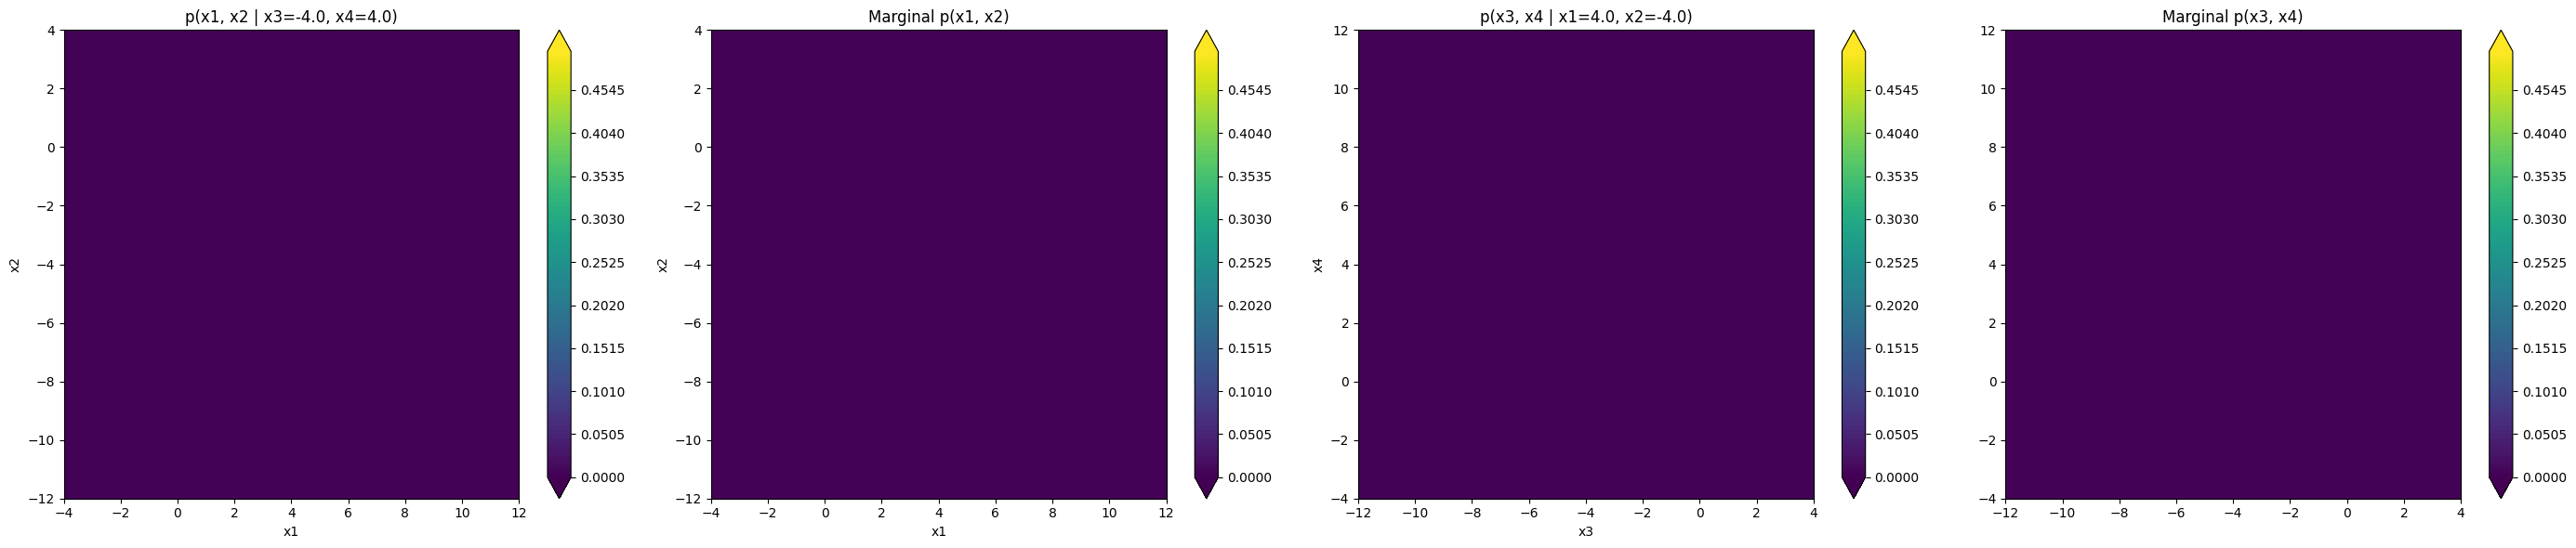

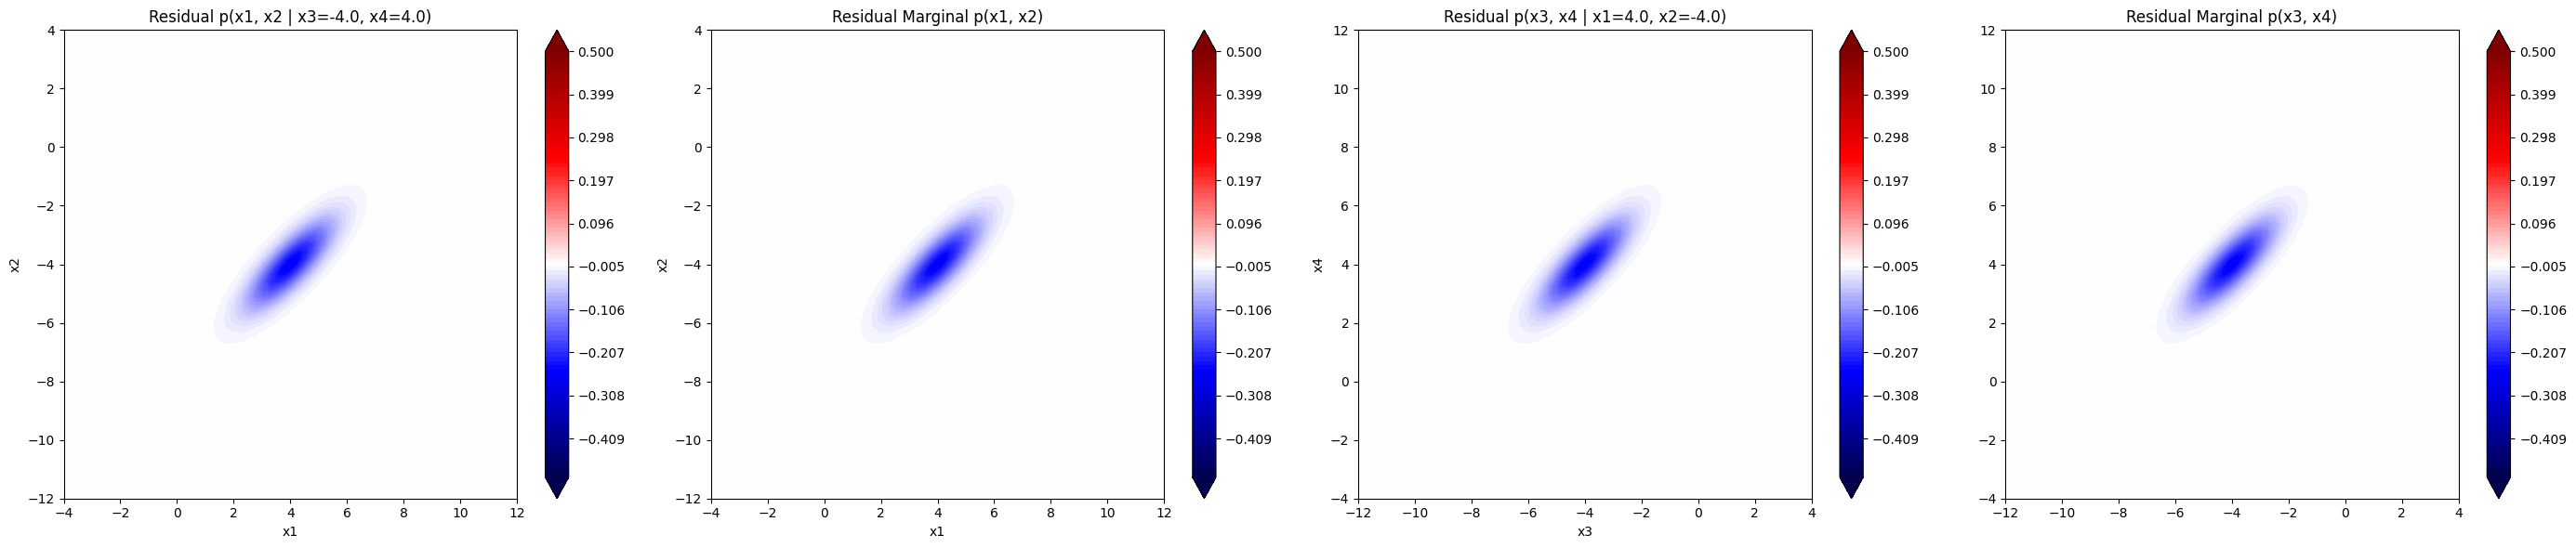

Complexity 3: Likelihood score: -11.95809130505122
complexity 3 :: min predict conditional 12: 0.0014792899408284023, max predict conditional 12: 0.0014792899408284023
complexity 3 :: min predict marginal 12: 0.0014792899408284017, max predict marginal 12: 0.0014792899408284017
complexity 3 :: min predict conditional 34: 0.001479289940828402, max predict conditional 34: 0.001479289940828402
complexity 3 :: min predict marginal 34: 0.0018041646948668967, max predict marginal 34: 0.0018041646948668967
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.0014792899408284023
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.001479289940828402
max marginal p(x1,x2) residual = 0.0014792899408284023
max marginal p(x3,x4) residual = 0.001479289940828402



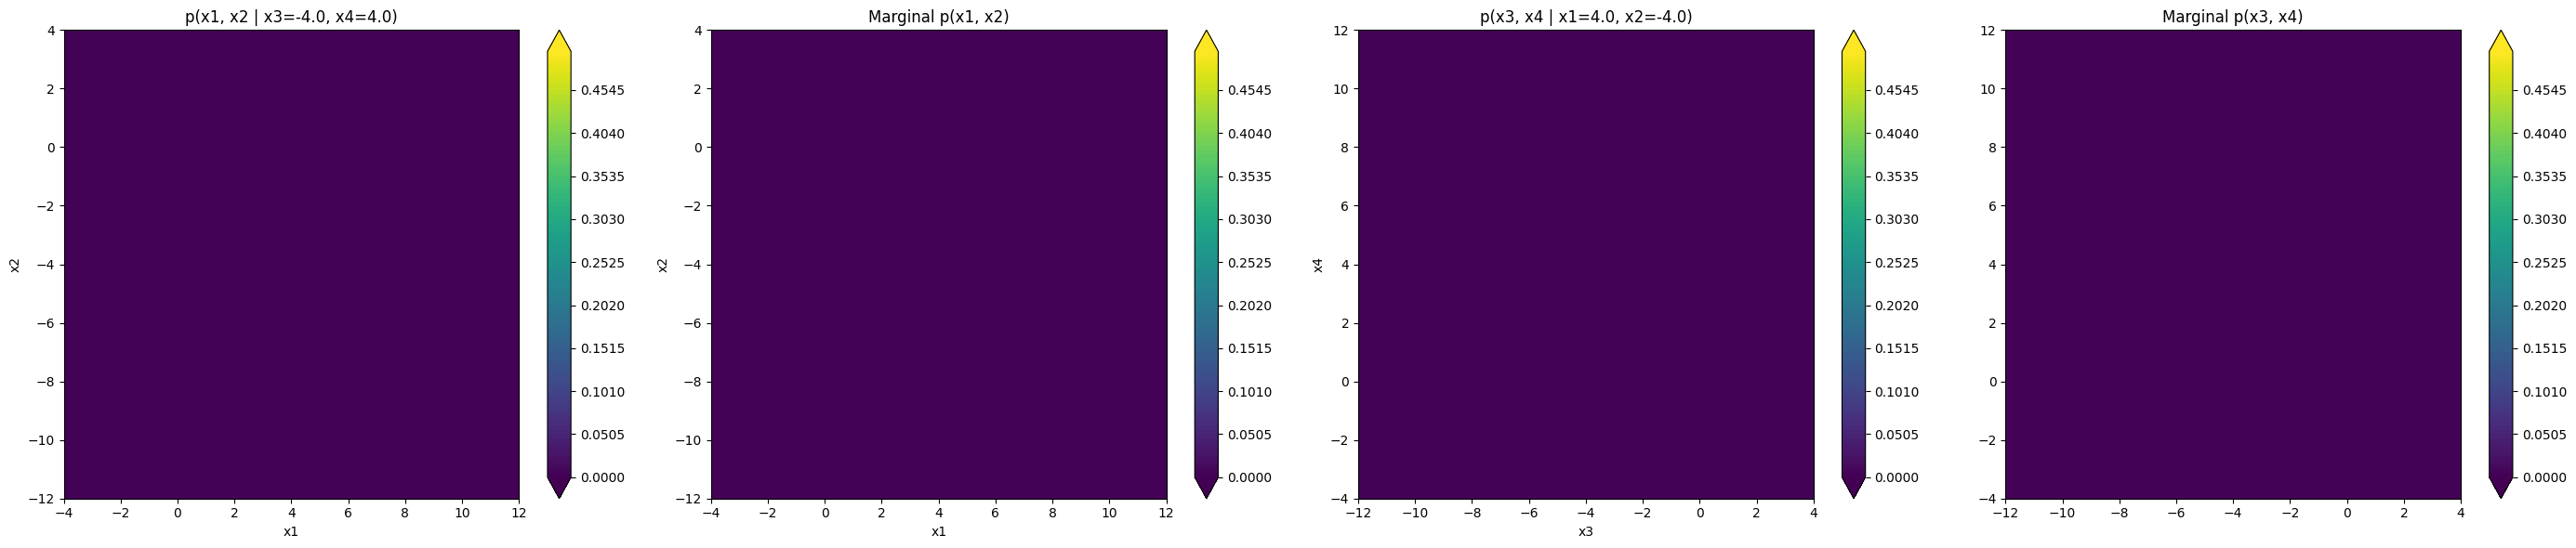

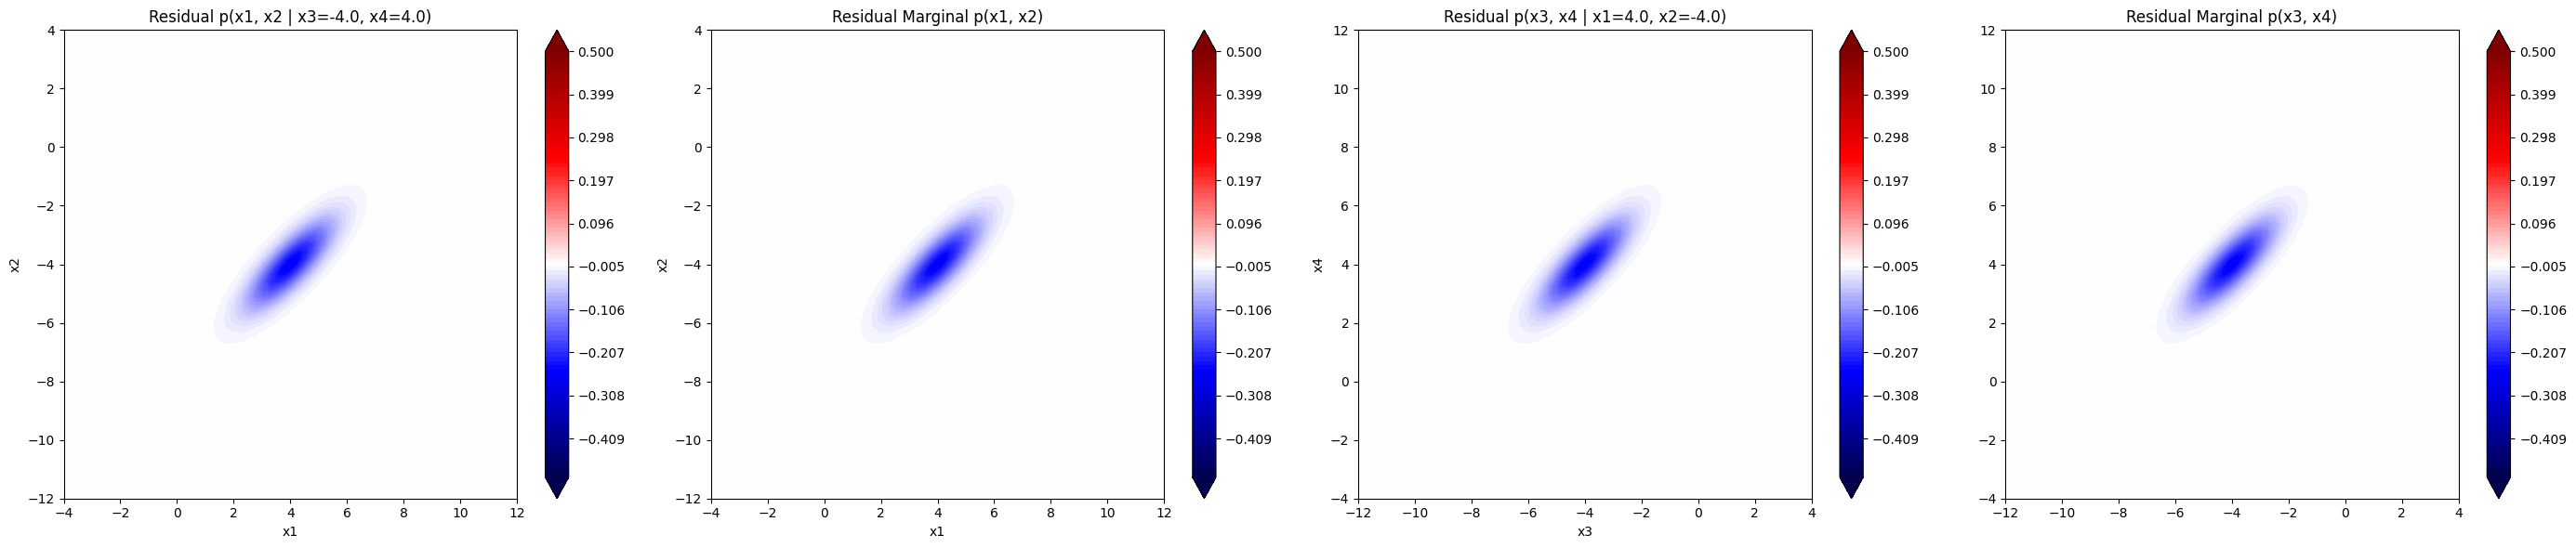

Complexity 4: Likelihood score: -11.957876621844749
complexity 4 :: min predict conditional 12: 0.0014792899408284028, max predict conditional 12: 0.0014792899408284028
complexity 4 :: min predict marginal 12: 0.0014792899408284021, max predict marginal 12: 0.0014792899408284021
complexity 4 :: min predict conditional 34: 0.0014792899408284021, max predict conditional 34: 0.0014792899408284021
complexity 4 :: min predict marginal 34: 0.0018045520603075312, max predict marginal 34: 0.0018045520603075312
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.0014792899408284028
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.0014792899408284021
max marginal p(x1,x2) residual = 0.0014792899408284028
max marginal p(x3,x4) residual = 0.0014792899408284021



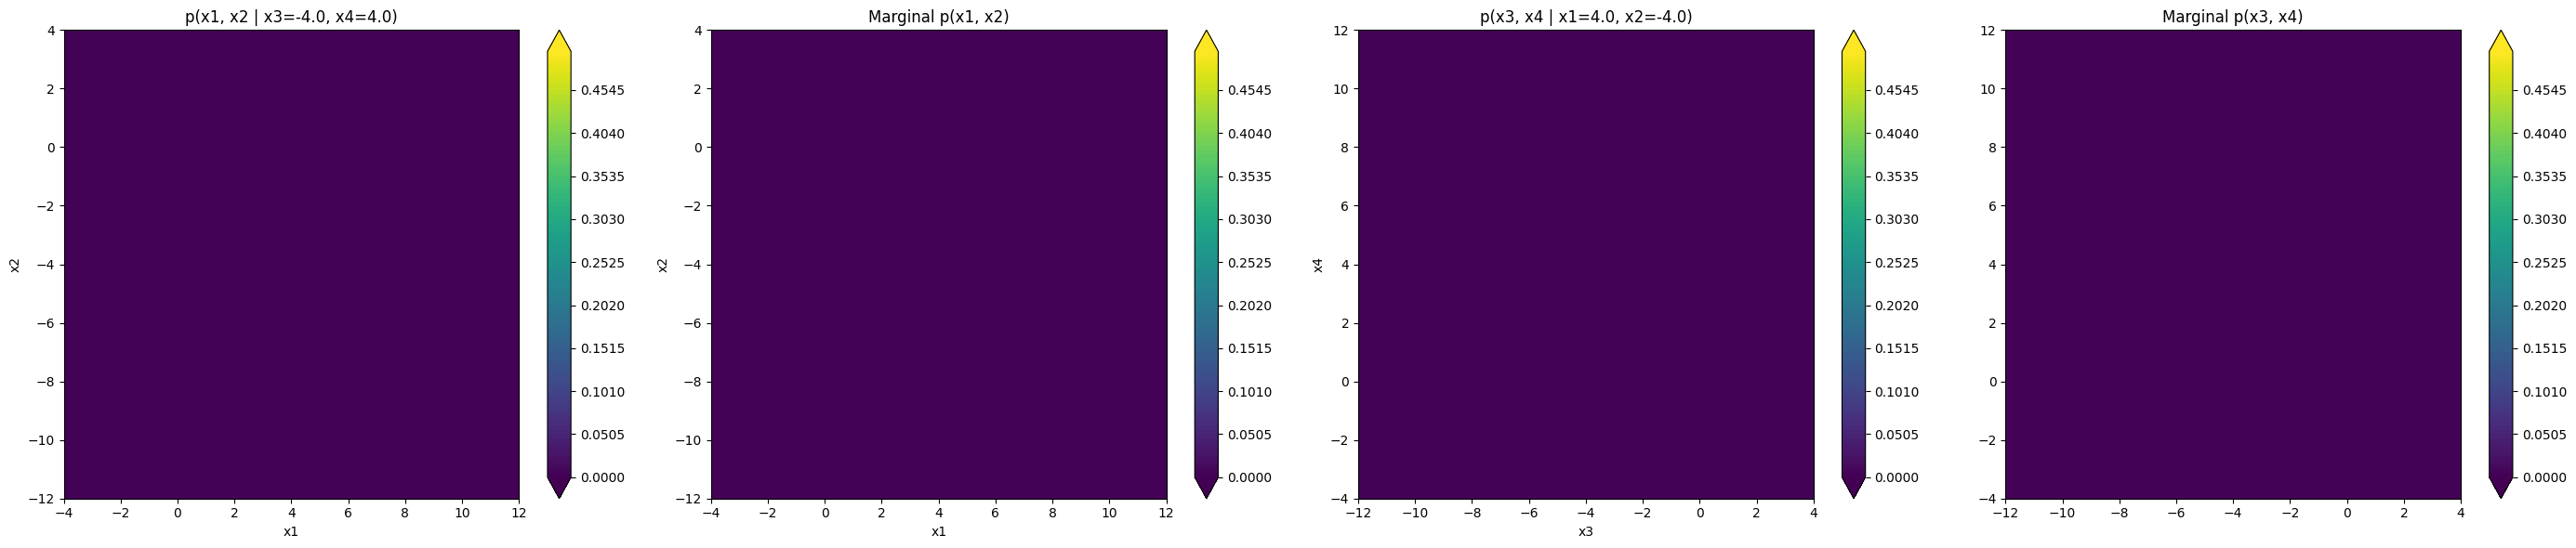

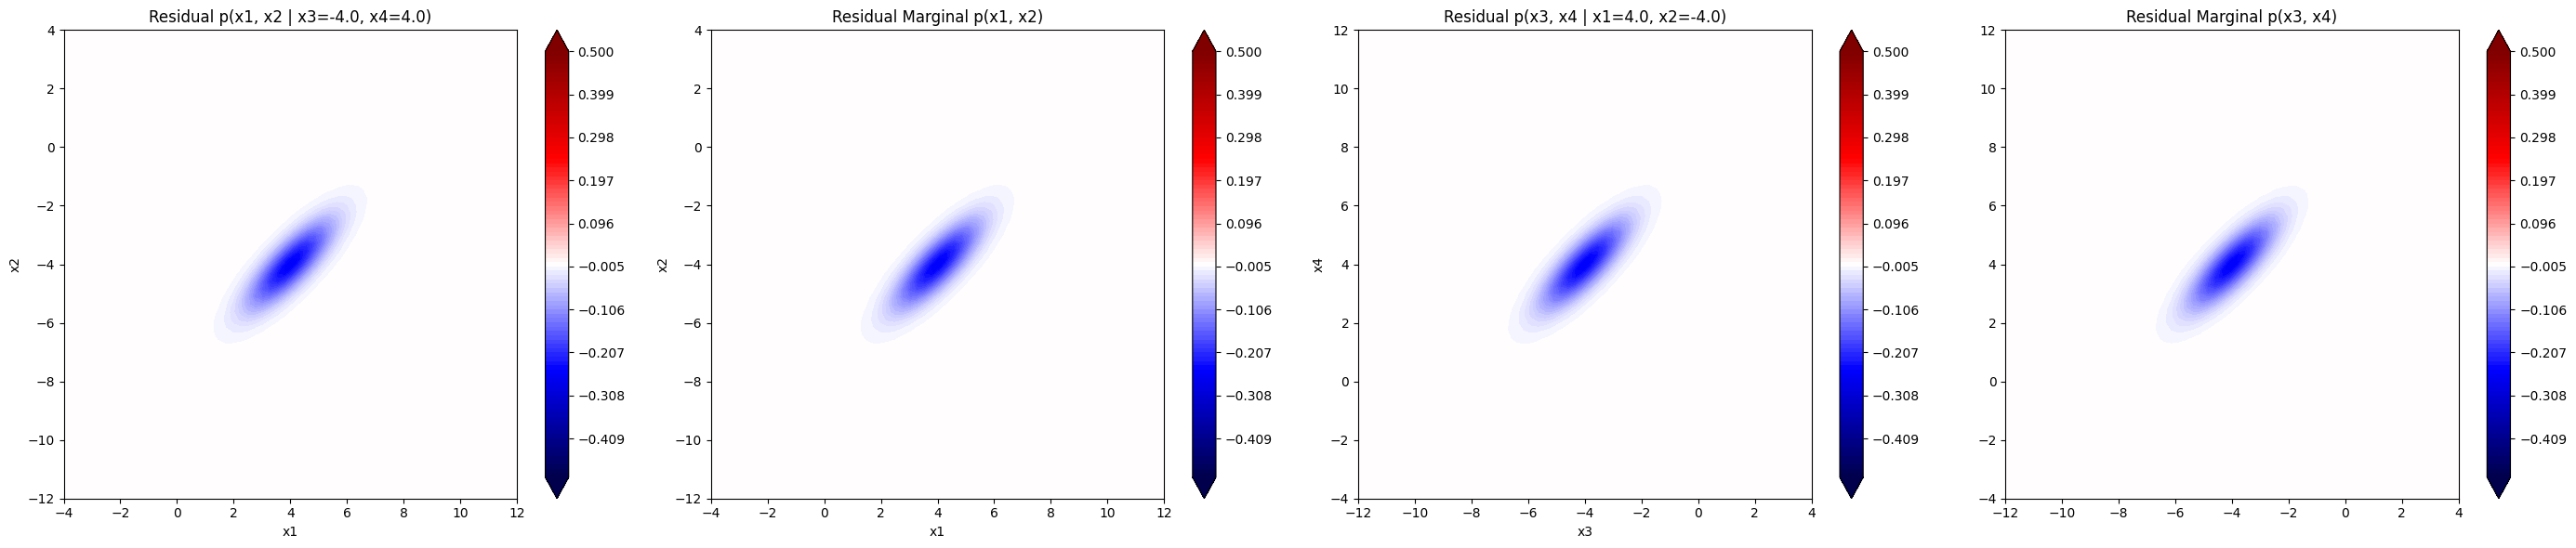

Complexity 5: Likelihood score: -11.957718346058256
complexity 5 :: min predict conditional 12: 0.0014792899408284025, max predict conditional 12: 0.0014792899408284025
complexity 5 :: min predict marginal 12: 0.0014792899408284025, max predict marginal 12: 0.0014792899408284025
complexity 5 :: min predict conditional 34: 0.0014792899408284025, max predict conditional 34: 0.0014792899408284025
complexity 5 :: min predict marginal 34: 0.0018048376998084491, max predict marginal 34: 0.0018048376998084491
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.0014792899408284025
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.0014792899408284025
max marginal p(x1,x2) residual = 0.0014792899408284025
max marginal p(x3,x4) residual = 0.0014792899408284025



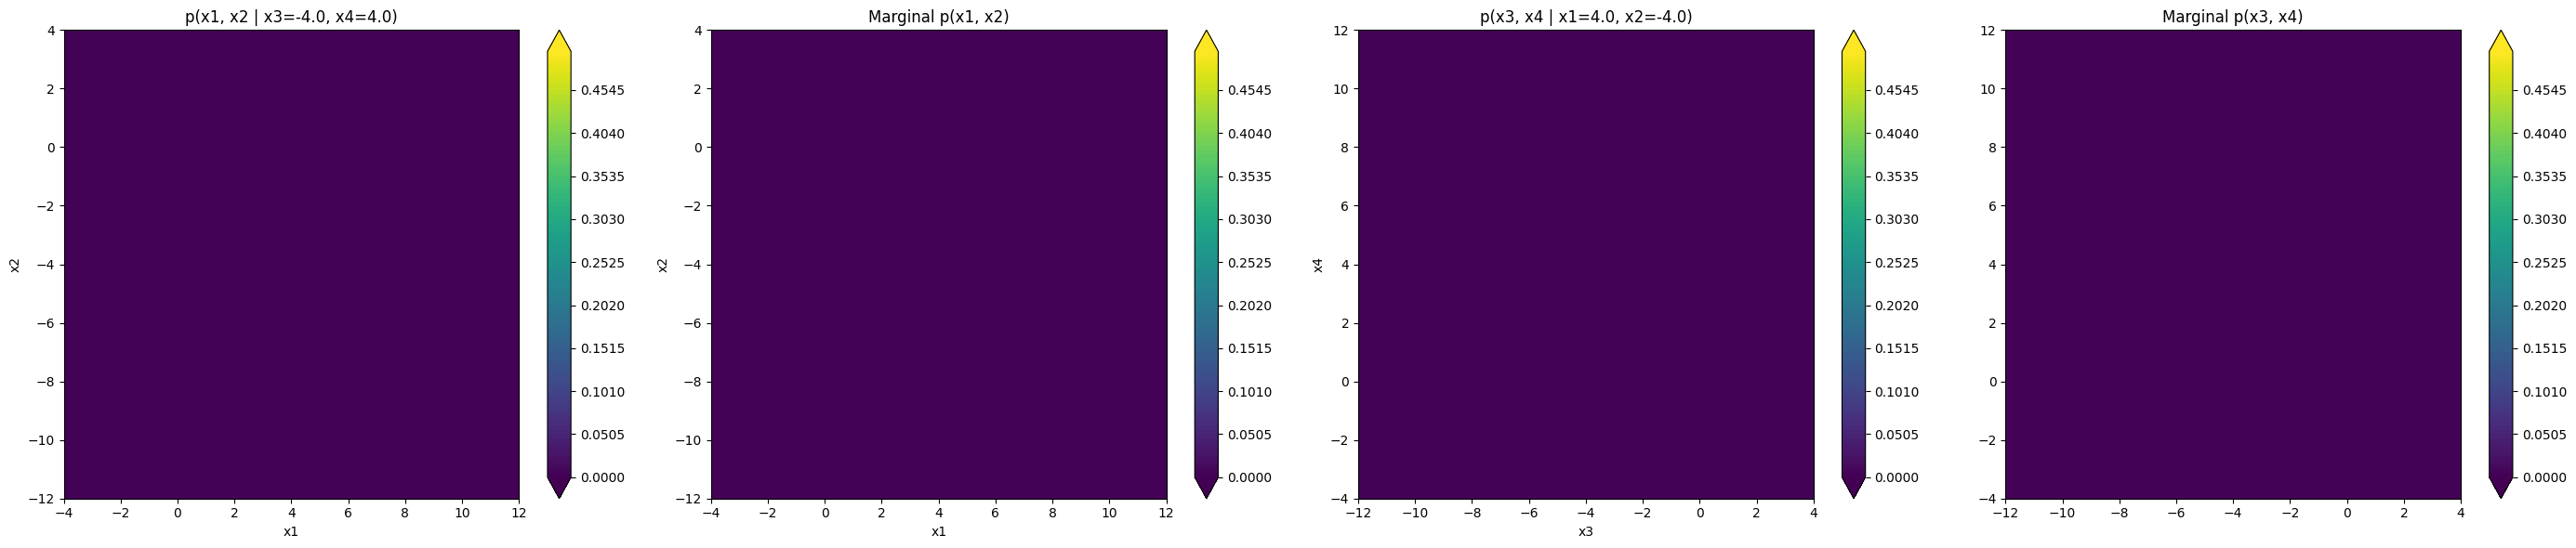

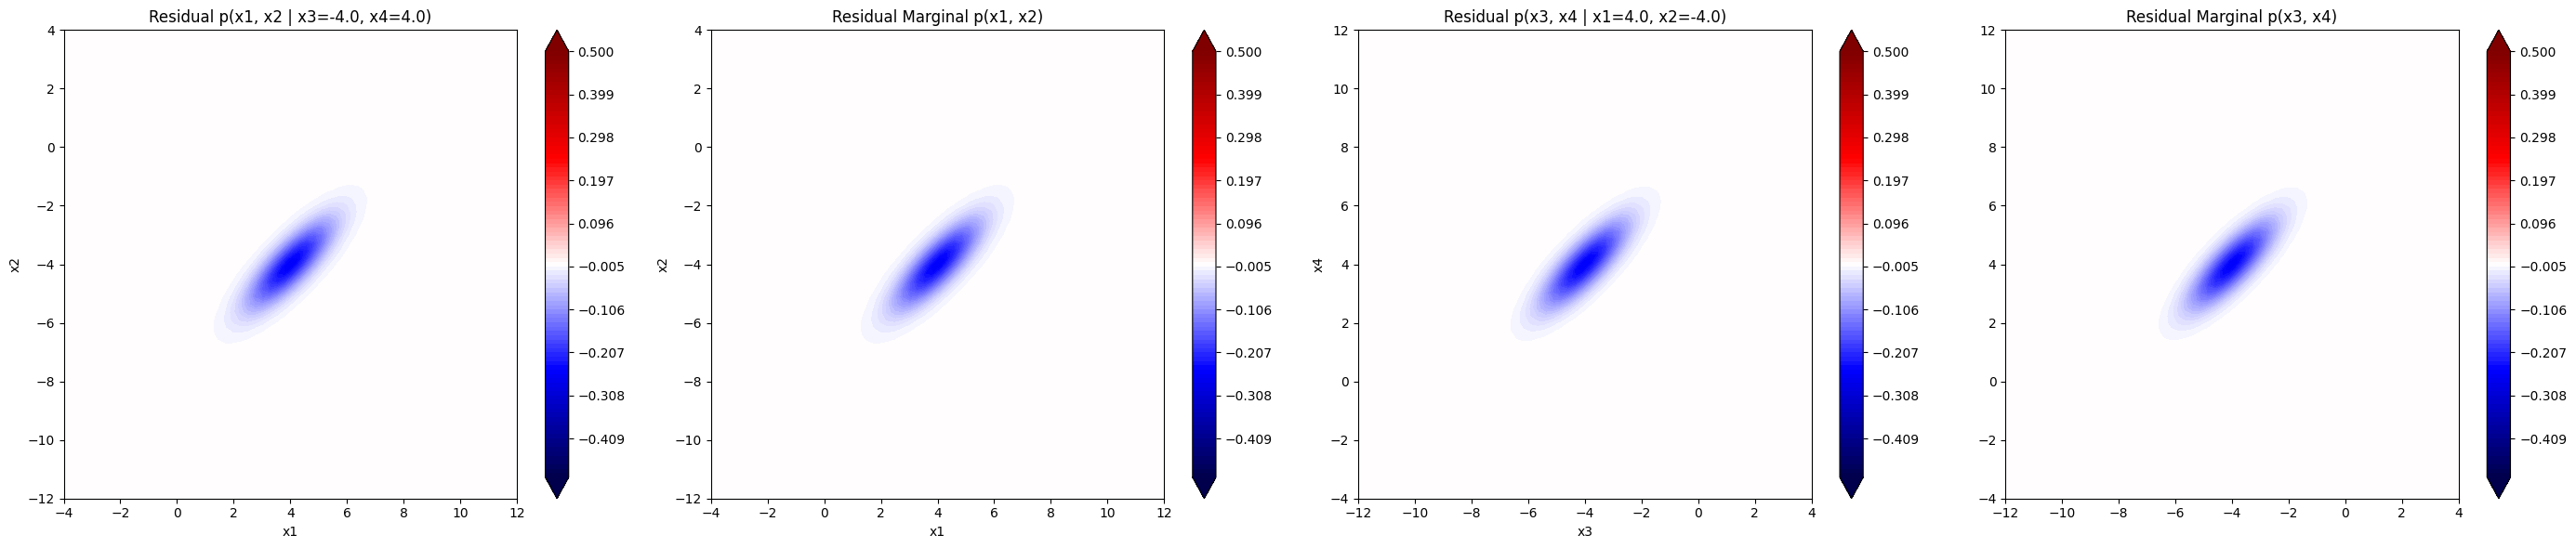

Complexity 6: Likelihood score: -281,531.7036140245
complexity 6 :: min predict conditional 12: 0.0014792899408284015, max predict conditional 12: 0.0014792899408284015
complexity 6 :: min predict marginal 12: 0.0014792899408284023, max predict marginal 12: 0.0014792899408284023
complexity 6 :: min predict conditional 34: 3.4593216591749113e-09, max predict conditional 34: 0.003130955738970879
complexity 6 :: min predict marginal 34: 4.238489774169893e-09, max predict marginal 34: 0.003836163615433143
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.0014792899408284015
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.003130955738970879
max marginal p(x1,x2) residual = 0.0014792899408284015
max marginal p(x3,x4) residual = 0.003130955738970879



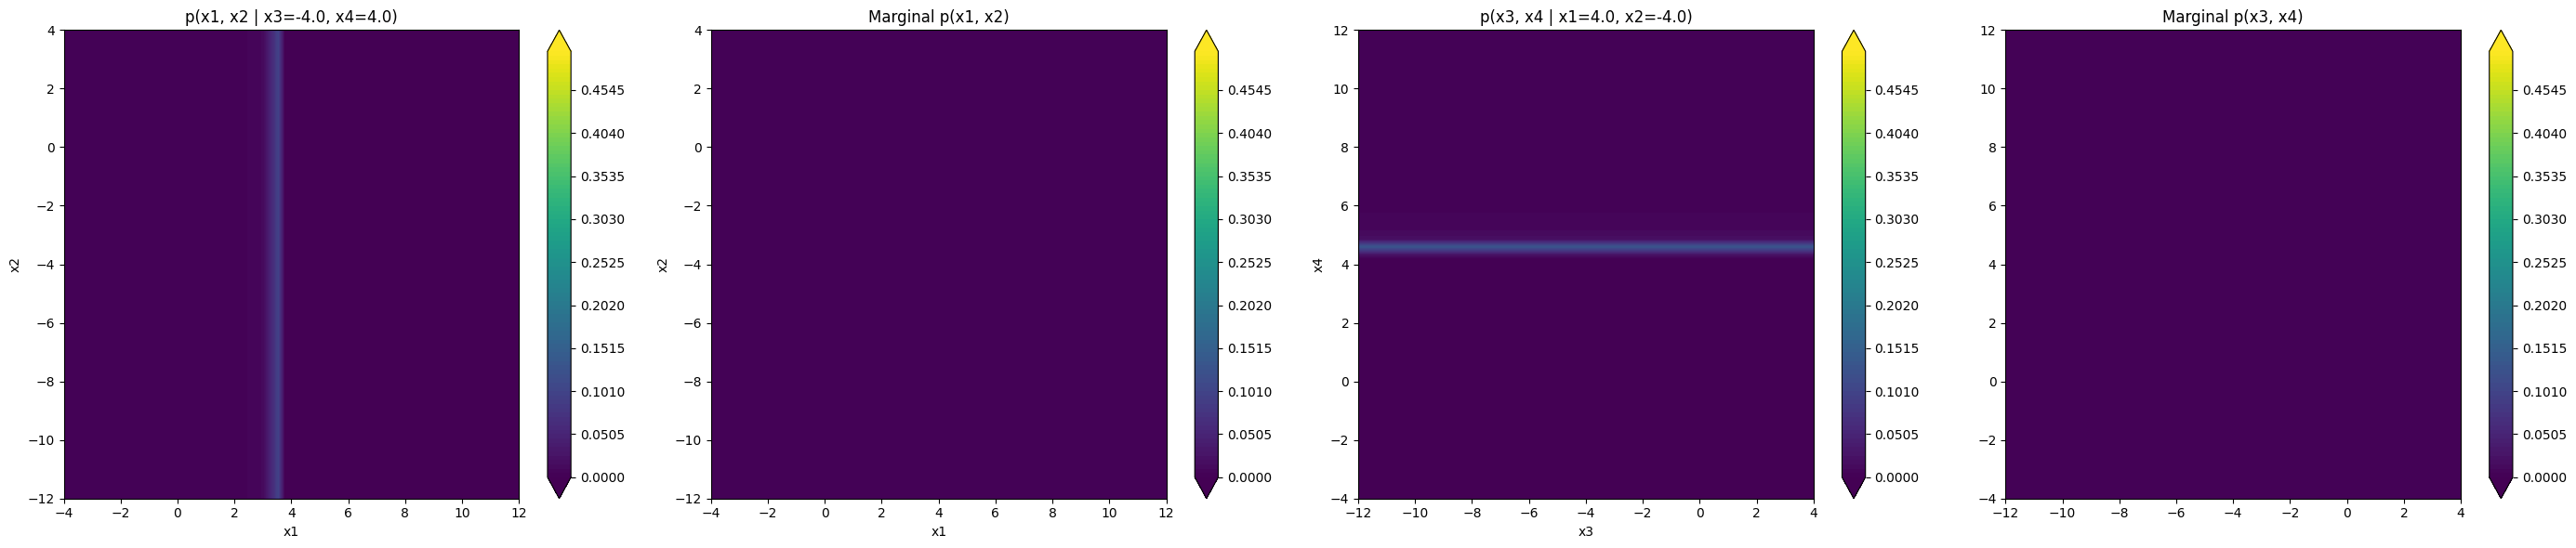

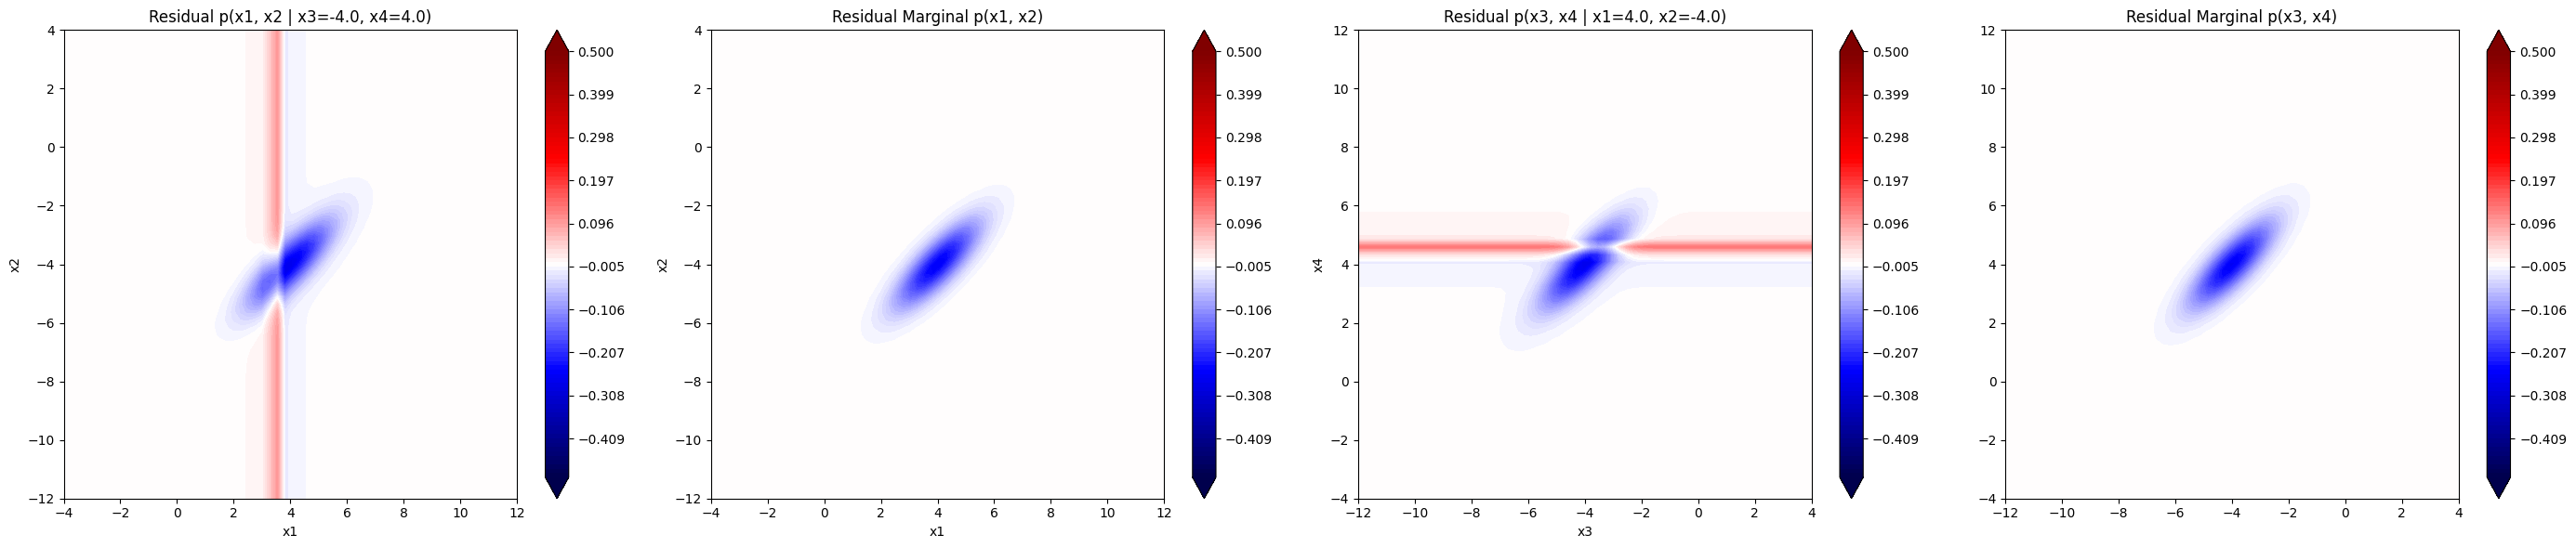

/tmp/ipykernel_2424218/1465819675.py:133: RuntimeWarning: invalid value encountered in log
  likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))


Complexity 7: Likelihood score: nan
complexity 7 :: min predict conditional 12: -0.019928812396868074, max predict conditional 12: 0.09940450404053906
complexity 7 :: min predict marginal 12: -0.0011165709494191708, max predict marginal 12: 0.0024659580109296186
complexity 7 :: min predict conditional 34: -0.017144831815073626, max predict conditional 34: 0.13378005634638743
complexity 7 :: min predict marginal 34: -0.00035016300579750366, max predict marginal 34: 0.0007733384696482811
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.09940450404053906
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.13378005634638743
max marginal p(x1,x2) residual = 0.09940450404053906
max marginal p(x3,x4) residual = 0.13378005634638743



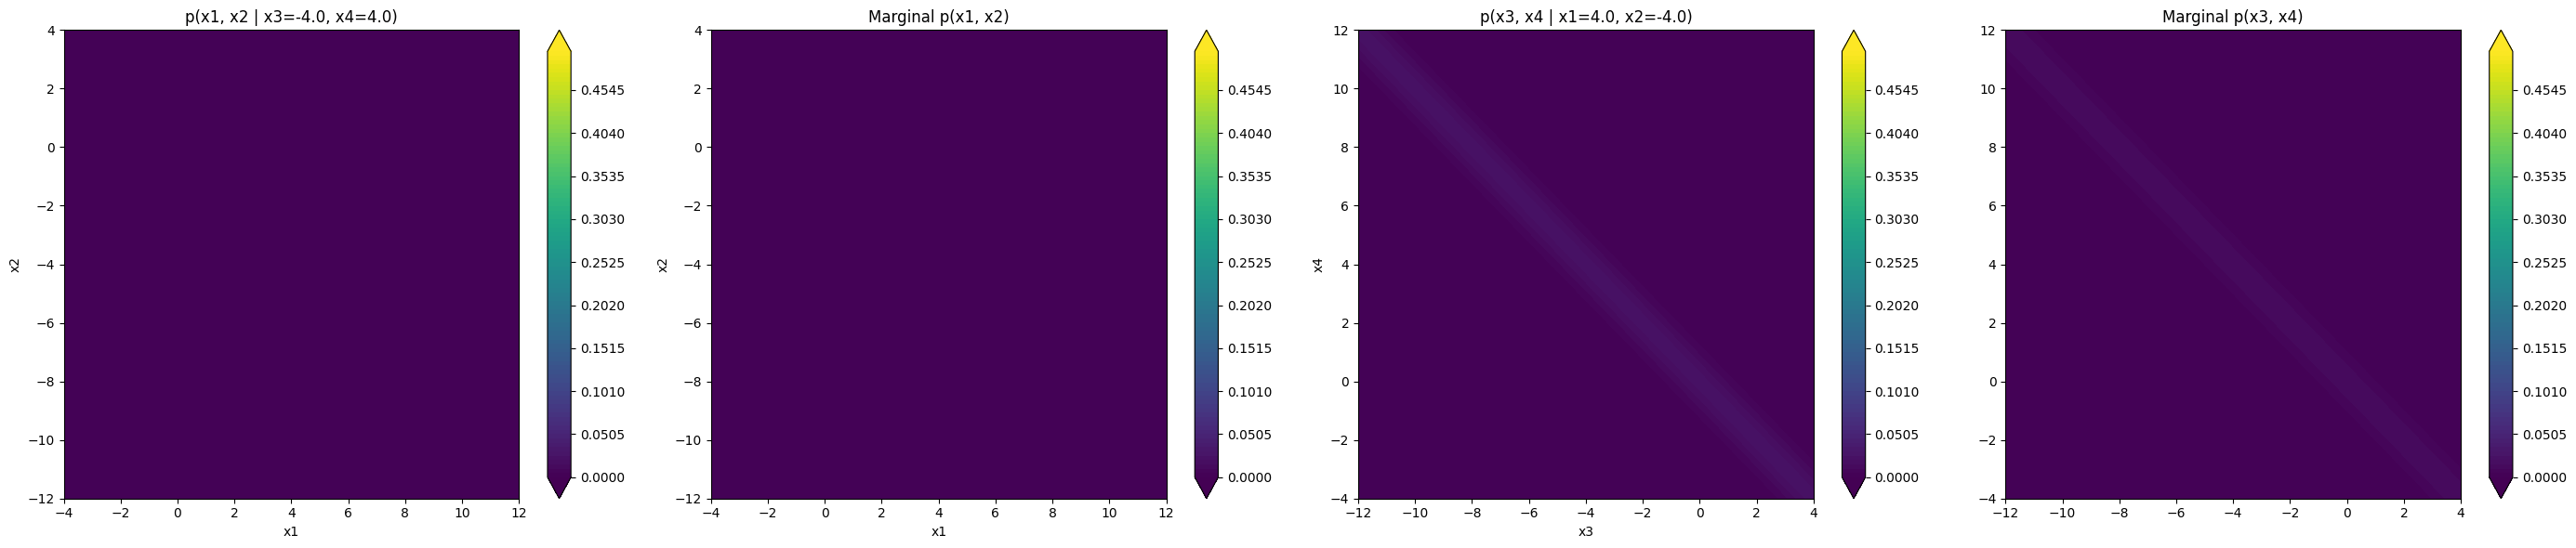

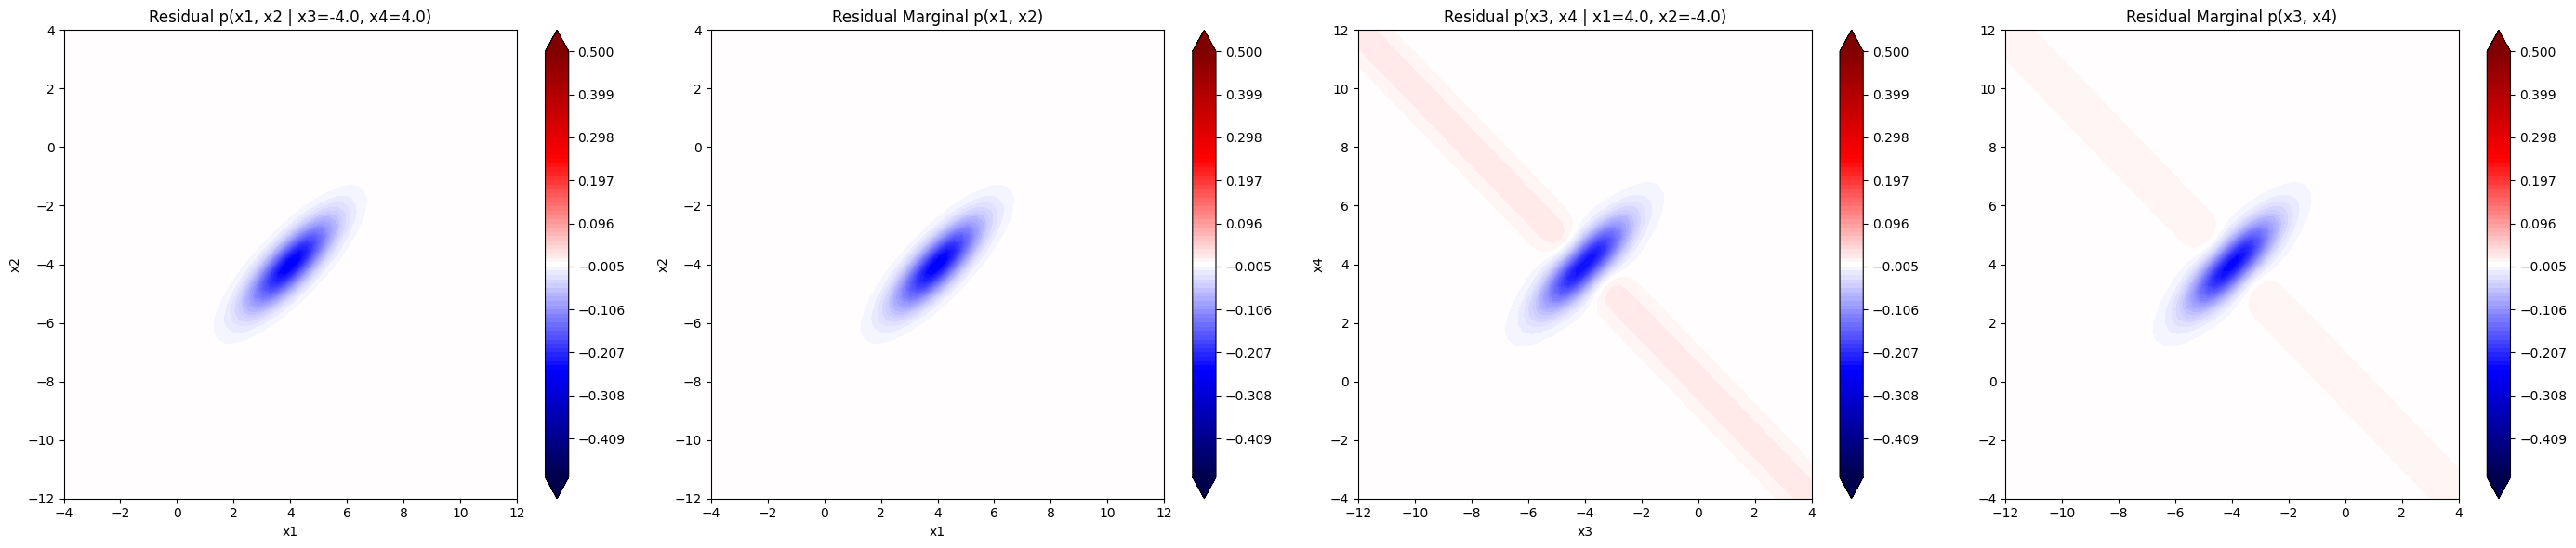

Complexity 8: Likelihood score: -337,157.0657526746
complexity 8 :: min predict conditional 12: 0.0014792899408284015, max predict conditional 12: 0.0014792899408284015
complexity 8 :: min predict marginal 12: 0.0014792899408284017, max predict marginal 12: 0.0014792899408284017
complexity 8 :: min predict conditional 34: 5.796027924540213e-296, max predict conditional 34: 0.02219219377069113
complexity 8 :: min predict marginal 34: 3.566238432590457e-296, max predict marginal 34: 0.013654636478448572
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.0014792899408284015
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.02219219377069113
max marginal p(x1,x2) residual = 0.0014792899408284015
max marginal p(x3,x4) residual = 0.02219219377069113



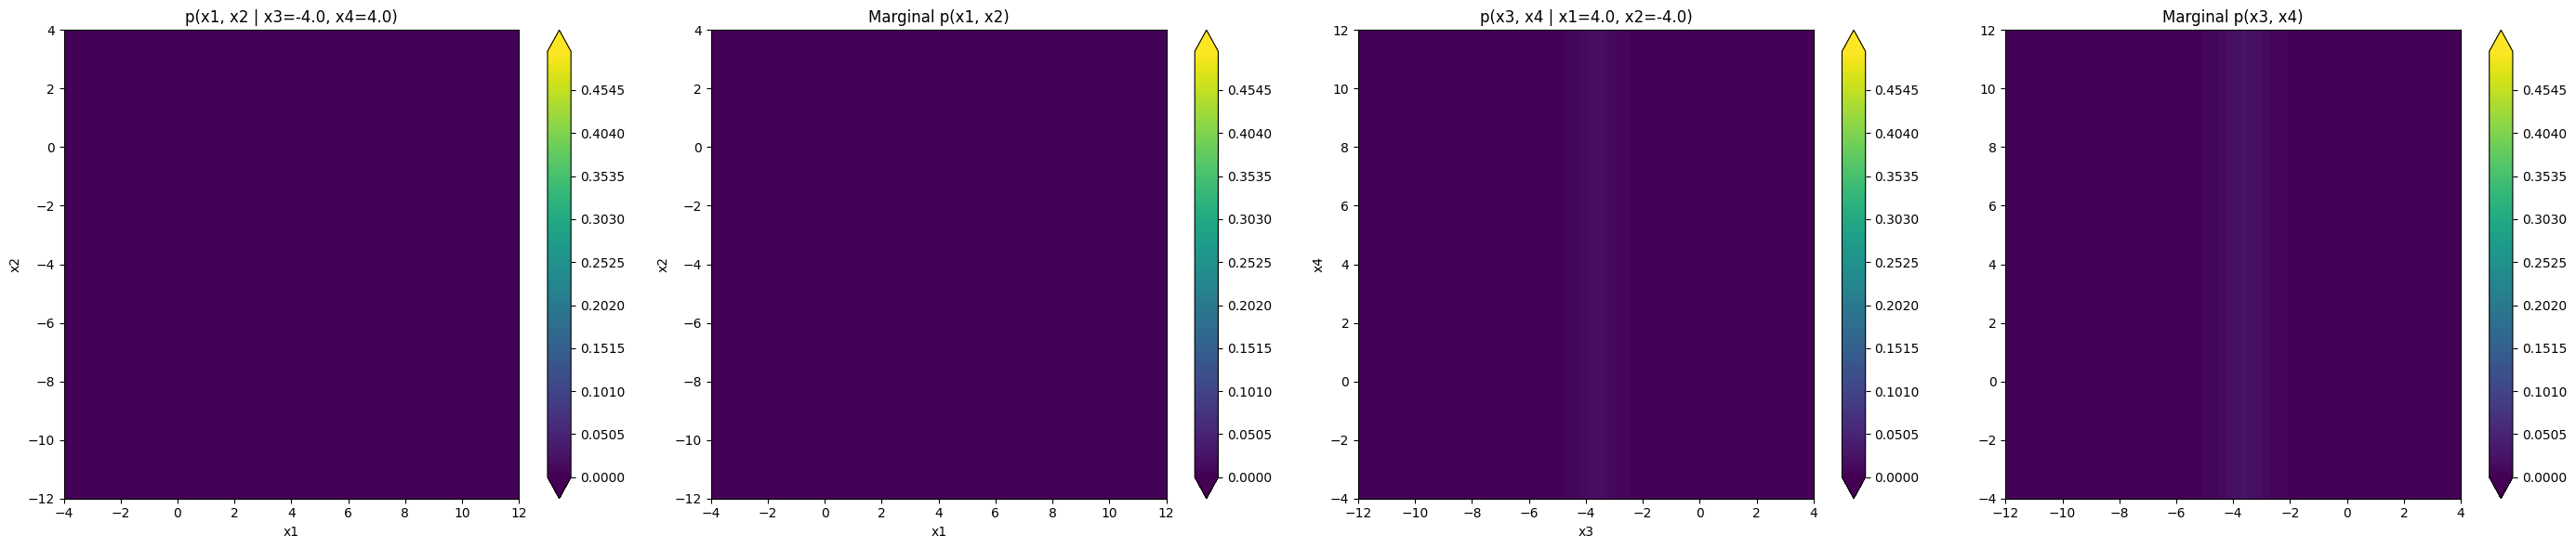

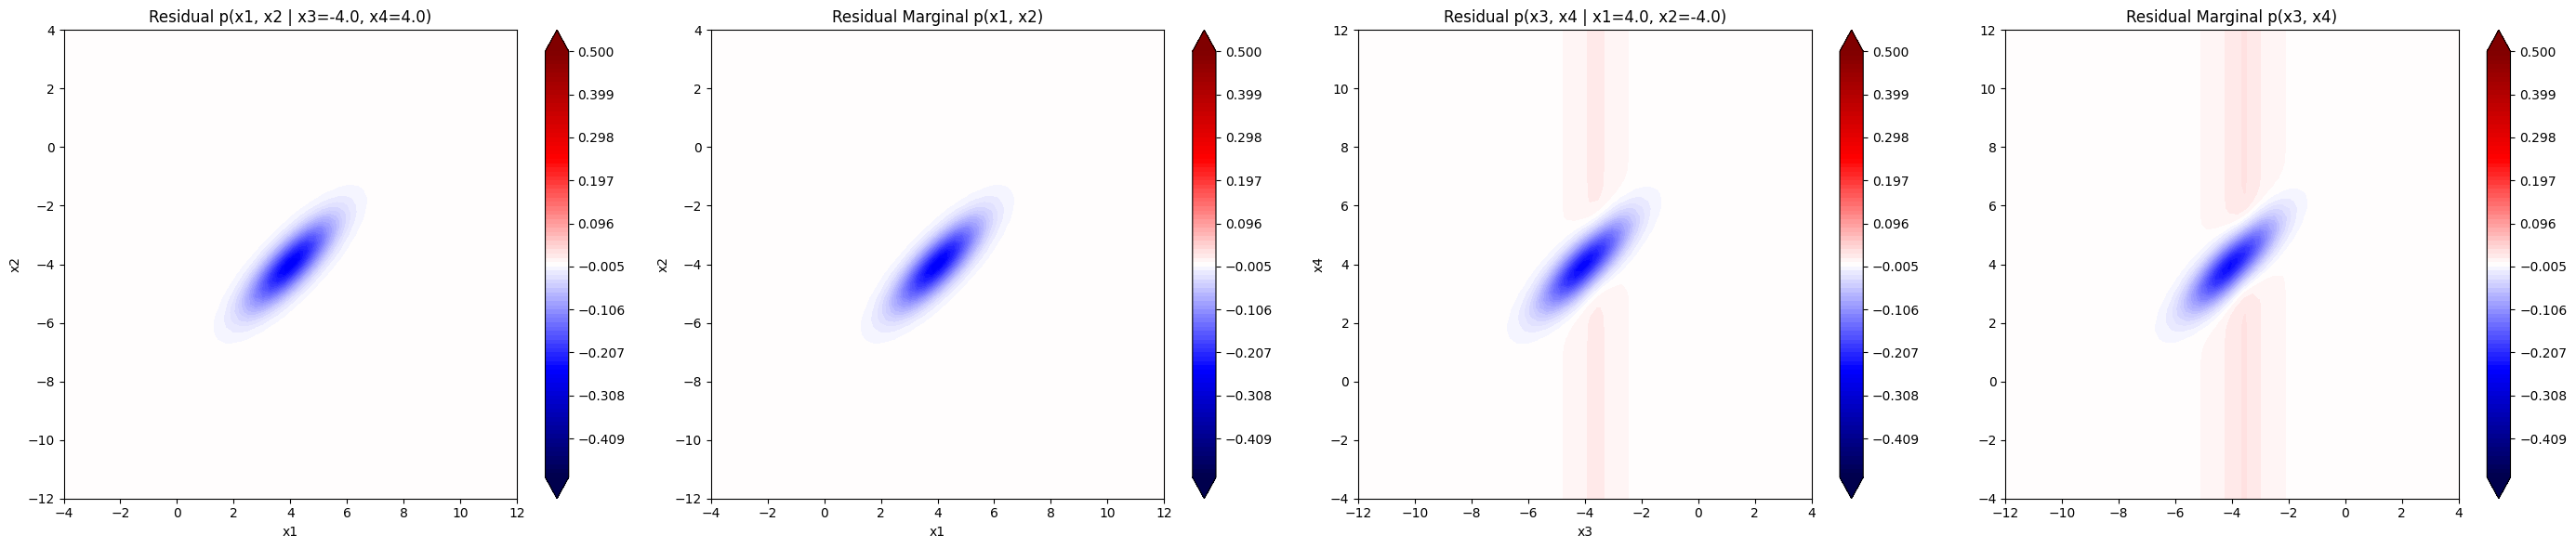

Complexity 10: Likelihood score: -253,496.04022850224
complexity 10 :: min predict conditional 12: 0.0014792899408284021, max predict conditional 12: 0.0014792899408284021
complexity 10 :: min predict marginal 12: 0.0014792899408284028, max predict marginal 12: 0.0014792899408284028
complexity 10 :: min predict conditional 34: 3.3231247050728e-05, max predict conditional 34: 0.017478646910850056
complexity 10 :: min predict marginal 34: 4.937862055762066e-05, max predict marginal 34: 0.025971684792749618
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.0014792899408284021
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.017478646910850056
max marginal p(x1,x2) residual = 0.0014792899408284021
max marginal p(x3,x4) residual = 0.017478646910850056

Marginal at (x3=-4.0, x4=4.0) is zero, too small, or non-finite: -1.063954090133706e-05. This usually means the slice is in the extreme tail (densities ~ 0) or numeric underflow.
Marginal at (x1=4.0, x2=-4.0) is zero, too small, or non-finite:

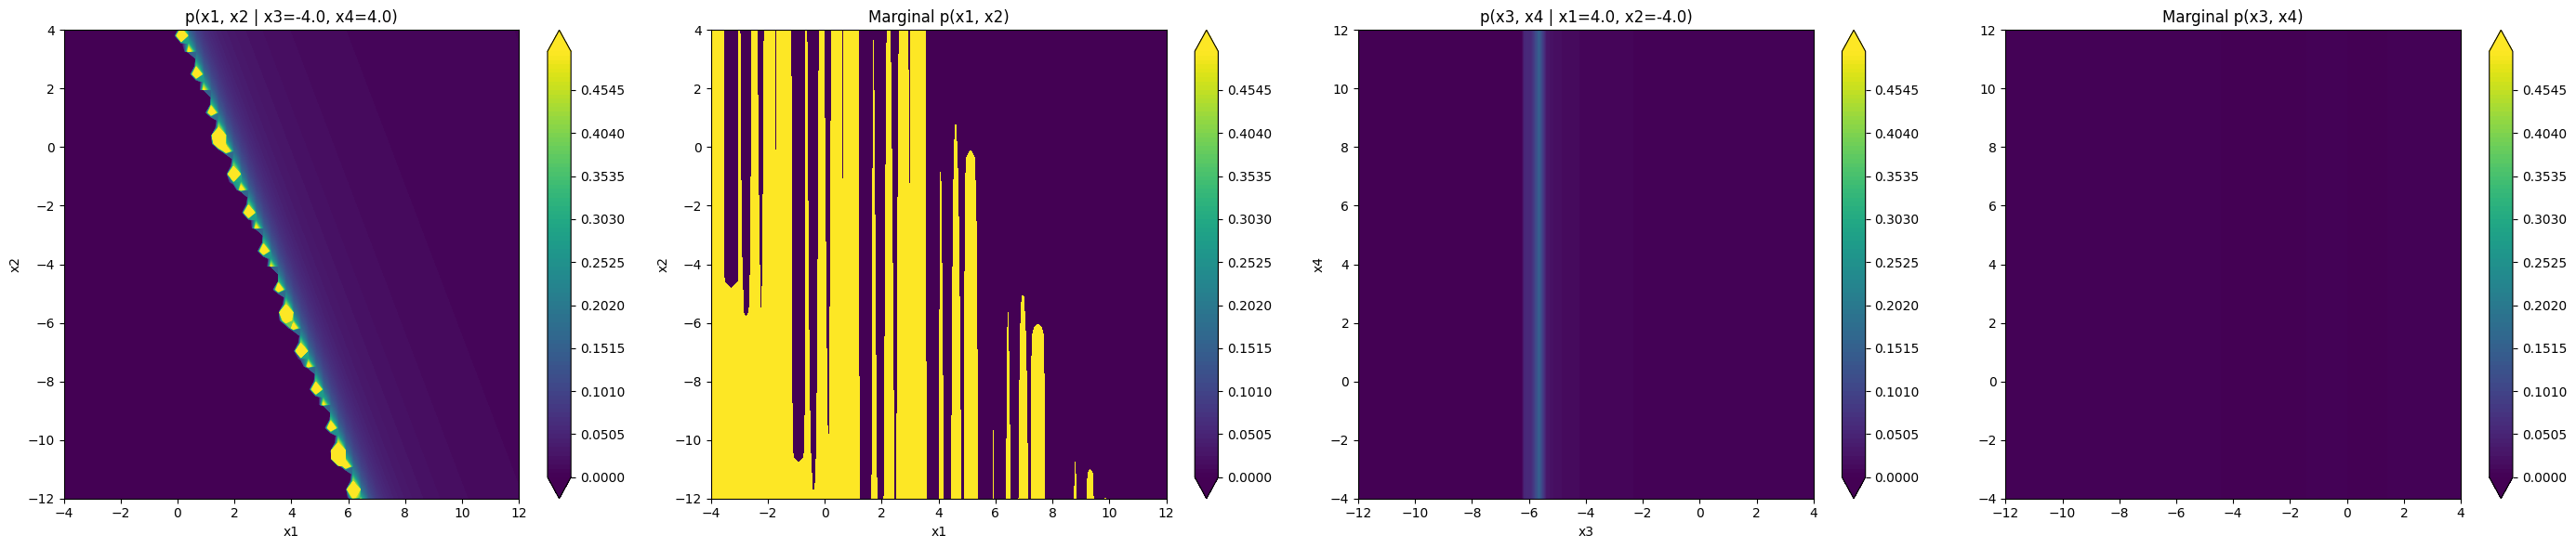

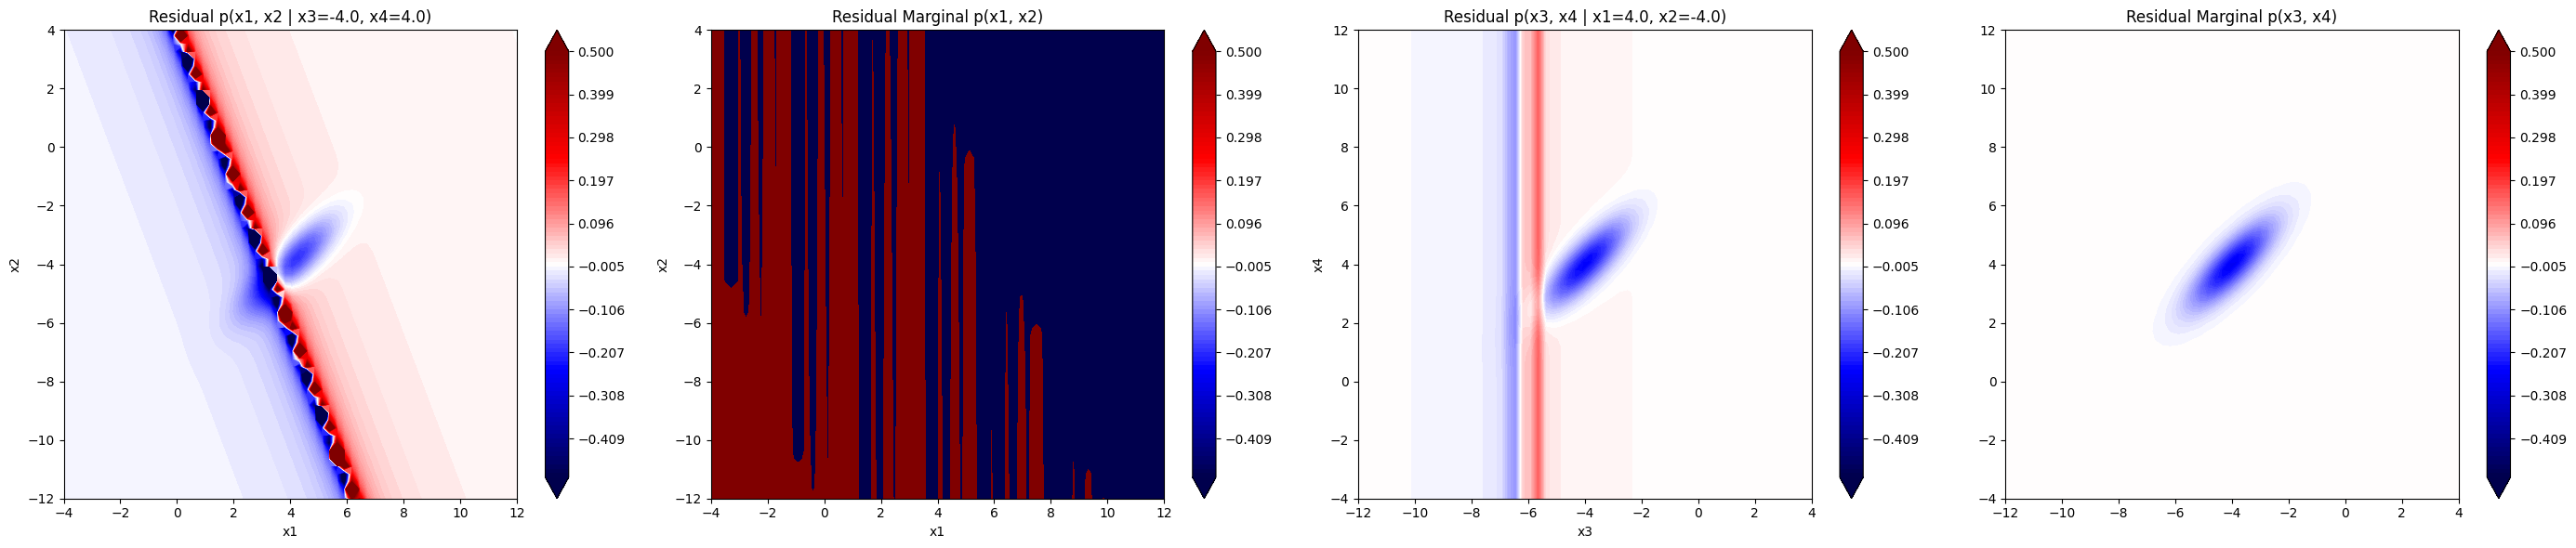

Complexity 11: Likelihood score: nan
complexity 11 :: min predict conditional 12: -65.89916473344631, max predict conditional 12: 66.21201667164179
complexity 11 :: min predict marginal 12: -36708952088.12399, max predict marginal 12: 36708952088.35477
complexity 11 :: min predict conditional 34: -0.10770699357155981, max predict conditional 34: 0.15436605603793455
complexity 11 :: min predict marginal 34: -4.166140868093761e-05, max predict marginal 34: 4.166140868117169e-05
max conditional p(x1,x2|x3=-4,x4=4) residual = 66.21201667164179
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.15436605603793455
max marginal p(x1,x2) residual = 66.21201667164179
max marginal p(x3,x4) residual = 0.15436605603793455

Marginal at (x3=-4.0, x4=4.0) is zero, too small, or non-finite: -2.1279081802674817e-05. This usually means the slice is in the extreme tail (densities ~ 0) or numeric underflow.
Marginal at (x1=4.0, x2=-4.0) is zero, too small, or non-finite: -0.00016552182224872217. This usually

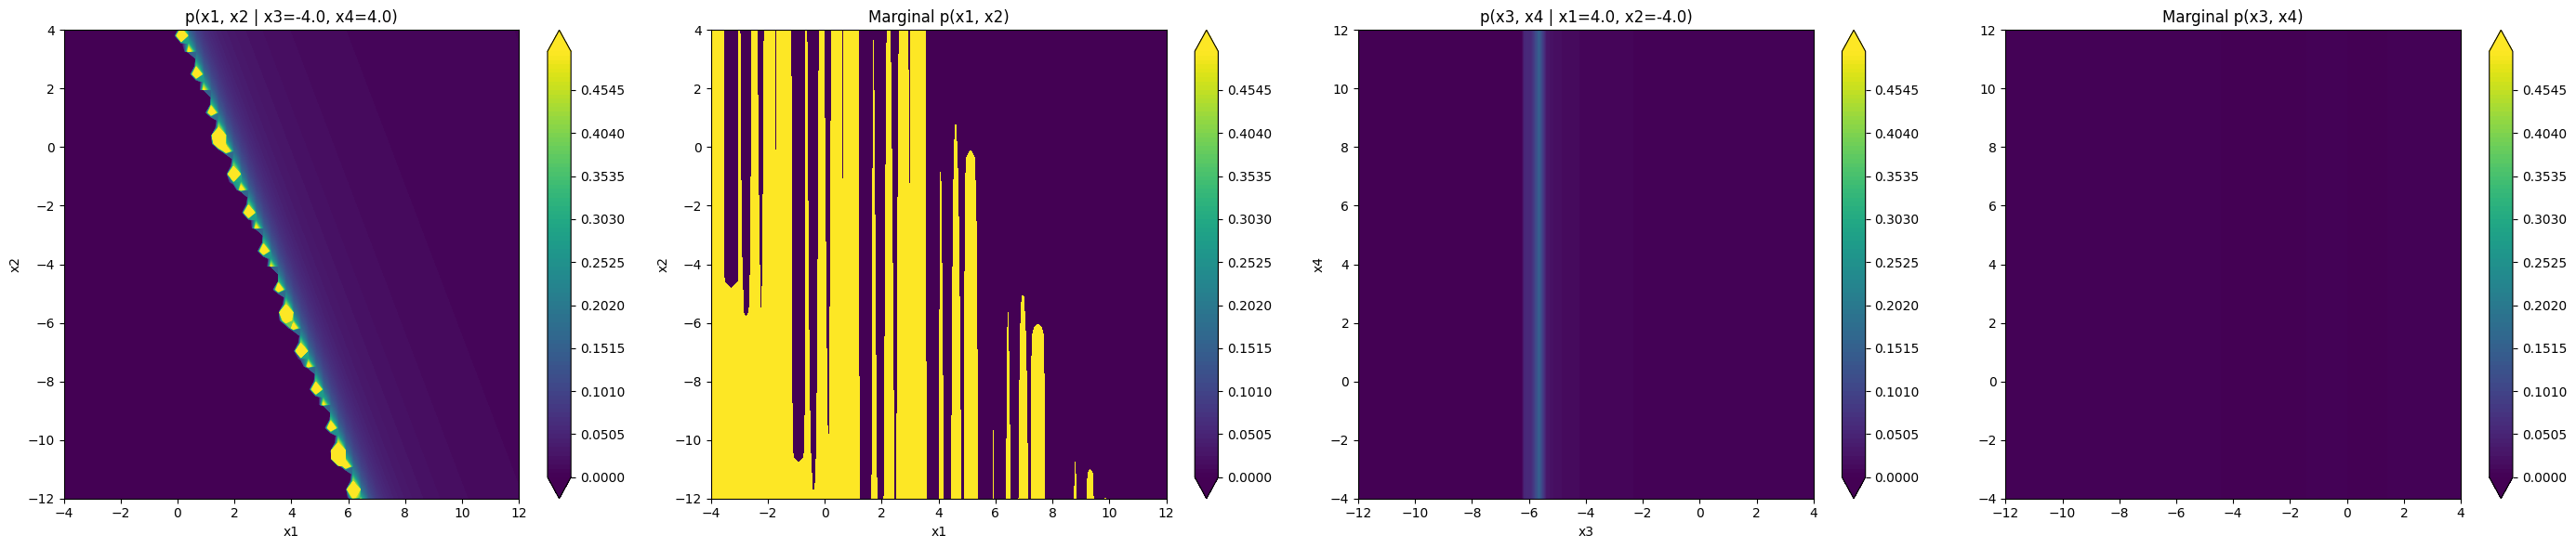

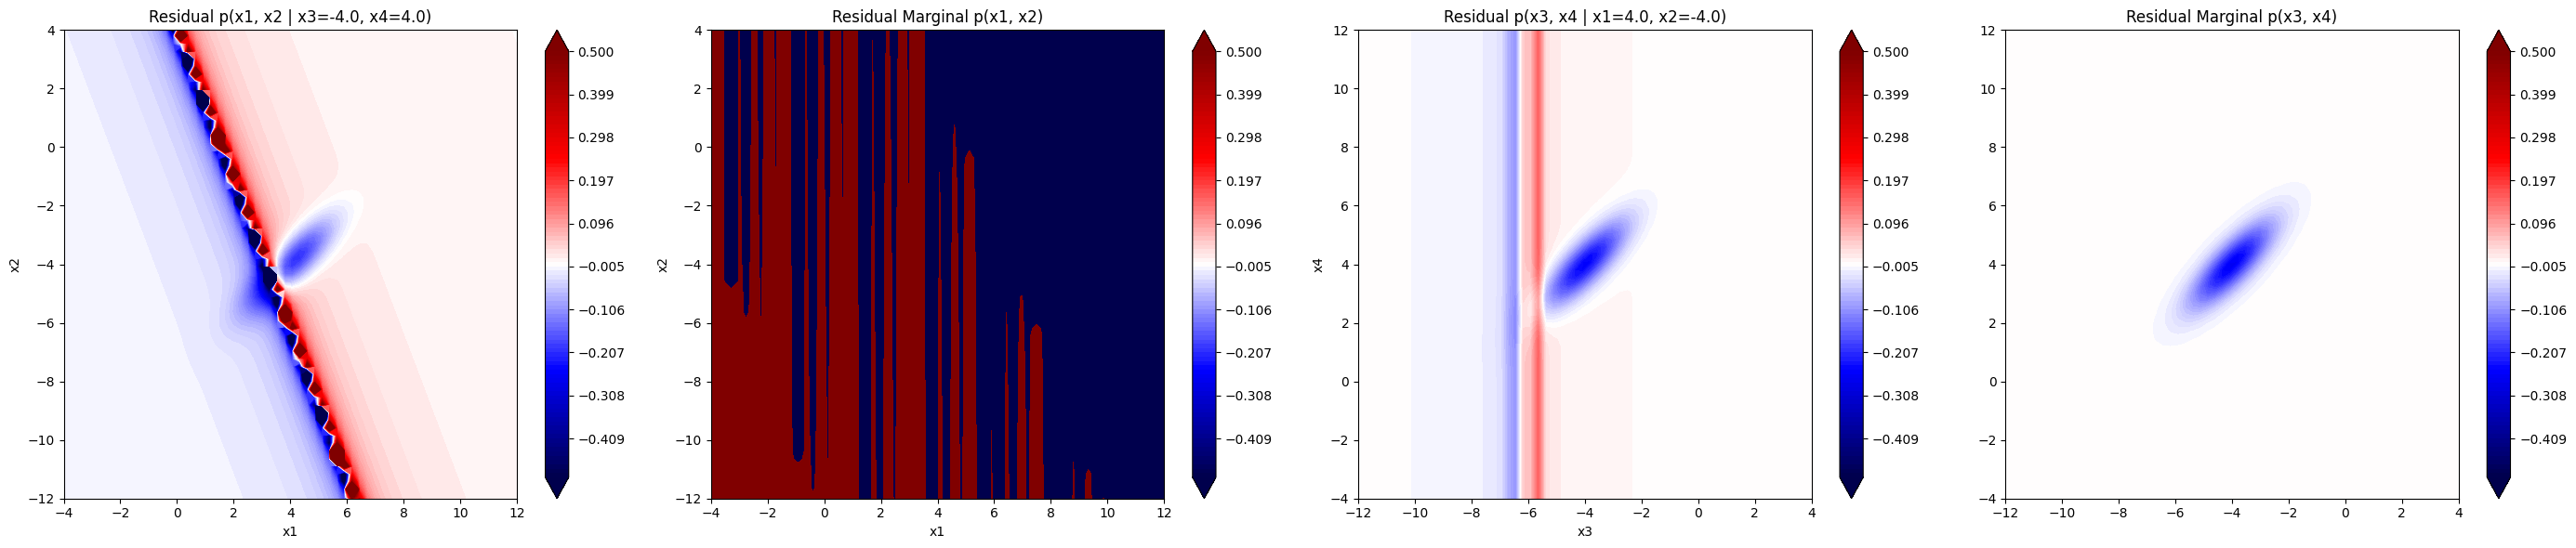

Complexity 12: Likelihood score: nan
complexity 12 :: min predict conditional 12: -65.89916473344363, max predict conditional 12: 66.21201667163908
complexity 12 :: min predict marginal 12: -37268451451.42905, max predict marginal 12: 37268451451.6633
complexity 12 :: min predict conditional 34: -0.1077069935715582, max predict conditional 34: 0.15436605603793385
complexity 12 :: min predict marginal 34: -8.33228173618738e-05, max predict marginal 34: 8.33228173623421e-05
max conditional p(x1,x2|x3=-4,x4=4) residual = 66.21201667163908
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.15436605603793385
max marginal p(x1,x2) residual = 66.21201667163908
max marginal p(x3,x4) residual = 0.15436605603793385

Marginal at (x3=-4.0, x4=4.0) is zero, too small, or non-finite: -2.4637153271782237e-05. This usually means the slice is in the extreme tail (densities ~ 0) or numeric underflow.
Marginal at (x1=4.0, x2=-4.0) is zero, too small, or non-finite: -0.00019164297324397966. This usually mea

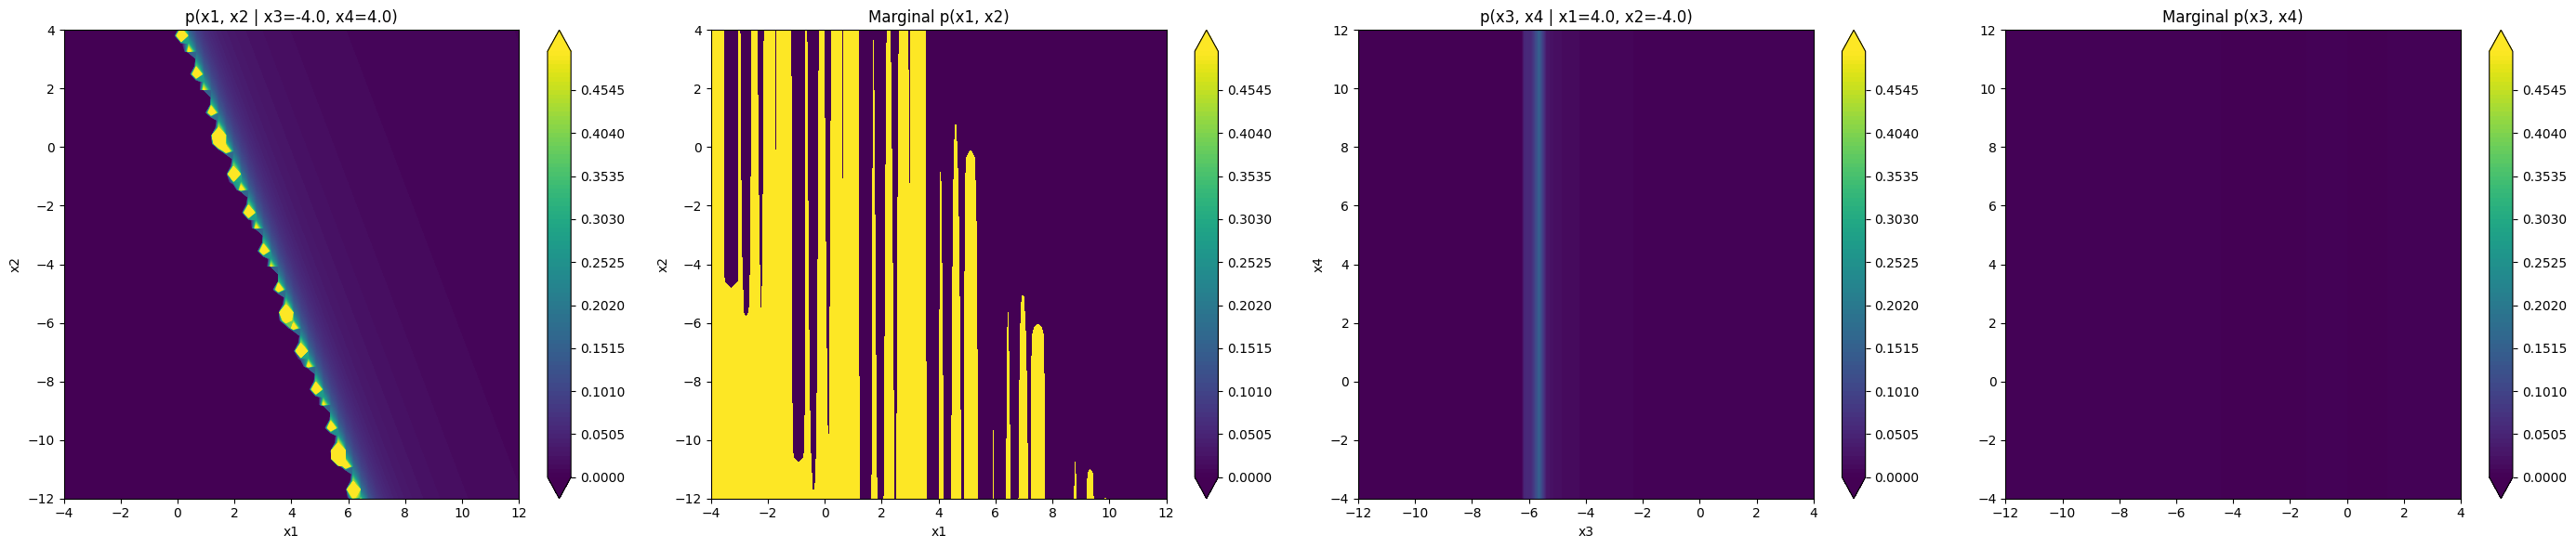

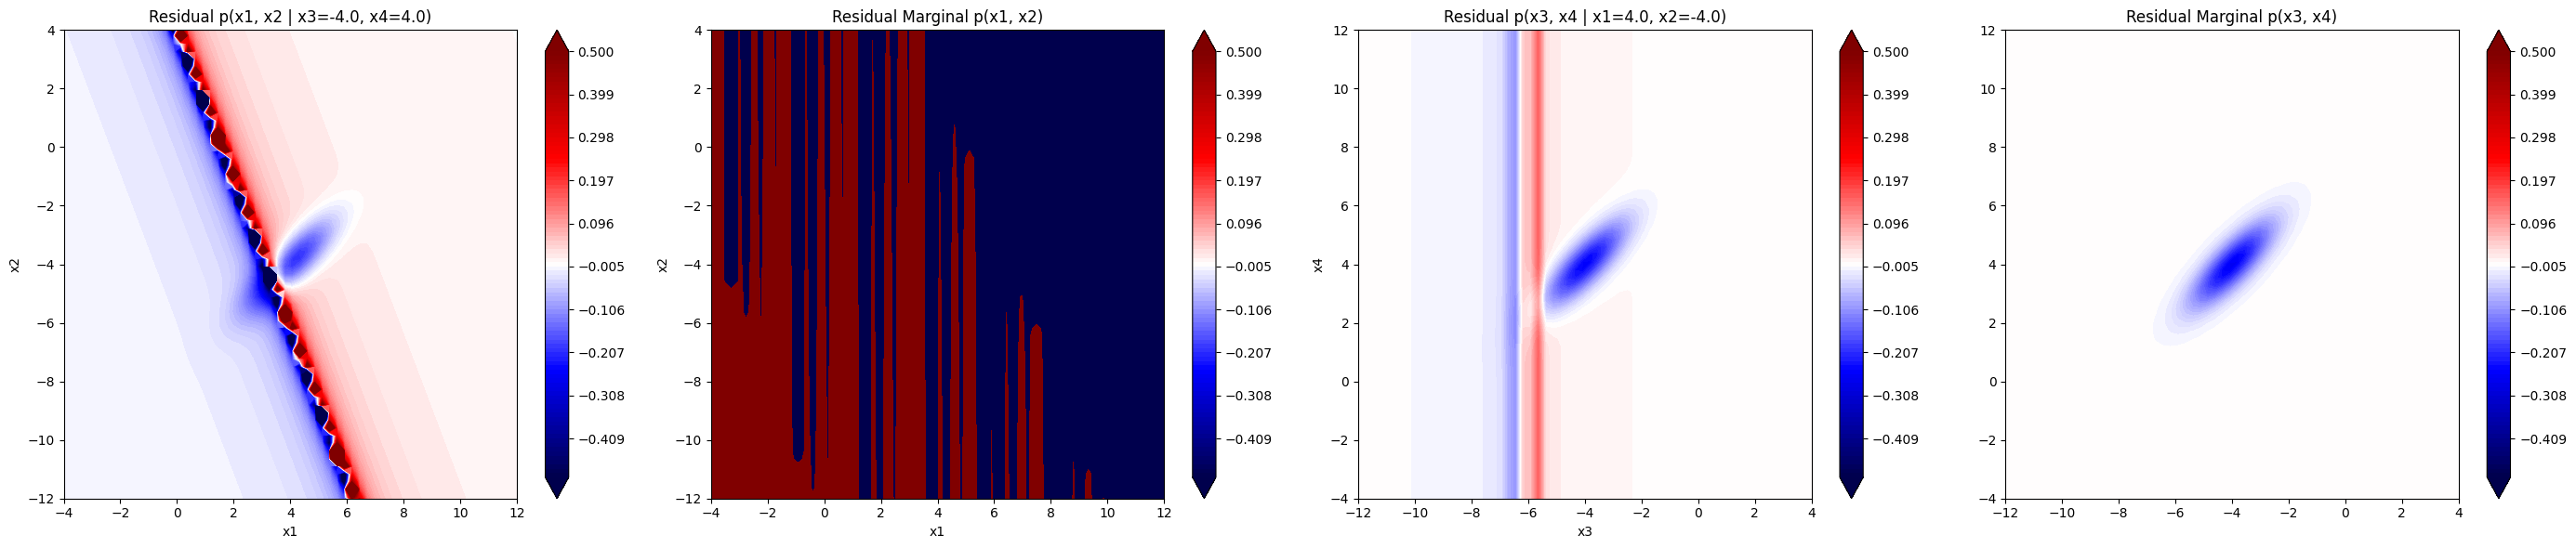

Complexity 13: Likelihood score: nan
complexity 13 :: min predict conditional 12: -65.8991647334436, max predict conditional 12: 66.21201667163906
complexity 13 :: min predict marginal 12: -37269766980.08804, max predict marginal 12: 37269766980.32233
complexity 13 :: min predict conditional 34: -0.10770699357155816, max predict conditional 34: 0.15436605603793374
complexity 13 :: min predict marginal 34: -9.64720677996152e-05, max predict marginal 34: 9.647206780015744e-05
max conditional p(x1,x2|x3=-4,x4=4) residual = 66.21201667163906
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.15436605603793374
max marginal p(x1,x2) residual = 66.21201667163906
max marginal p(x3,x4) residual = 0.15436605603793374

Marginal at (x3=-4.0, x4=4.0) is zero, too small, or non-finite: -4.9274306543564176e-05. This usually means the slice is in the extreme tail (densities ~ 0) or numeric underflow.
Marginal at (x1=4.0, x2=-4.0) is zero, too small, or non-finite: -0.0003832859464879564. This usually me

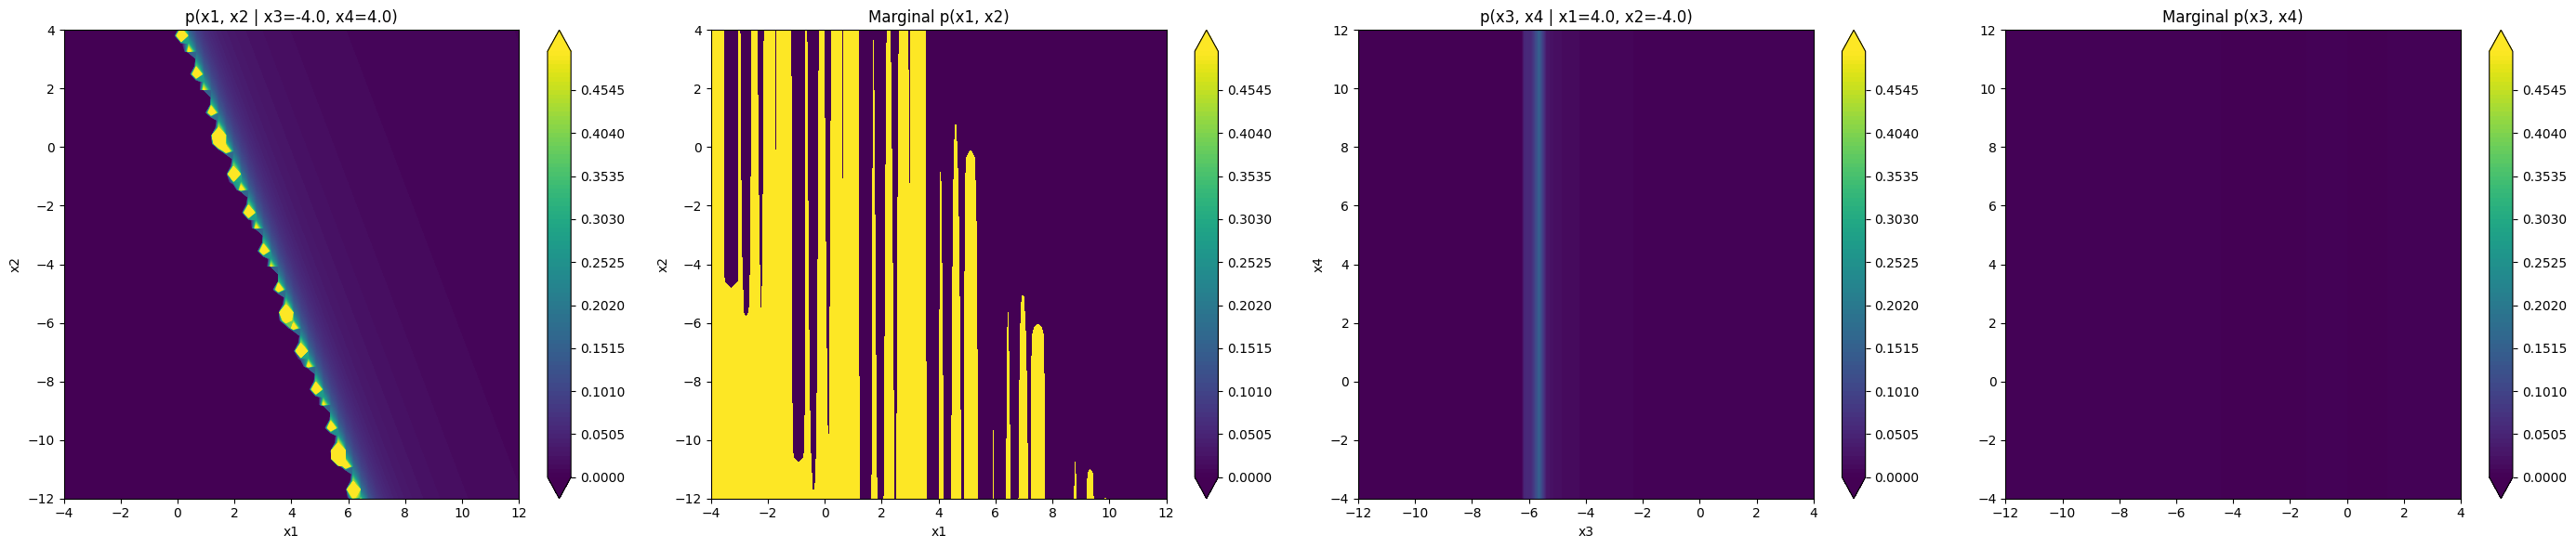

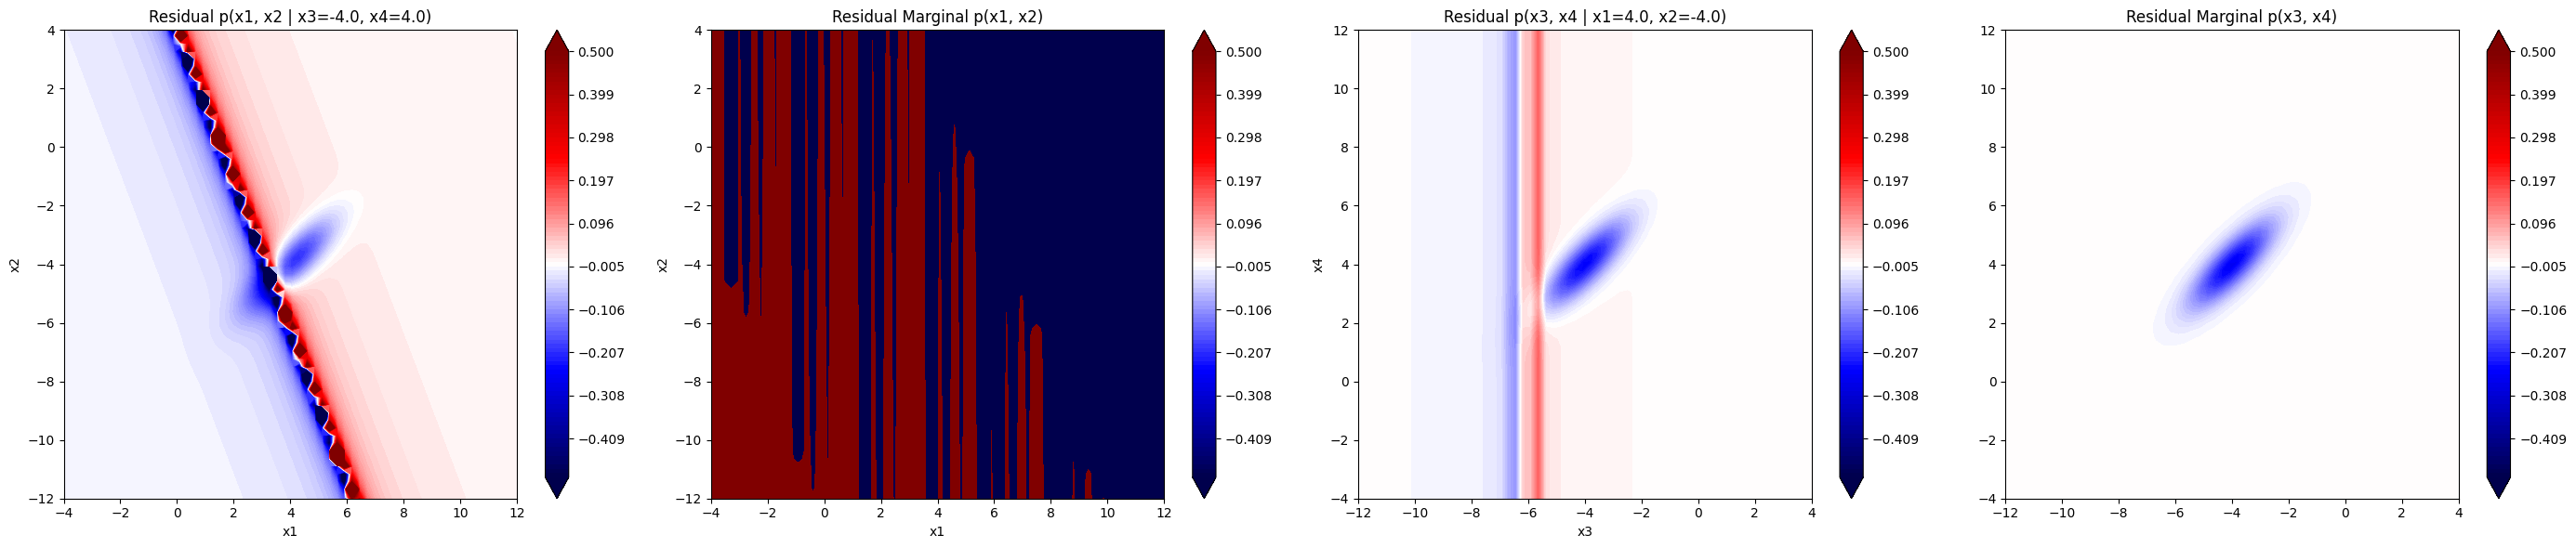

Complexity 14: Likelihood score: nan
complexity 14 :: min predict conditional 12: -65.89916473344347, max predict conditional 12: 66.21201667163893
complexity 14 :: min predict marginal 12: -37269500817.952774, max predict marginal 12: 37269500818.18704
complexity 14 :: min predict conditional 34: -0.10770699357155811, max predict conditional 34: 0.15436605603793377
complexity 14 :: min predict marginal 34: -0.00019294413559922883, max predict marginal 34: 0.00019294413560031344
max conditional p(x1,x2|x3=-4,x4=4) residual = 66.21201667163893
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.15436605603793377
max marginal p(x1,x2) residual = 66.21201667163893
max marginal p(x3,x4) residual = 0.15436605603793377

Marginal at (x3=-4.0, x4=4.0) is zero, too small, or non-finite: -4.1343754338226344e-05. This usually means the slice is in the extreme tail (densities ~ 0) or numeric underflow.
Marginal at (x1=4.0, x2=-4.0) is zero, too small, or non-finite: -0.0003215972202243488. This usual

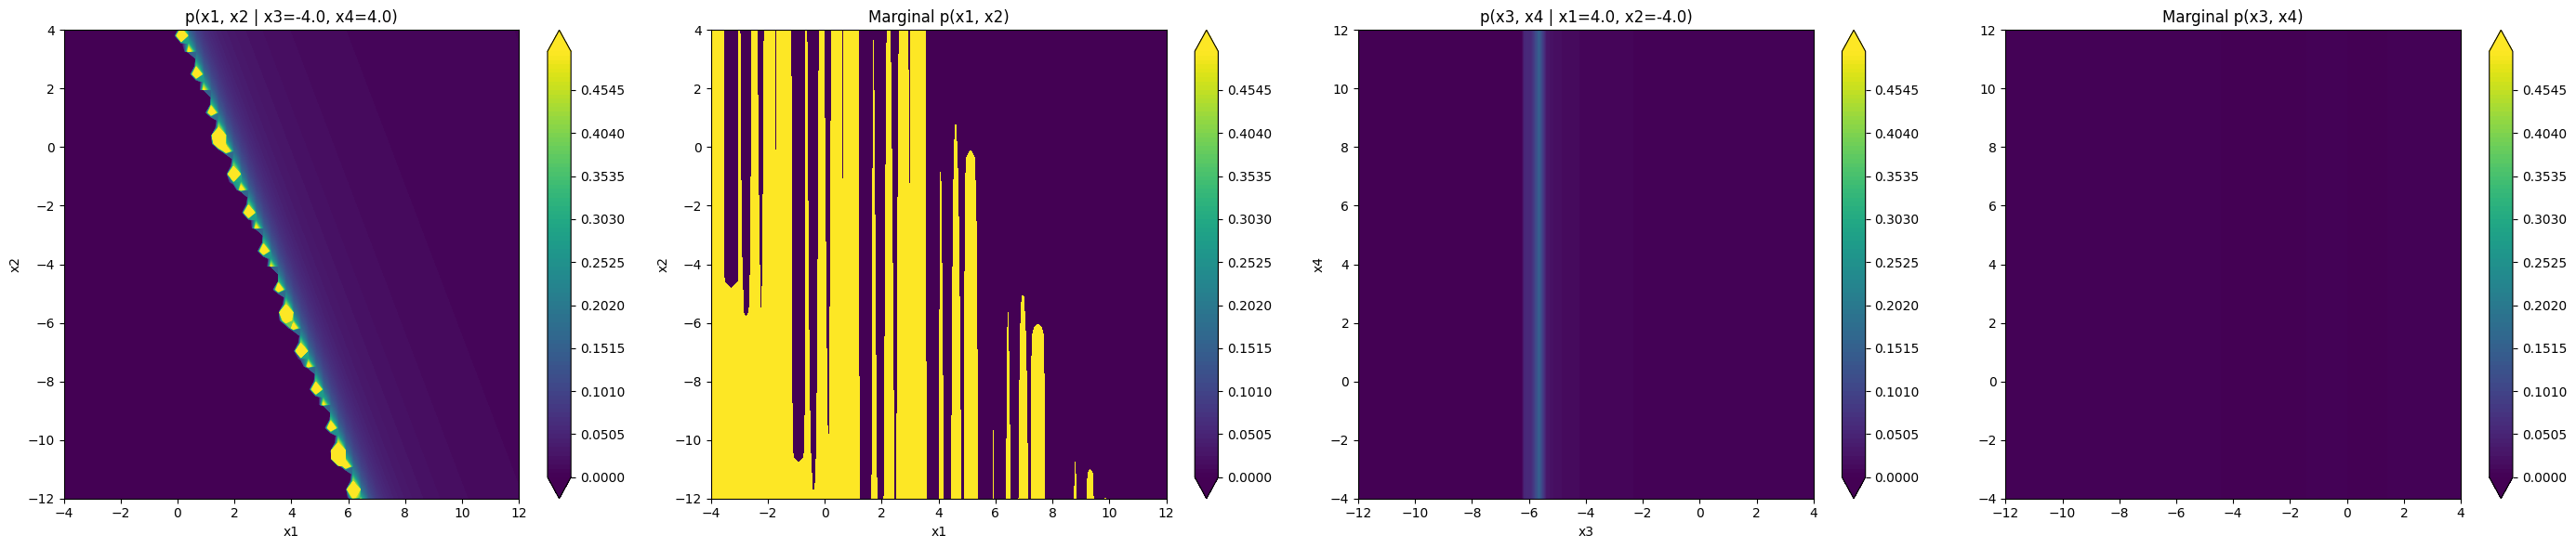

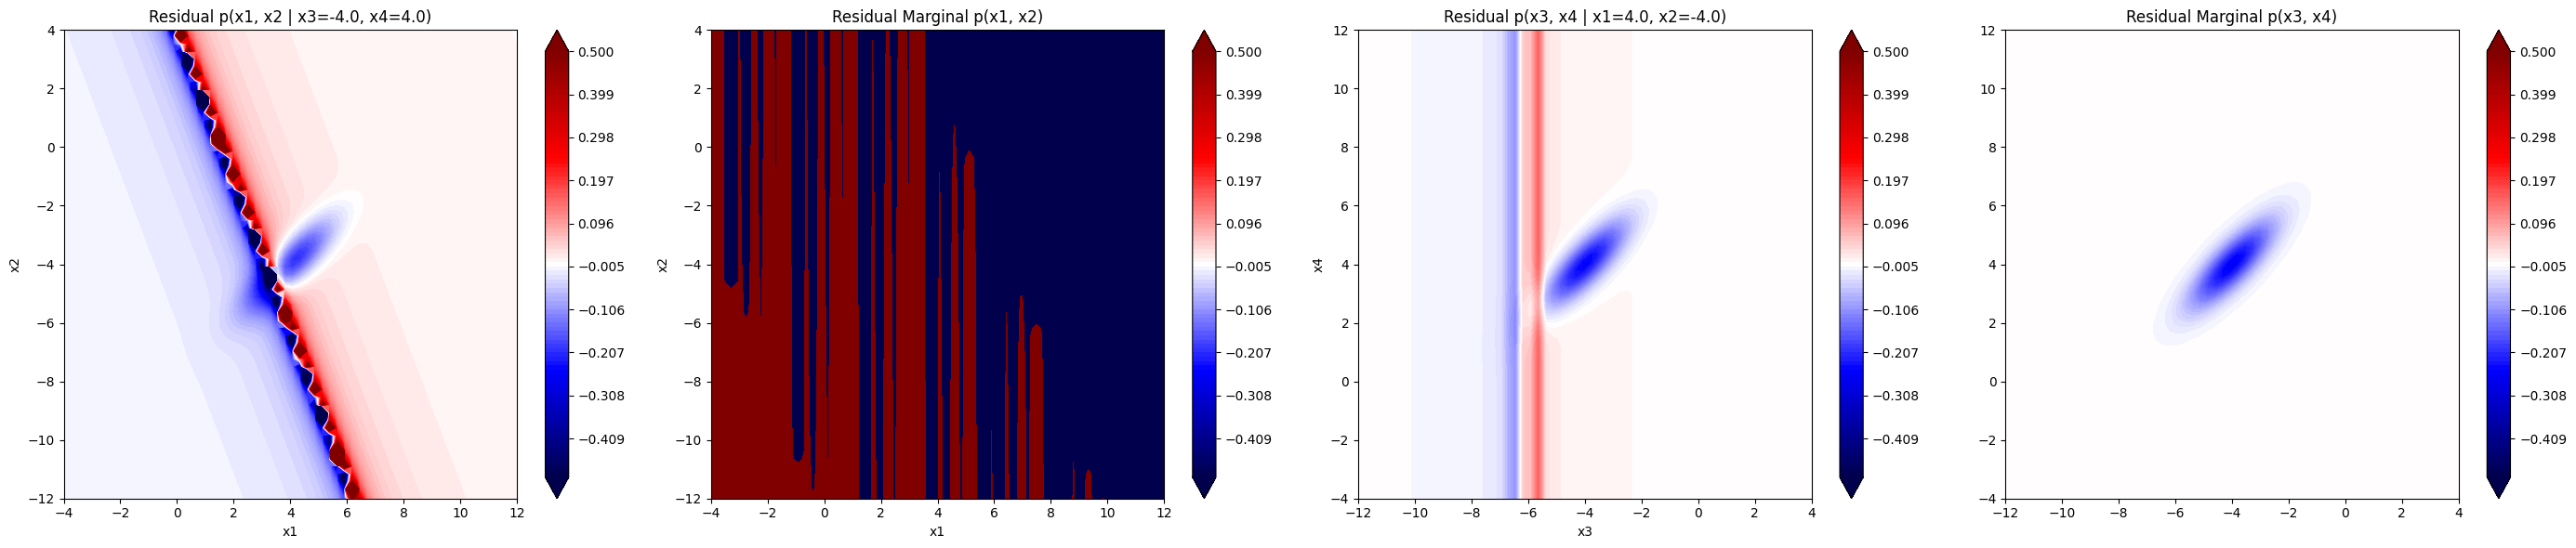

Complexity 15: Likelihood score: nan
complexity 15 :: min predict conditional 12: -65.89916473344375, max predict conditional 12: 66.21201667163922
complexity 15 :: min predict marginal 12: -37271767411.1471, max predict marginal 12: 37271767411.381386
complexity 15 :: min predict conditional 34: -0.10770699357155829, max predict conditional 34: 0.15436605603793396
complexity 15 :: min predict marginal 34: -0.00016189035427953438, max predict marginal 34: 0.00016189035428044437
max conditional p(x1,x2|x3=-4,x4=4) residual = 66.21201667163922
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.15436605603793396
max marginal p(x1,x2) residual = 66.21201667163922
max marginal p(x3,x4) residual = 0.15436605603793396



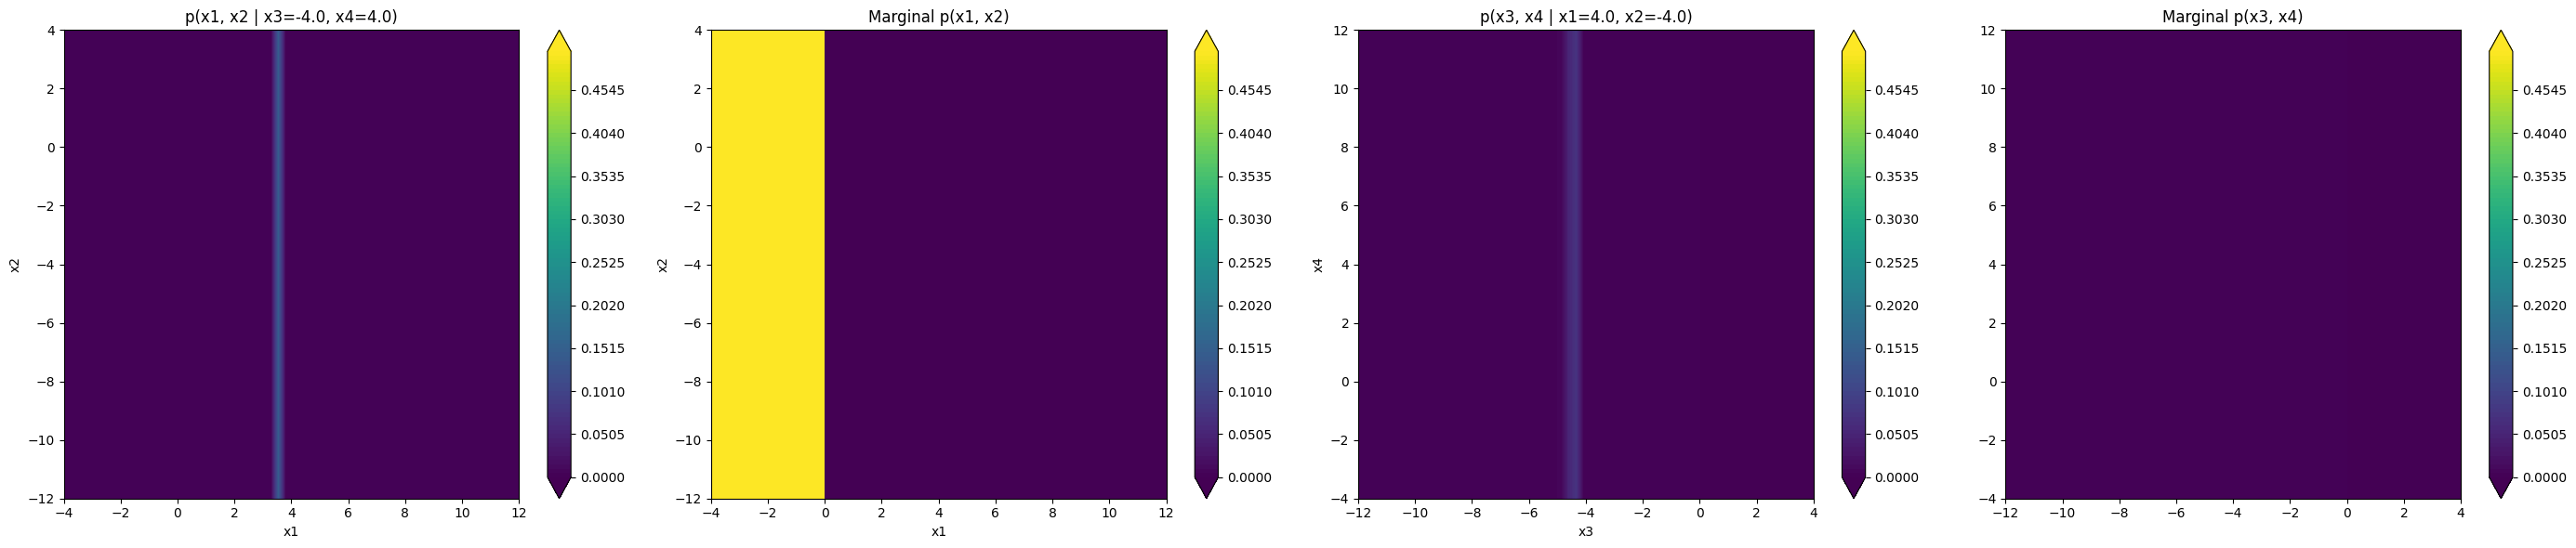

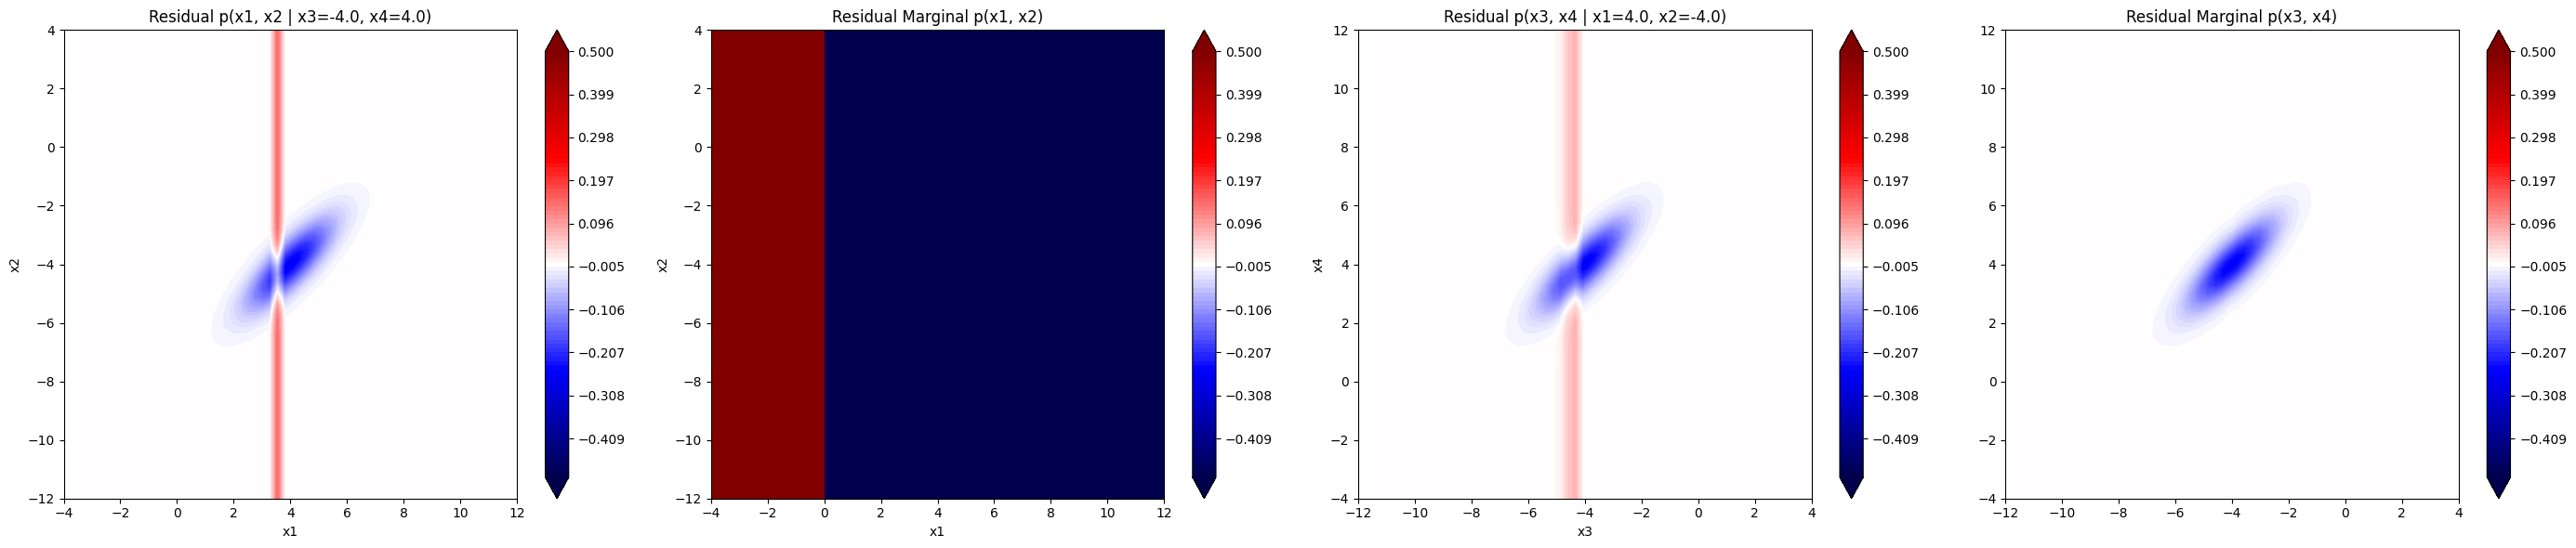

Complexity 16: Likelihood score: -454,231.6367479347
complexity 16 :: min predict conditional 12: 3.7802580425533935e-09, max predict conditional 12: 0.14611940625027242
complexity 16 :: min predict marginal 12: -37804109290.80921, max predict marginal 12: 37804109290.97663
complexity 16 :: min predict conditional 34: -0.0006938960401902579, max predict conditional 34: 0.07553899298896329
complexity 16 :: min predict marginal 34: -0.0039178919197829214, max predict marginal 34: 0.003917891919765574
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.14611940625027242
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.07553899298896329
max marginal p(x1,x2) residual = 0.14611940625027242
max marginal p(x3,x4) residual = 0.07553899298896329



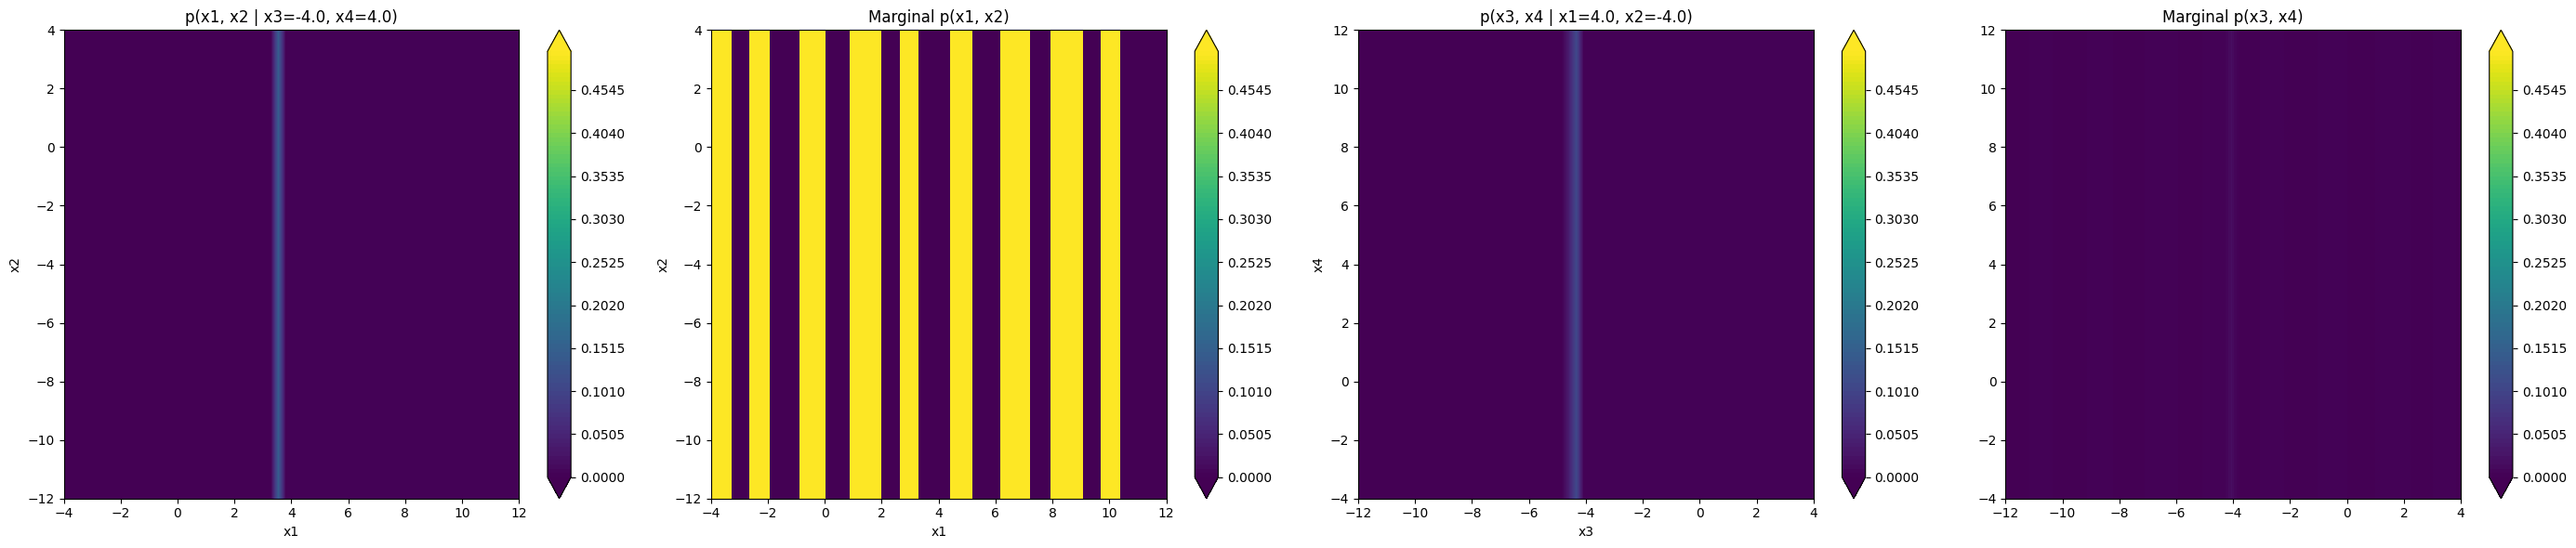

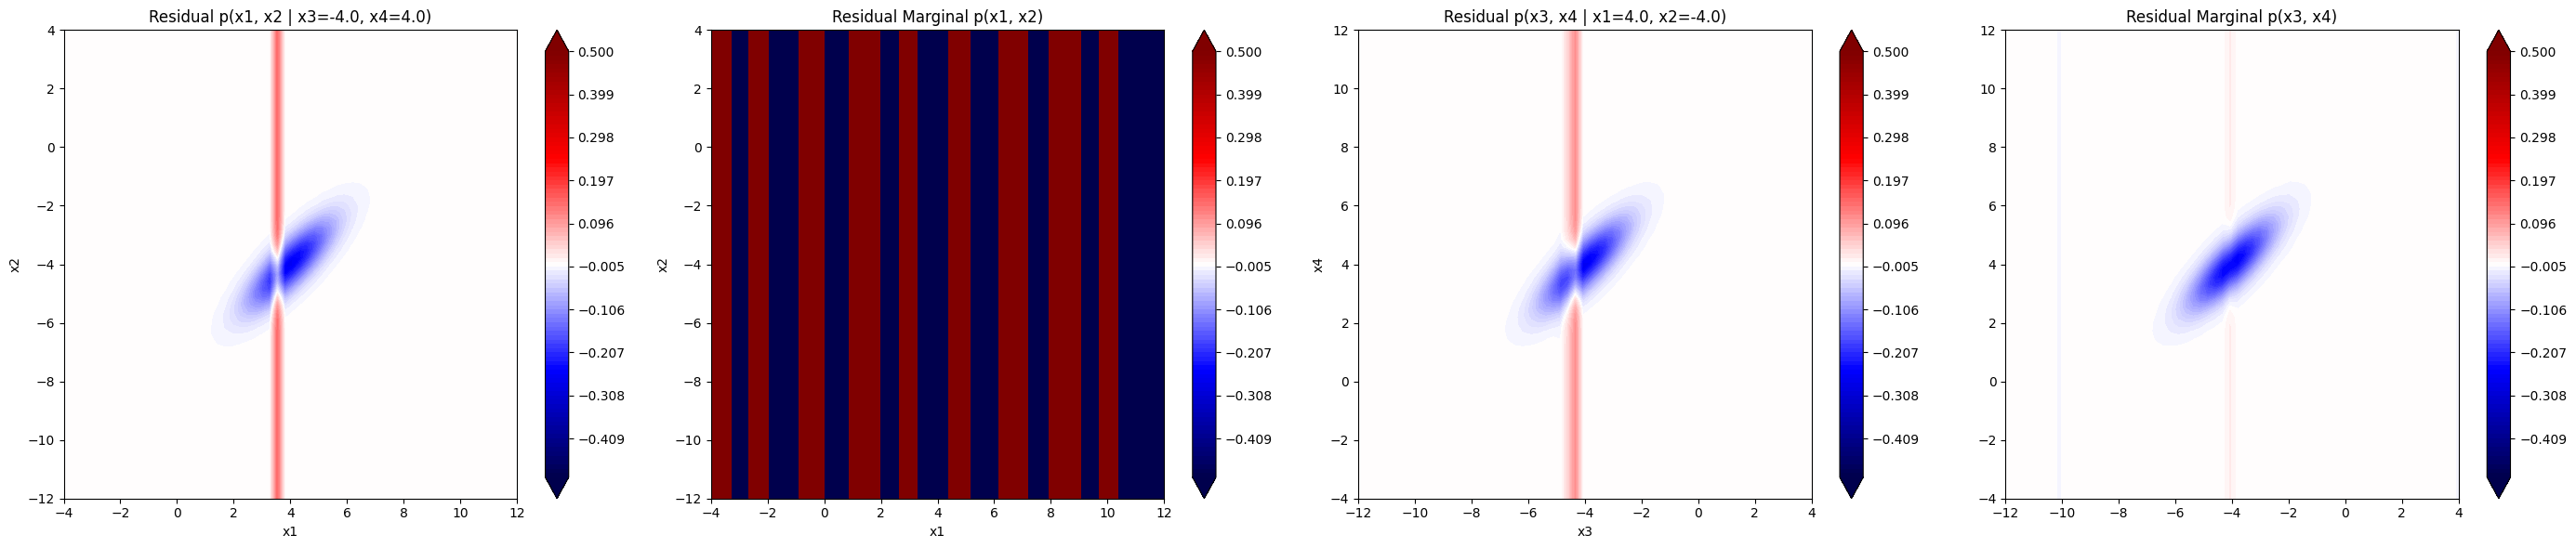

Complexity 18: Likelihood score: nan
complexity 18 :: min predict conditional 12: -1.9102473158617946e-05, max predict conditional 12: 0.1464687397435512
complexity 18 :: min predict marginal 12: -16360877583.031212, max predict marginal 12: 16360877583.13992
complexity 18 :: min predict conditional 34: -0.0036444635858438527, max predict conditional 34: 0.10992027273506735
complexity 18 :: min predict marginal 34: -0.01617989307715647, max predict marginal 34: 0.016179893077049038
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.1464687397435512
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.10992027273506735
max marginal p(x1,x2) residual = 0.1464687397435512
max marginal p(x3,x4) residual = 0.10992027273506735



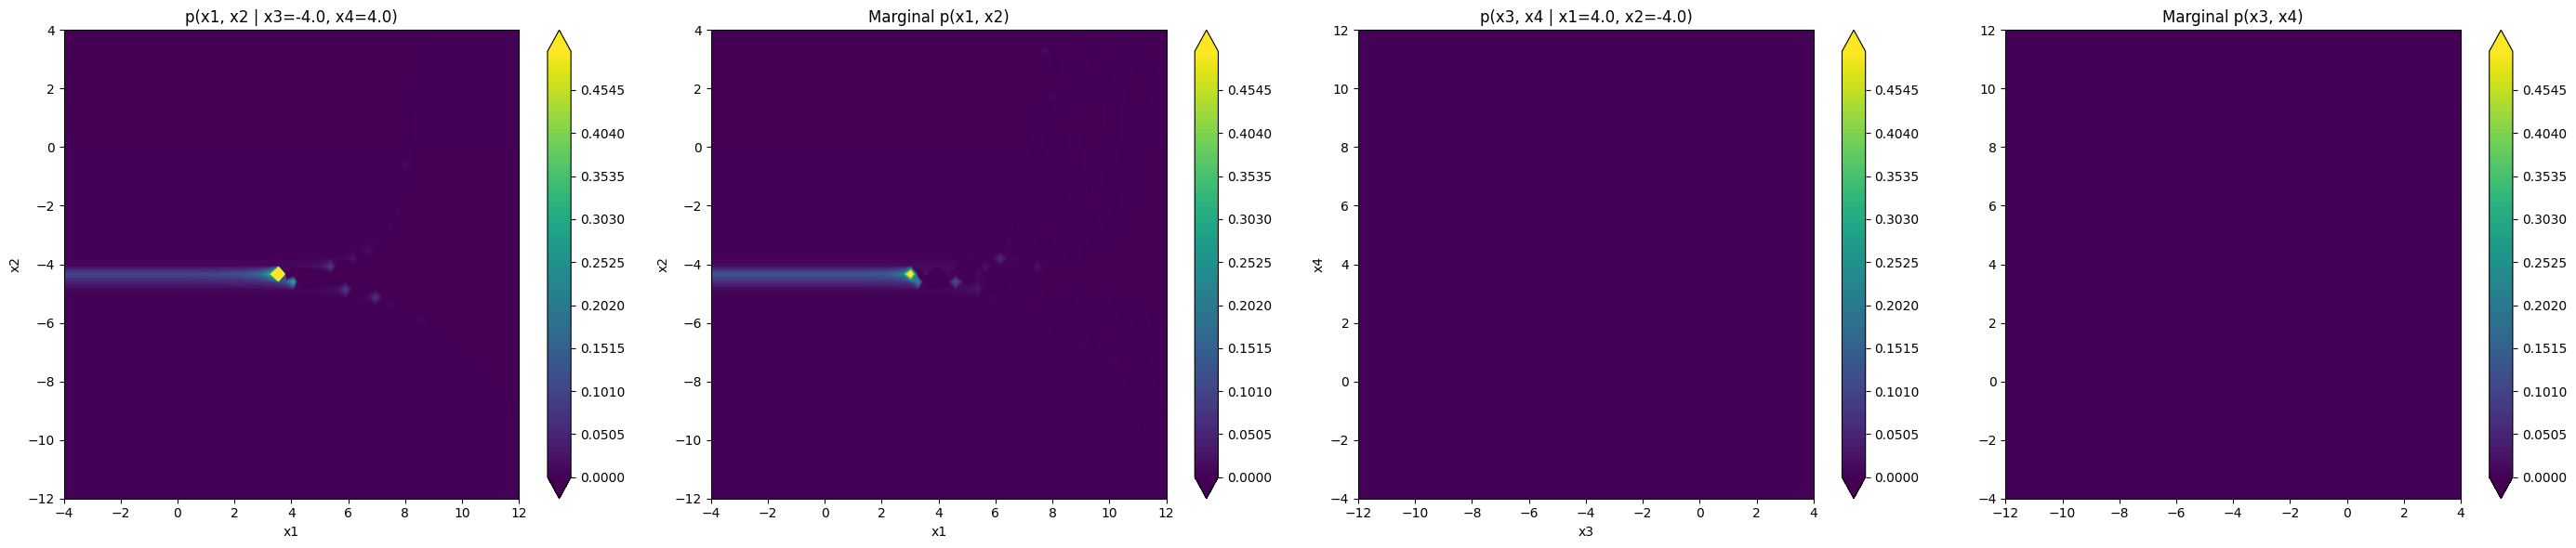

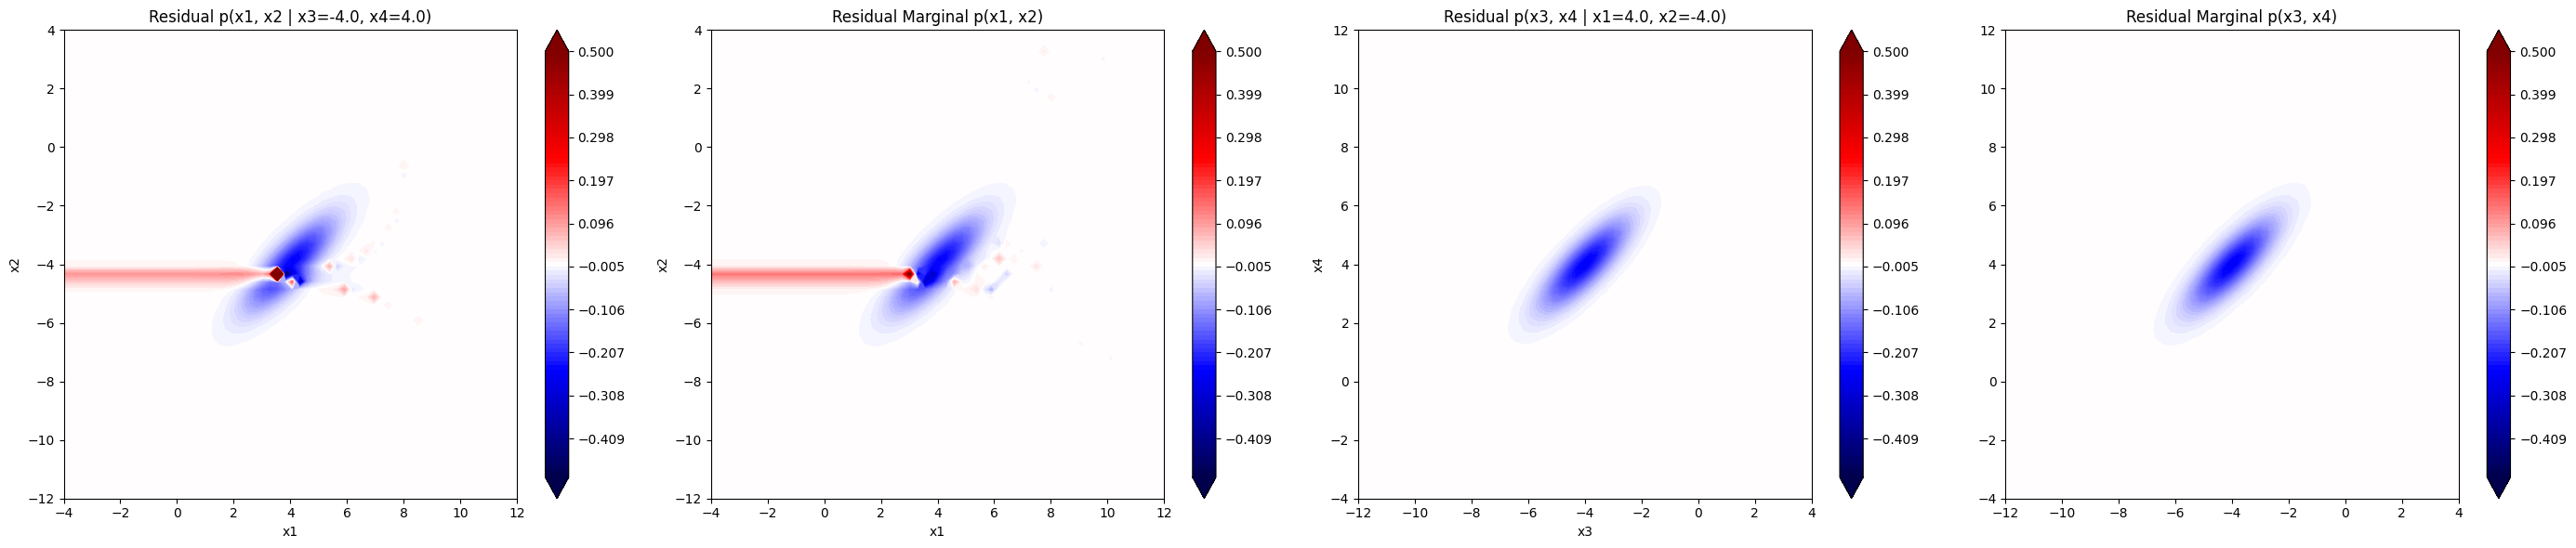

Complexity 21: Likelihood score: nan
complexity 21 :: min predict conditional 12: -0.3257342123757693, max predict conditional 12: 3.2093174318404407
complexity 21 :: min predict marginal 12: -0.15798927664278764, max predict marginal 12: 0.67544552452289
complexity 21 :: min predict conditional 34: 0.0008915687413565982, max predict conditional 34: 0.0028233099149719528
complexity 21 :: min predict marginal 34: -0.0002169301487985765, max predict marginal 34: 0.0022921609719811823
max conditional p(x1,x2|x3=-4,x4=4) residual = 2.9703988884625625
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.0028233099149719528
max marginal p(x1,x2) residual = 2.9703988884625625
max marginal p(x3,x4) residual = 0.0028233099149719528



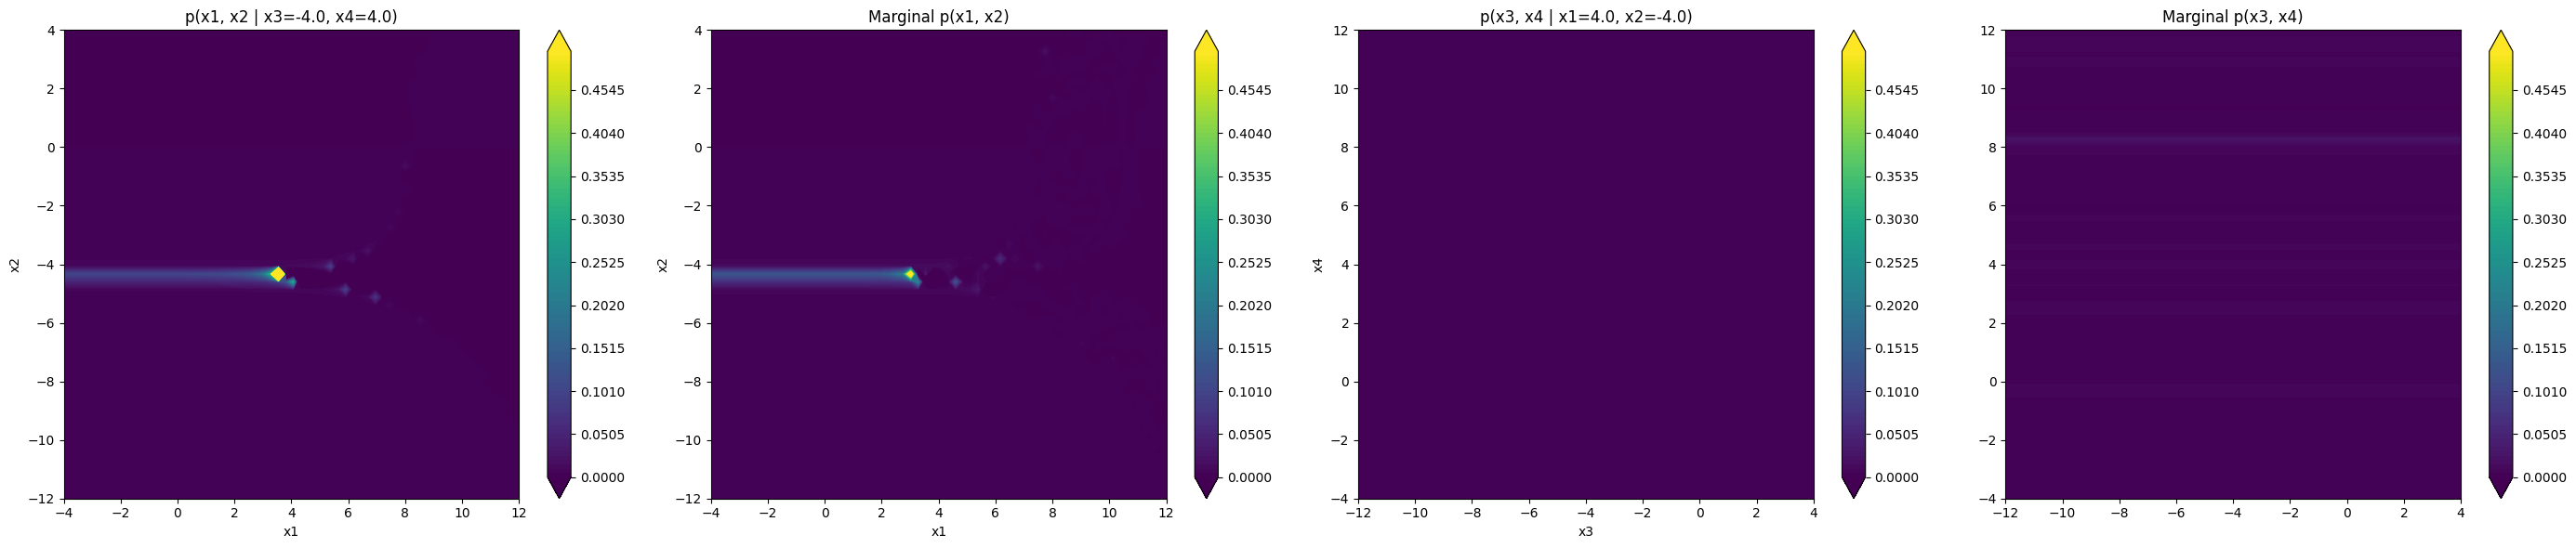

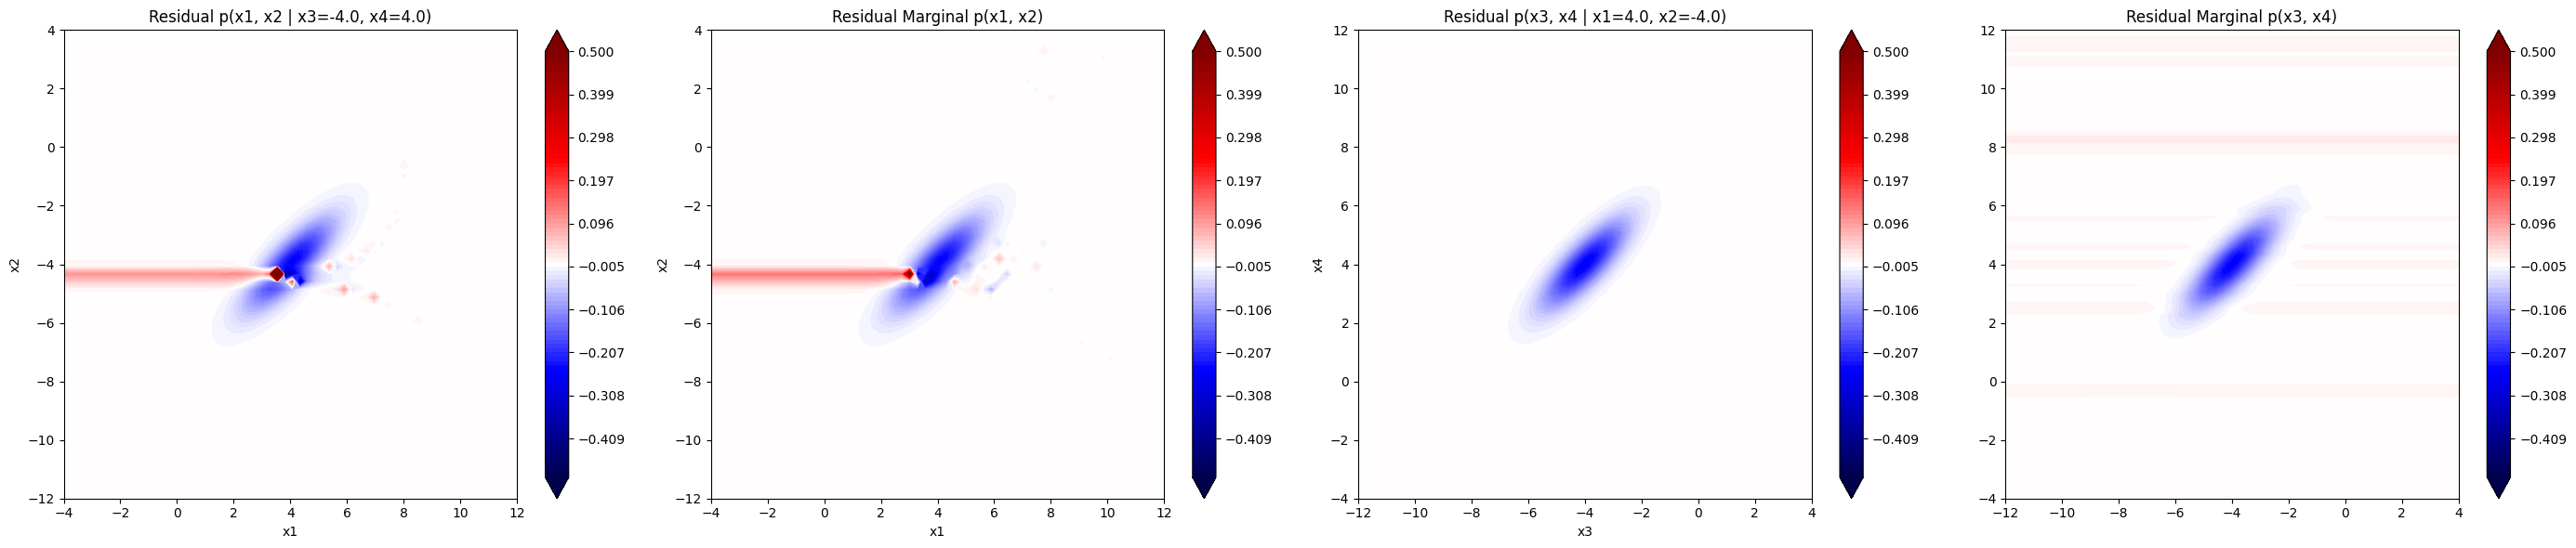

Complexity 23: Likelihood score: nan
complexity 23 :: min predict conditional 12: -0.32573421237576944, max predict conditional 12: 3.2093174318404416
complexity 23 :: min predict marginal 12: -0.1579892766427876, max predict marginal 12: 0.6754455245228895
complexity 23 :: min predict conditional 34: 0.0008915687413565985, max predict conditional 34: 0.0028233099149719536
complexity 23 :: min predict marginal 34: -0.002234732507700936, max predict marginal 34: 0.02361297710502161
max conditional p(x1,x2|x3=-4,x4=4) residual = 2.9703988884625634
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.0028233099149719536
max marginal p(x1,x2) residual = 2.9703988884625634
max marginal p(x3,x4) residual = 0.0028233099149719536



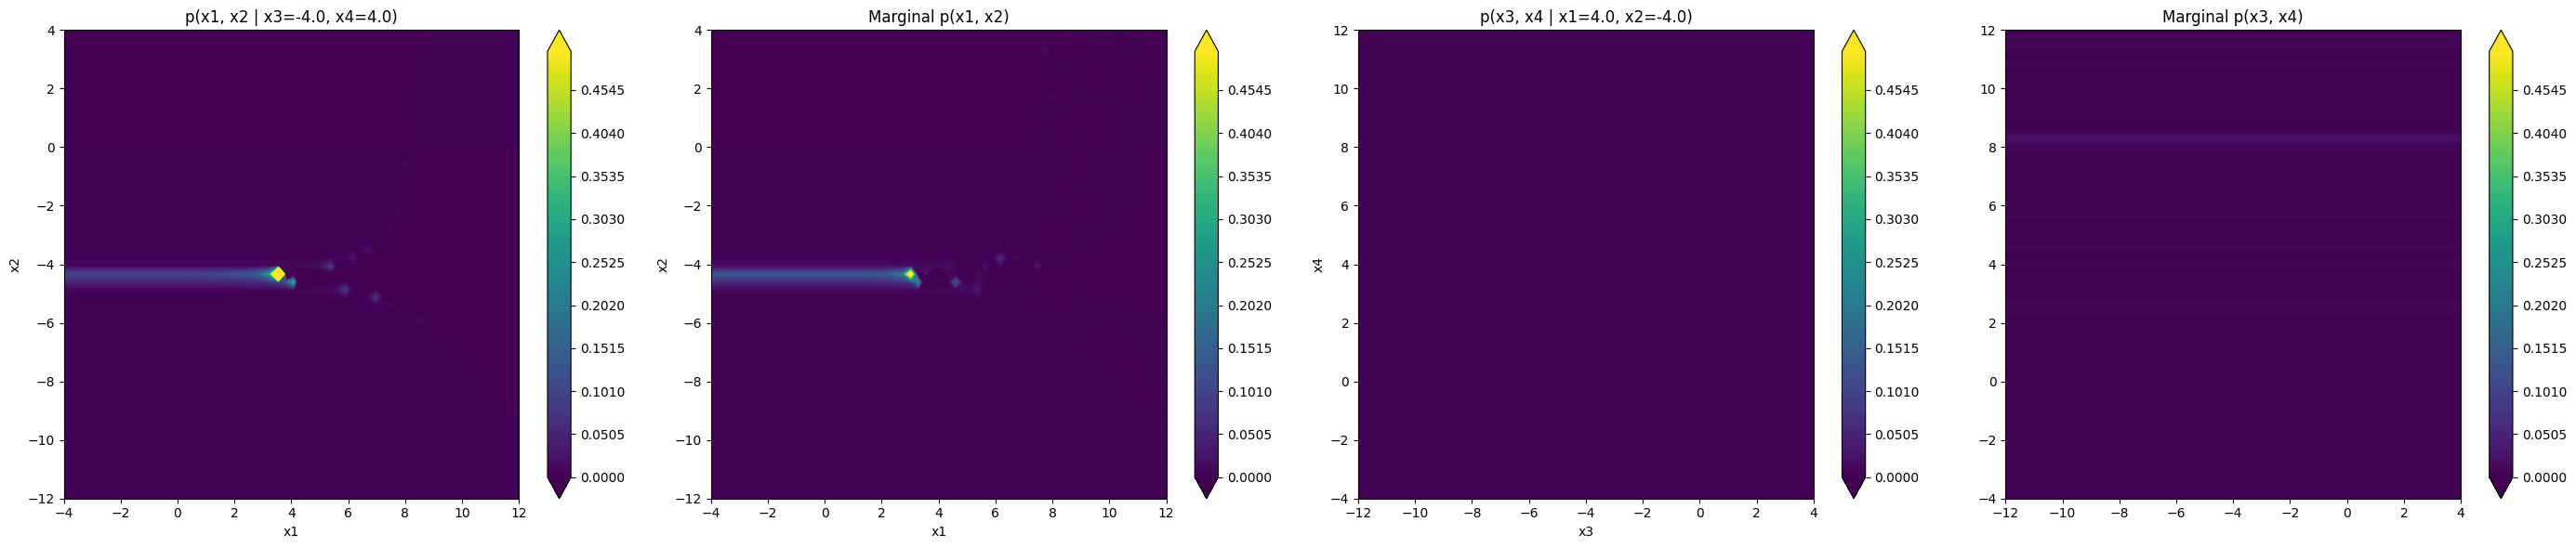

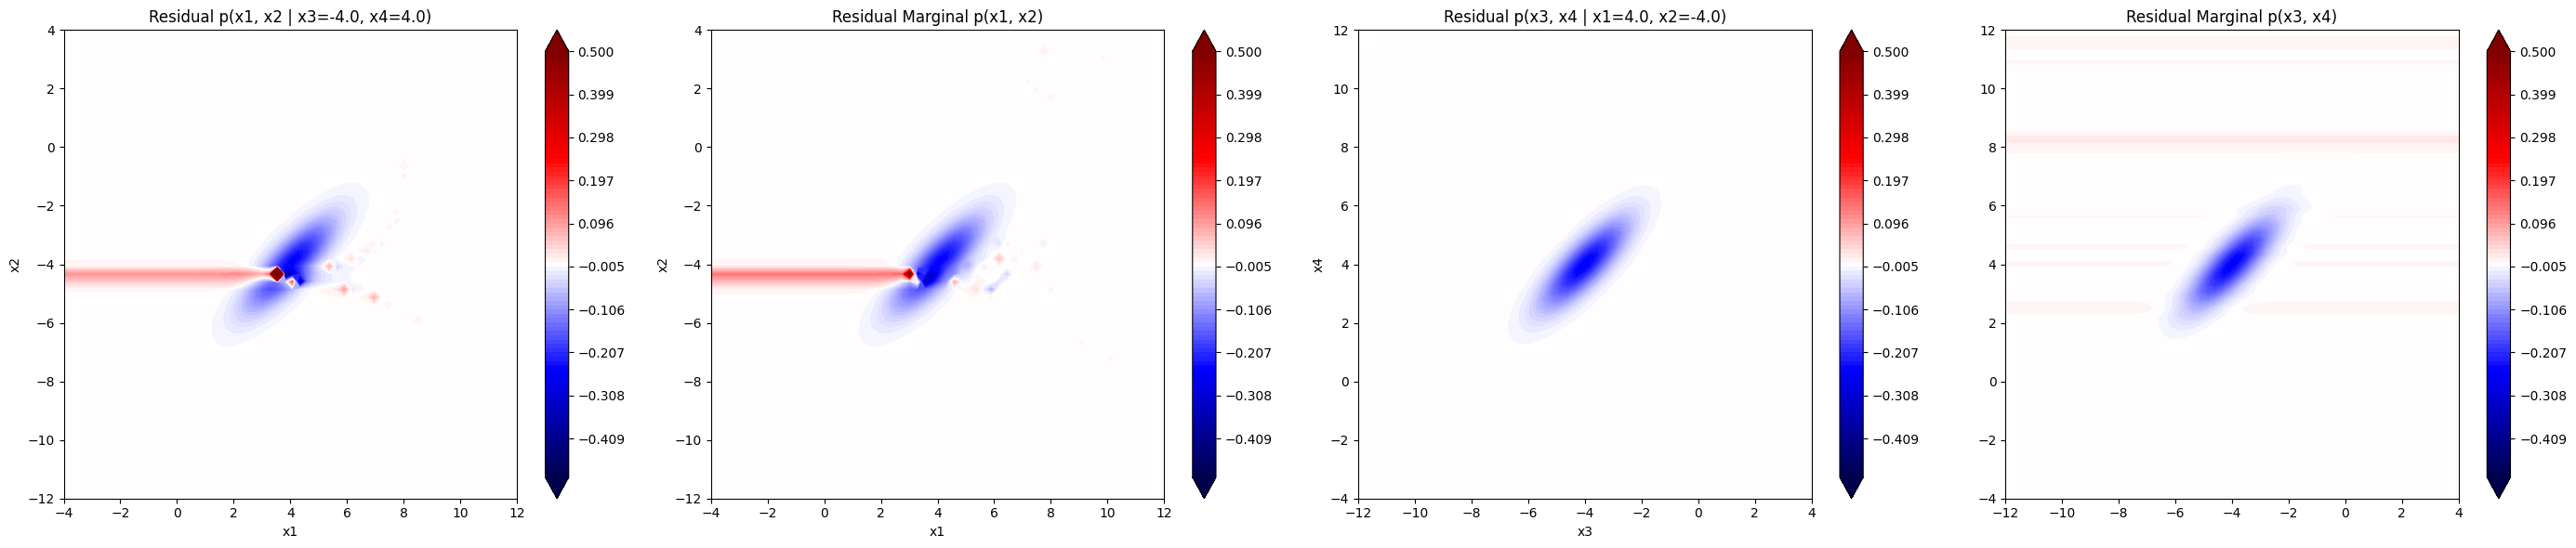

Complexity 24: Likelihood score: nan
complexity 24 :: min predict conditional 12: -0.32573421237576944, max predict conditional 12: 3.209317431840441
complexity 24 :: min predict marginal 12: -0.15798927664278756, max predict marginal 12: 0.6754455245228899
complexity 24 :: min predict conditional 34: 0.000891568741356599, max predict conditional 34: 0.002823309914971955
complexity 24 :: min predict marginal 34: -0.0020708556089844656, max predict marginal 34: 0.021881395609652857
max conditional p(x1,x2|x3=-4,x4=4) residual = 2.970398888462563
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.002823309914971955
max marginal p(x1,x2) residual = 2.970398888462563
max marginal p(x3,x4) residual = 0.002823309914971955



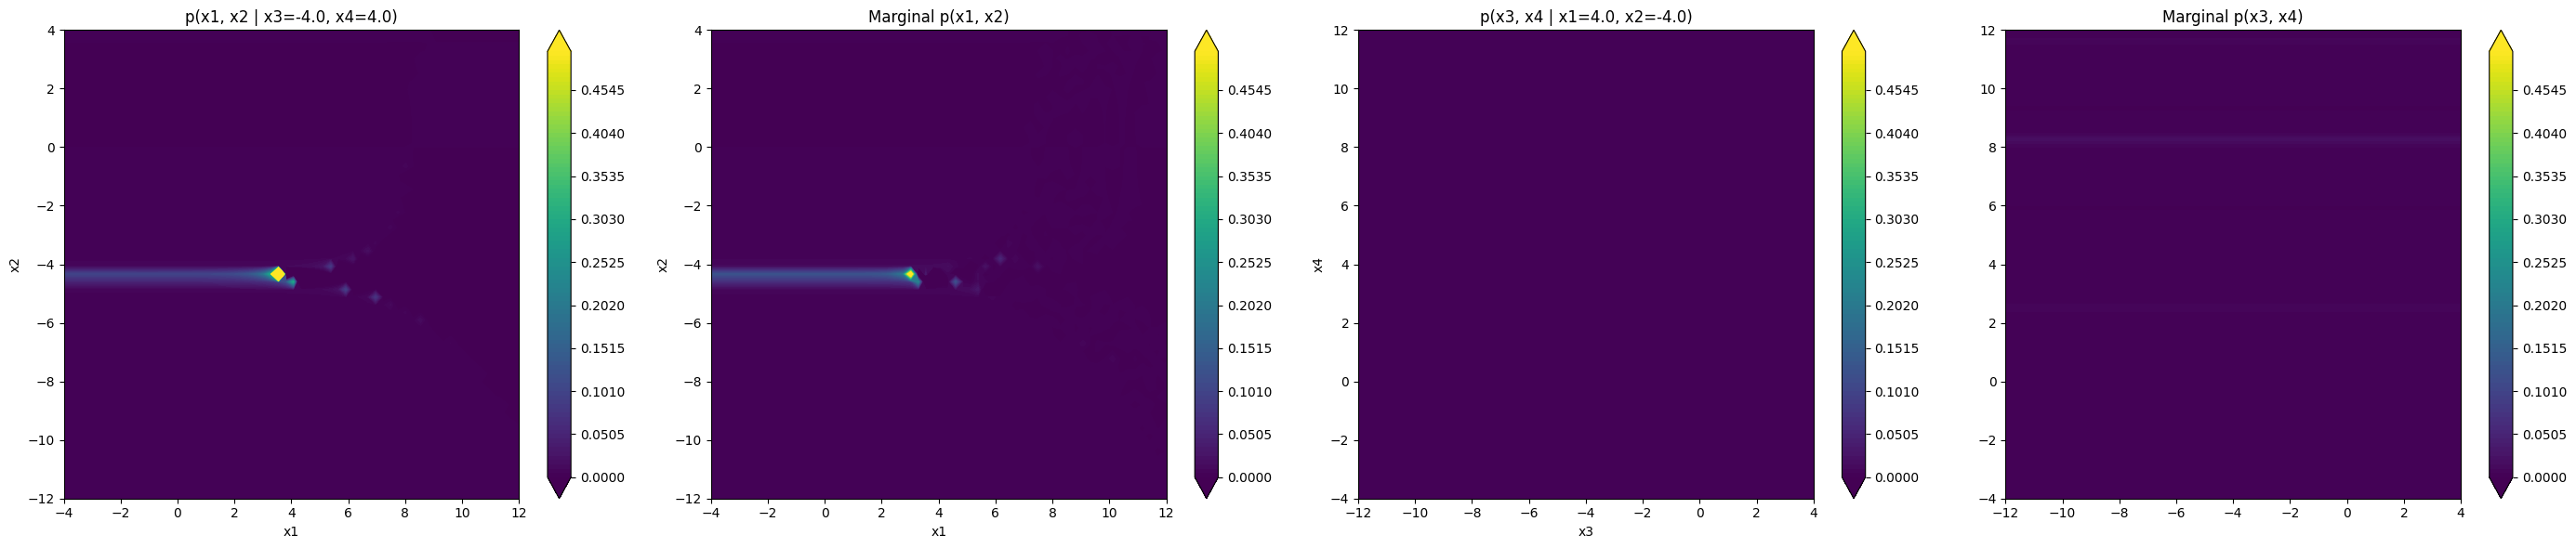

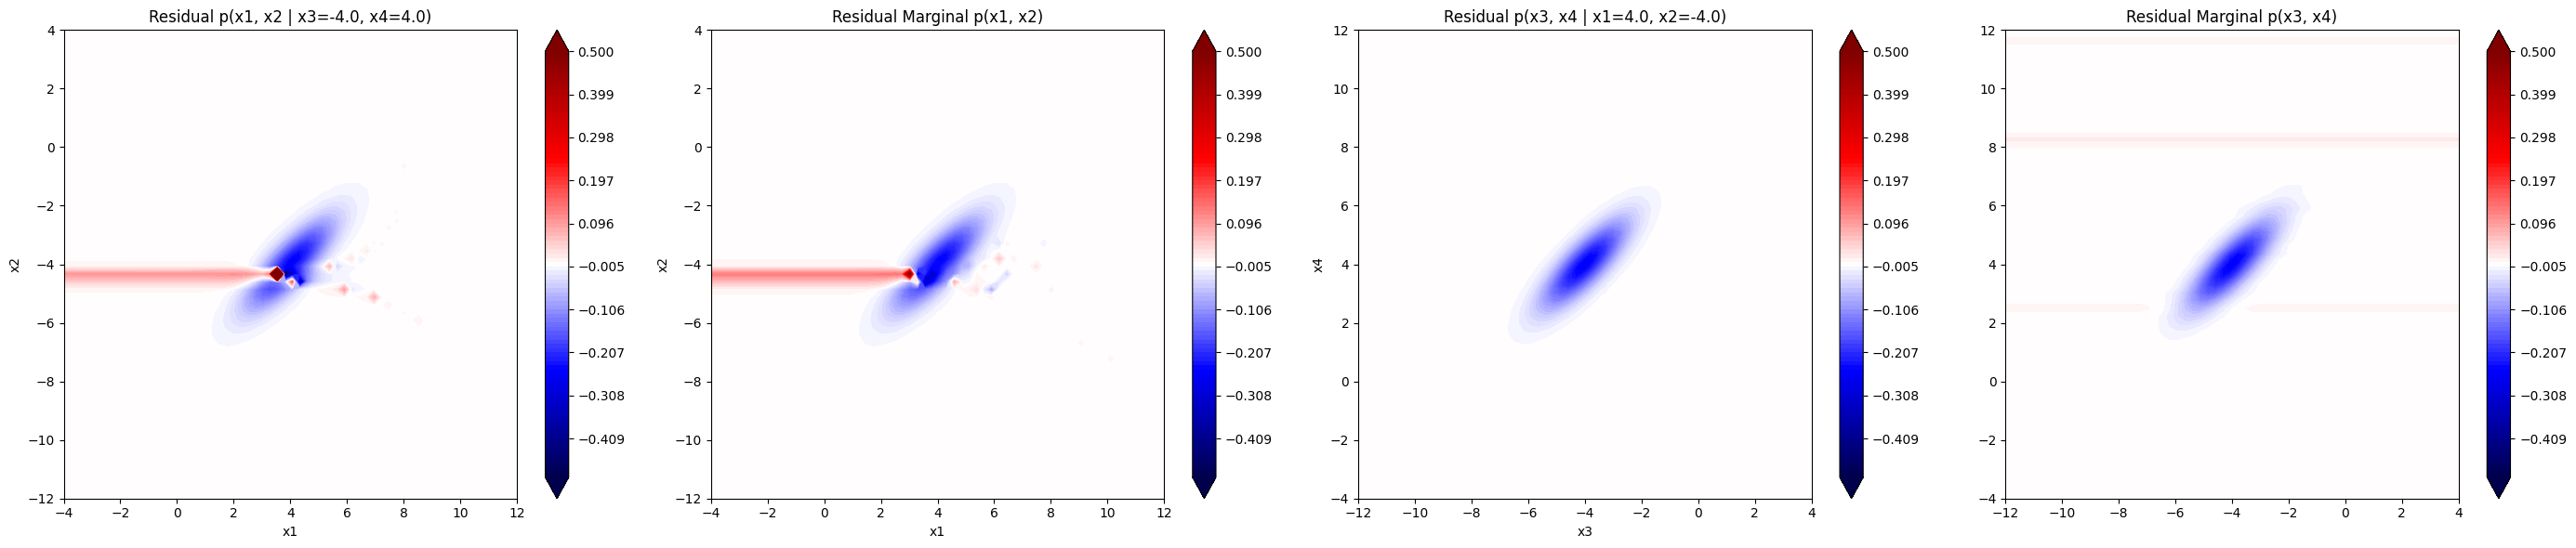

Complexity 25: Likelihood score: nan
complexity 25 :: min predict conditional 12: -0.3277353096850271, max predict conditional 12: 3.125479002215921
complexity 25 :: min predict marginal 12: -0.15778968750058278, max predict marginal 12: 0.6529582083620483
complexity 25 :: min predict conditional 34: 0.0008904121138297794, max predict conditional 34: 0.0028269235871394892
complexity 25 :: min predict marginal 34: -0.0017375081166462107, max predict marginal 34: 0.01829716959357667
max conditional p(x1,x2|x3=-4,x4=4) residual = 2.886560458838043
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.0028269235871394892
max marginal p(x1,x2) residual = 2.886560458838043
max marginal p(x3,x4) residual = 0.0028269235871394892



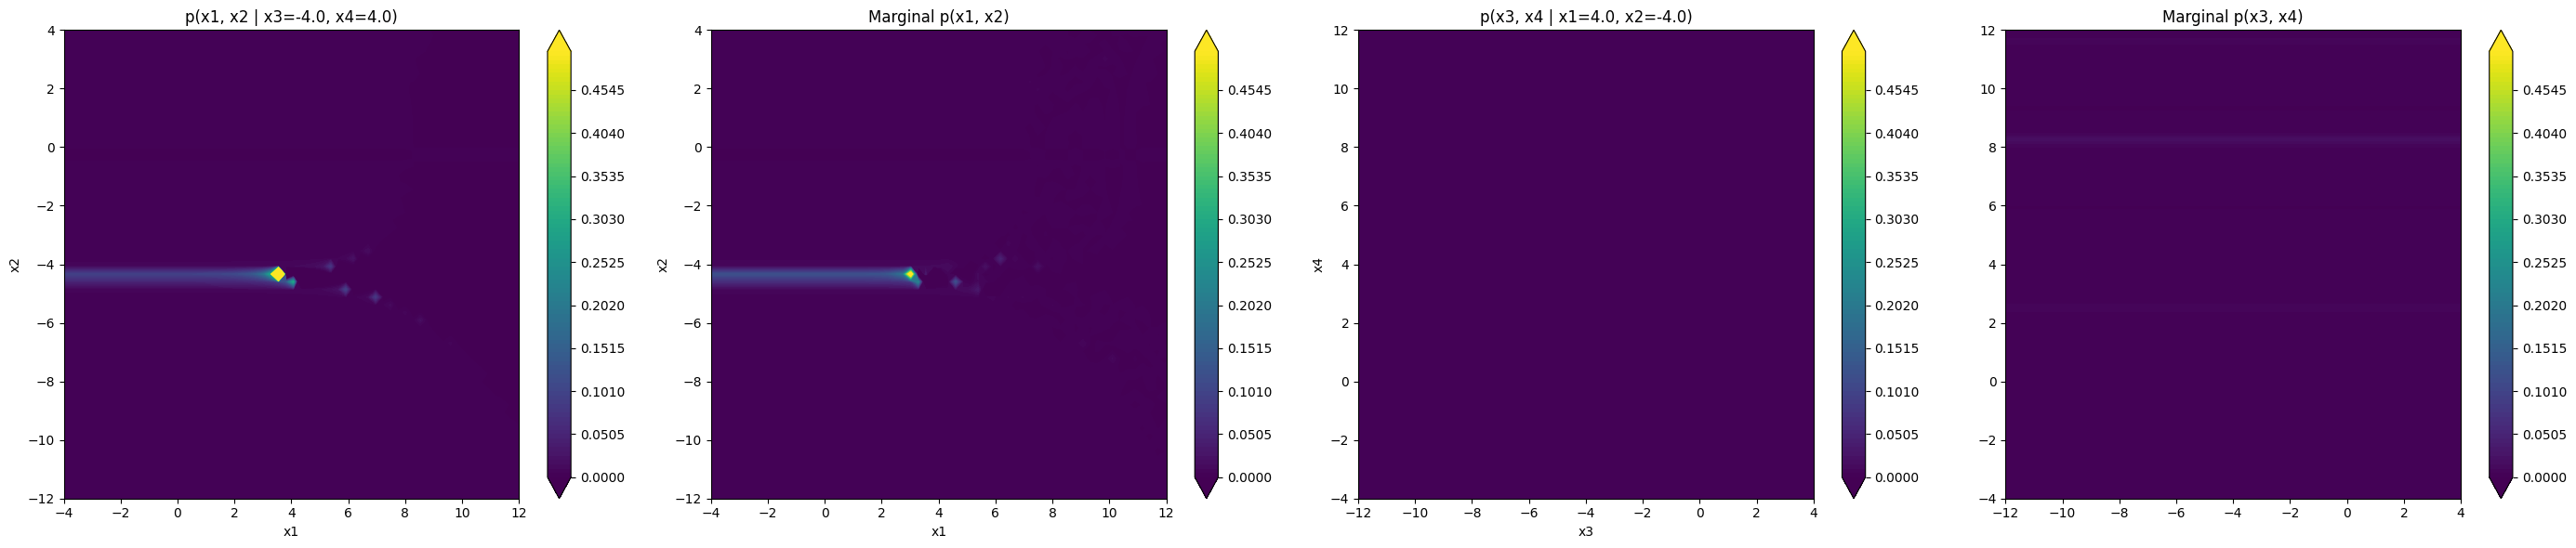

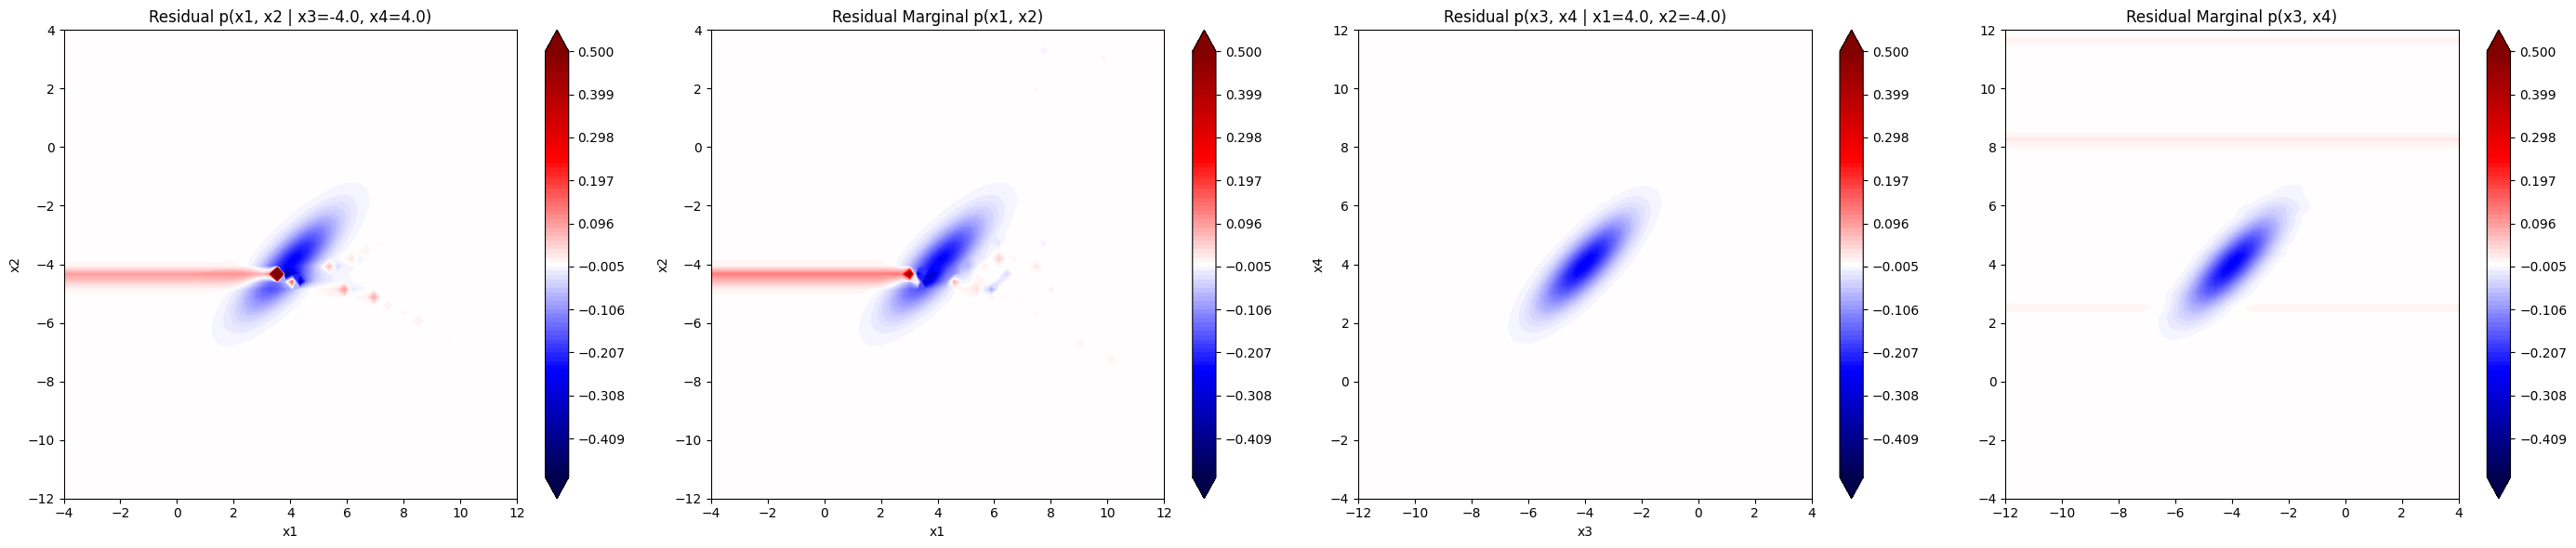

Complexity 27: Likelihood score: nan
complexity 27 :: min predict conditional 12: -0.32978102810072923, max predict conditional 12: 3.0397711165309214
complexity 27 :: min predict marginal 12: -0.15758866270653904, max predict marginal 12: 0.6303091401317128
complexity 27 :: min predict conditional 34: 0.0008890606045844066, max predict conditional 34: 0.002831146131762474
complexity 27 :: min predict marginal 34: -0.0016899072683641907, max predict marginal 34: 0.017732244071266525
max conditional p(x1,x2|x3=-4,x4=4) residual = 2.800852573153043
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.002831146131762474
max marginal p(x1,x2) residual = 2.800852573153043
max marginal p(x3,x4) residual = 0.002831146131762474

Finished generating and saving plots for 21 functions.


In [36]:
# Iterate over the masked_functions list
grid_coordinates = np.vstack([grids[0].ravel(), grids[1].ravel(), grids[2].ravel(), grids[3].ravel()])
grid_coordinates = grid_coordinates.T

grid_axes = [
        grids[0][:,0,0,0],  # x1
        grids[1][0,:,0,0],  # x2
        grids[2][0,0,:,0],  # x3
        grids[3][0,0,0,:]   # x4
    ]

for i, current_function in enumerate(predicted_functions):
    # Skip if the function is not defined or you only want to plot specific ones
    # if i not in [2, 5]:  # Example: plot only indices 2 and 5
    #     continue
    
    func_predicted_density = current_function(grid_coordinates[:,0], grid_coordinates[:,1], grid_coordinates[:,2], grid_coordinates[:,3])/density_scale_factor
    if func_predicted_density.size==1:
        func_predicted_density = func_predicted_density*np.ones(grid_coordinates[:,0].shape)
    func_predicted_density = func_predicted_density.reshape(grids[0].shape)

    func_total_mass = np.trapezoid(
        np.trapezoid(
          np.trapezoid(
            np.trapezoid(func_predicted_density, x=grid_axes[3], axis=3),
          x=grid_axes[2], axis=2),
        x=grid_axes[1], axis=1),
      x=grid_axes[0], axis=0)

    X1, X2, func12_joint_density_on_slice, func12_conditional_density, func12_marginal_for_slice, func12_marginal_density = conditional_and_marginal_generation(
        joint_density=func_predicted_density,
        grids=grids,
        conditioning_xa_target=-4.0,
        conditioning_xb_target=4.0,
        ab_idx = (3,4),
        plot=False,
        log_plot=False,      # use log scale for tail densities
        trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
        total_mass = func_total_mass
    )

    X3, X4, func34_joint_density_on_slice, func34_conditional_density, func34_marginal_for_slice, func34_marginal_density = conditional_and_marginal_generation(
        joint_density=func_predicted_density,
        grids=grids,
        conditioning_xa_target=4.0,
        conditioning_xb_target=-4.0,
        ab_idx = (1,2),
        plot=False,
        log_plot=False,      # use log scale for tail densities
        trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
    )
    
    # Get the title for the current function
    title = latex_labels[i]

    fig, axs = plt.subplots(1, 4, figsize=(28, 6))

    cf00 = axs[0].contourf(X1, X2, func12_conditional_density, levels=levels_results, cmap="viridis", extend="both")
    fig.colorbar(cf00, ax=axs[0])
    axs[0].set_title("p(x1, x2 | x3=-4.0, x4=4.0)")
    axs[0].set_xlim([-4, 12])
    axs[0].set_ylim([-12, 4])
    axs[0].set_xlabel("x1")
    axs[0].set_ylabel("x2")

    cf01 = axs[1].contourf(X1, X2, func12_marginal_density, levels=levels_results, cmap="viridis", extend="both")
    fig.colorbar(cf01, ax=axs[1])
    axs[1].set_title("Marginal p(x1, x2)")
    axs[1].set_xlim([-4, 12])
    axs[1].set_ylim([-12, 4])
    axs[1].set_xlabel("x1")
    axs[1].set_ylabel("x2")

    cf10 = axs[2].contourf(X3, X4, func34_conditional_density, levels=levels_results, cmap="viridis", extend="both")
    fig.colorbar(cf10, ax=axs[2])
    axs[2].set_title("p(x3, x4 | x1=4.0, x2=-4.0)")
    axs[2].set_xlim([-12, 4])
    axs[2].set_ylim([-4, 12])
    axs[2].set_xlabel("x3")
    axs[2].set_ylabel("x4")

    cf11 = axs[3].contourf(X3, X4, func34_marginal_density, levels=levels_results, cmap="viridis", extend="both")
    fig.colorbar(cf11, ax=axs[3])
    axs[3].set_title("Marginal p(x3, x4)")
    axs[3].set_xlim([-12, 4])
    axs[3].set_ylim([-4, 12])
    axs[2].set_xlabel("x3")
    axs[2].set_ylabel("x4")
    plt.tight_layout()
    plt.show()
    plt.close(fig) 
    gc.collect()

    fig, axs = plt.subplots(1, 4, figsize=(28, 6))

    cf00 = axs[0].contourf(X1, X2, func12_conditional_density - ground_truth_cluster_1(X1, X2), levels=levels_results_residuals, cmap="seismic", extend="both")
    fig.colorbar(cf00, ax=axs[0])
    axs[0].set_title("Residual p(x1, x2 | x3=-4.0, x4=4.0)")
    axs[0].set_xlim([-4, 12])
    axs[0].set_ylim([-12, 4])
    axs[0].set_xlabel("x1")
    axs[0].set_ylabel("x2")

    cf01 = axs[1].contourf(X1, X2, func12_marginal_density - ground_truth_cluster_1(X1, X2), levels=levels_results_residuals, cmap="seismic", extend="both")
    fig.colorbar(cf01, ax=axs[1])
    axs[1].set_title("Residual Marginal p(x1, x2)")
    axs[1].set_xlim([-4, 12])
    axs[1].set_ylim([-12, 4])
    axs[1].set_xlabel("x1")
    axs[1].set_ylabel("x2")

    cf10 = axs[2].contourf(X3, X4, func34_conditional_density - ground_truth_cluster_2(X3, X4), levels=levels_results_residuals, cmap="seismic", extend="both")
    fig.colorbar(cf10, ax=axs[2])
    axs[2].set_title("Residual p(x3, x4 | x1=4.0, x2=-4.0)")
    axs[2].set_xlim([-12, 4])
    axs[2].set_ylim([-4, 12])
    axs[2].set_xlabel("x3")
    axs[2].set_ylabel("x4")

    cf11 = axs[3].contourf(X3, X4, func34_marginal_density - ground_truth_cluster_2(X3, X4), levels=levels_results_residuals, cmap="seismic", extend="both")
    fig.colorbar(cf11, ax=axs[3])
    axs[3].set_title("Residual Marginal p(x3, x4)")
    axs[3].set_xlim([-12, 4])
    axs[3].set_ylim([-4, 12])
    axs[2].set_xlabel("x3")
    axs[2].set_ylabel("x4")
    plt.tight_layout()
    plt.show()
    plt.close(fig) 
    gc.collect()
    
    prediction_eval_at_samples = current_function(test_samples[:,0], test_samples[:,1], test_samples[:,2], test_samples[:,3])
    likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))
    print(f"Complexity {complexity[i]}: Likelihood score: {likelihood_score_of_prediction:,}")
    print(f"complexity {complexity[i]} :: min predict conditional 12: {np.min(func12_conditional_density)}, max predict conditional 12: {np.max(func12_conditional_density)}")
    print(f"complexity {complexity[i]} :: min predict marginal 12: {np.min(func12_marginal_density)}, max predict marginal 12: {np.max(func12_marginal_density)}")
    print(f"complexity {complexity[i]} :: min predict conditional 34: {np.min(func34_conditional_density)}, max predict conditional 34: {np.max(func34_conditional_density)}")
    print(f"complexity {complexity[i]} :: min predict marginal 34: {np.min(func34_marginal_density)}, max predict marginal 34: {np.max(func34_marginal_density)}")

    print(f"max conditional p(x1,x2|x3=-4,x4=4) residual = {np.max(func12_conditional_density - ground_truth_cluster_1(X1, X2))}")
    print(f"max conditional p(x3,x4|x1=4,x2=-4) residual = {np.max(func34_conditional_density - ground_truth_cluster_2(X3, X4))}")
    print(f"max marginal p(x1,x2) residual = {np.max(func12_conditional_density - ground_truth_cluster_1(X1, X2))}")
    print(f"max marginal p(x3,x4) residual = {np.max(func34_conditional_density - ground_truth_cluster_2(X3, X4))}\n")
    
    del func_predicted_density


# Note: plt.show() is typically outside the loop if you want to see all plots
# or not used at all if you are just saving the files.
print(f"Finished generating and saving plots for {len(predicted_functions)} functions.")

# Final Plot

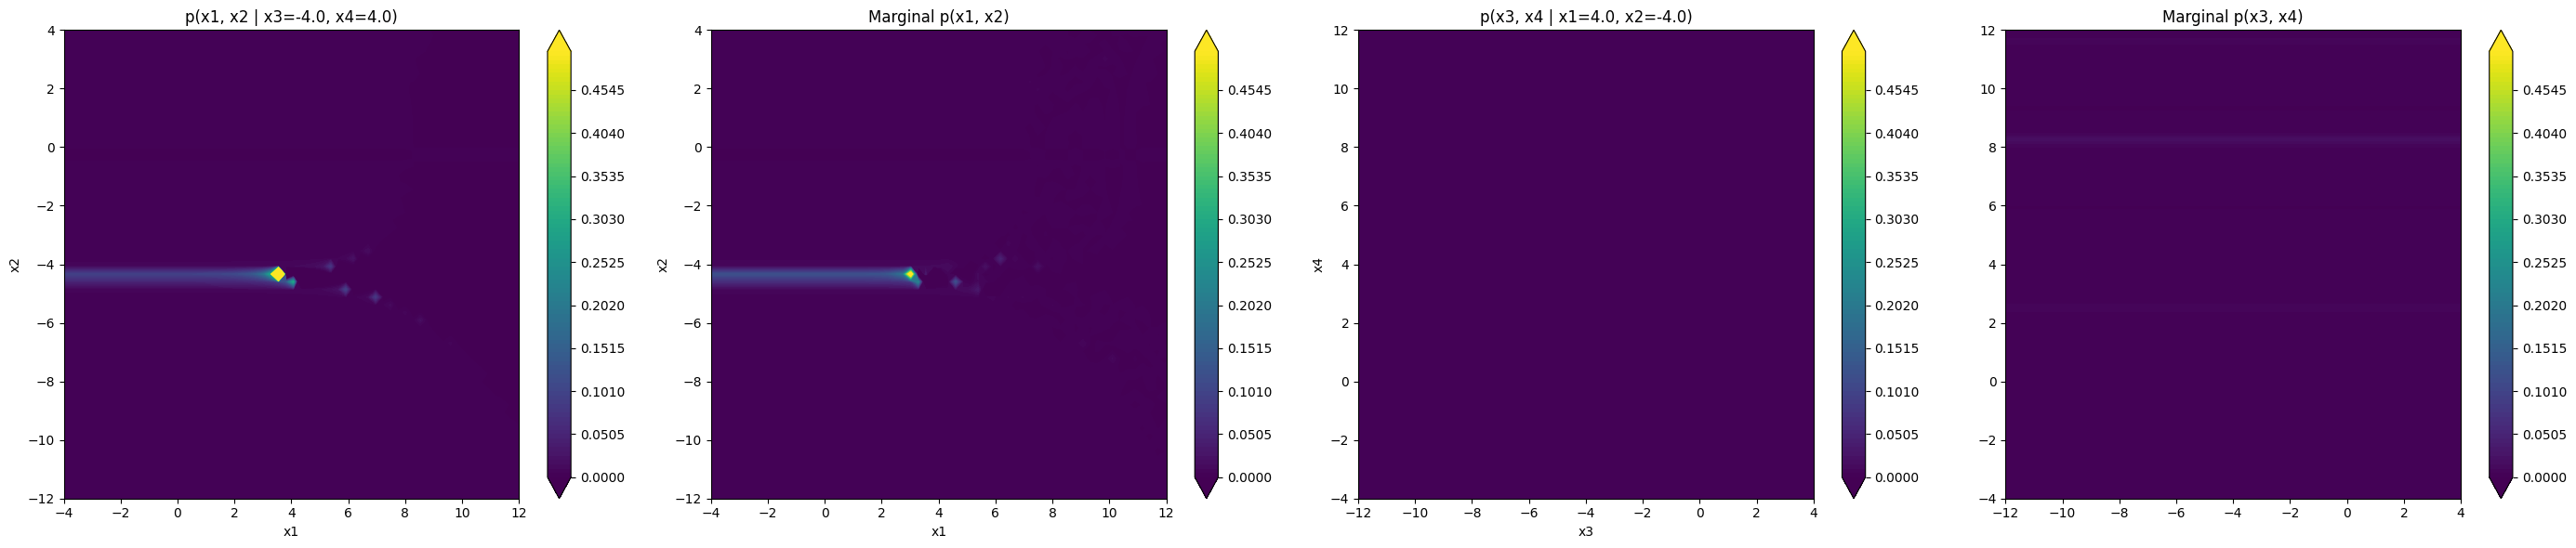

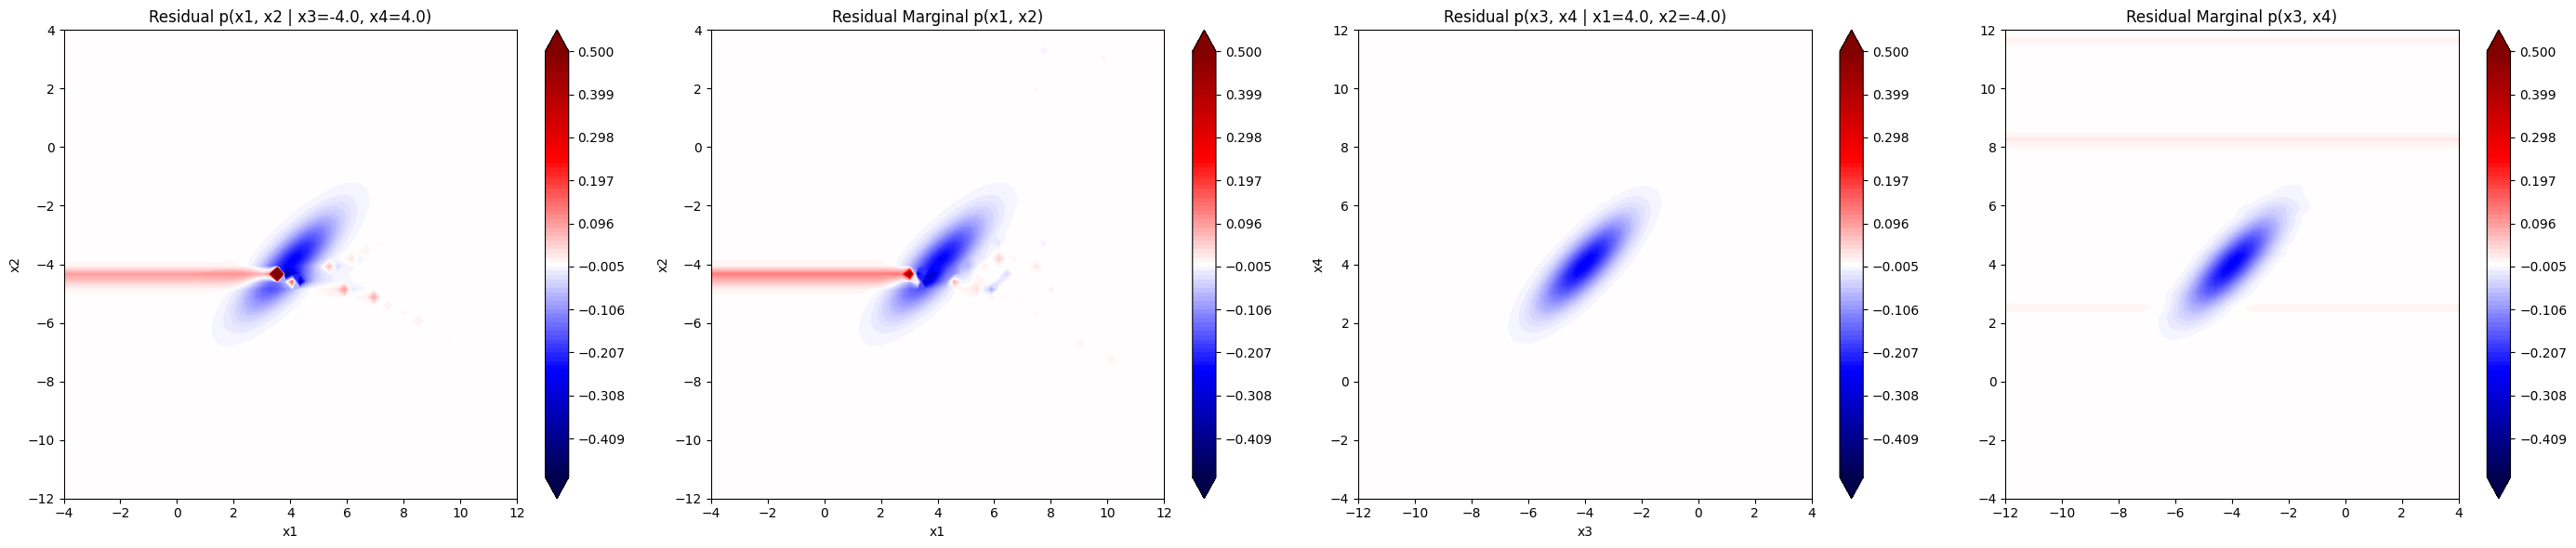

Complexity 27: Likelihood score: nan
complexity 27 :: min predict conditional 12: -0.32978102810072923, max predict conditional 12: 3.0397711165309214
complexity 27 :: min predict marginal 12: -0.15758866270653904, max predict marginal 12: 0.6303091401317128
complexity 27 :: min predict conditional 34: 0.0008890606045844066, max predict conditional 34: 0.002831146131762474
complexity 27 :: min predict marginal 34: -0.0016899072683641907, max predict marginal 34: 0.017732244071266525
max conditional p(x1,x2|x3=-4,x4=4) residual = 2.800852573153043
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.002831146131762474
max marginal p(x1,x2) residual = 2.800852573153043
max marginal p(x3,x4) residual = 0.002831146131762474

Finished generating and saving plots for 21 functions.


/tmp/ipykernel_2424218/831425517.py:127: RuntimeWarning: invalid value encountered in log
  likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))


In [37]:
# Iterate over the masked_functions list
grid_coordinates = np.vstack([grids[0].ravel(), grids[1].ravel(), grids[2].ravel(), grids[3].ravel()])
grid_coordinates = grid_coordinates.T

grid_axes = [
        grids[0][:,0,0,0],  # x1
        grids[1][0,:,0,0],  # x2
        grids[2][0,0,:,0],  # x3
        grids[3][0,0,0,:]   # x4
    ]

   
func_predicted_density = predicted_functions[-1](grid_coordinates[:,0], grid_coordinates[:,1], grid_coordinates[:,2], grid_coordinates[:,3])/density_scale_factor
if func_predicted_density.size==1:
    func_predicted_density = func_predicted_density*np.ones(grid_coordinates[:,0].shape)
func_predicted_density = func_predicted_density.reshape(grids[0].shape)

func_total_mass = np.trapezoid(
    np.trapezoid(
      np.trapezoid(
        np.trapezoid(func_predicted_density, x=grid_axes[3], axis=3),
      x=grid_axes[2], axis=2),
    x=grid_axes[1], axis=1),
  x=grid_axes[0], axis=0)

X1, X2, func12_joint_density_on_slice, func12_conditional_density, func12_marginal_for_slice, func12_marginal_density = conditional_and_marginal_generation(
    joint_density=func_predicted_density,
    grids=grids,
    conditioning_xa_target=-4.0,
    conditioning_xb_target=4.0,
    ab_idx = (3,4),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
    total_mass = func_total_mass
)

X3, X4, func34_joint_density_on_slice, func34_conditional_density, func34_marginal_for_slice, func34_marginal_density = conditional_and_marginal_generation(
    joint_density=func_predicted_density,
    grids=grids,
    conditioning_xa_target=4.0,
    conditioning_xb_target=-4.0,
    ab_idx = (1,2),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
)
  
    # Get the title for the current function
title = latex_labels[i]

fig, axs = plt.subplots(1, 4, figsize=(28, 6))

cf00 = axs[0].contourf(X1, X2, func12_conditional_density, levels=levels_results, cmap="viridis", extend="both")
fig.colorbar(cf00, ax=axs[0])
axs[0].set_title("p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0].set_xlim([-4, 12])
axs[0].set_ylim([-12, 4])
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")

cf01 = axs[1].contourf(X1, X2, func12_marginal_density, levels=levels_results, cmap="viridis", extend="both")
fig.colorbar(cf01, ax=axs[1])
axs[1].set_title("Marginal p(x1, x2)")
axs[1].set_xlim([-4, 12])
axs[1].set_ylim([-12, 4])
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")

cf10 = axs[2].contourf(X3, X4, func34_conditional_density, levels=levels_results, cmap="viridis", extend="both")
fig.colorbar(cf10, ax=axs[2])
axs[2].set_title("p(x3, x4 | x1=4.0, x2=-4.0)")
axs[2].set_xlim([-12, 4])
axs[2].set_ylim([-4, 12])
axs[2].set_xlabel("x3")
axs[2].set_ylabel("x4")

cf11 = axs[3].contourf(X3, X4, func34_marginal_density, levels=levels_results, cmap="viridis", extend="both")
fig.colorbar(cf11, ax=axs[3])
axs[3].set_title("Marginal p(x3, x4)")
axs[3].set_xlim([-12, 4])
axs[3].set_ylim([-4, 12])
axs[2].set_xlabel("x3")
axs[2].set_ylabel("x4")
plt.tight_layout()
plt.show()
plt.close(fig) 
gc.collect()
fig, axs = plt.subplots(1, 4, figsize=(28, 6))

cf00 = axs[0].contourf(X1, X2, func12_conditional_density - ground_truth_cluster_1(X1, X2), levels=levels_results_residuals, cmap="seismic", extend="both")
fig.colorbar(cf00, ax=axs[0])
axs[0].set_title("Residual p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0].set_xlim([-4, 12])
axs[0].set_ylim([-12, 4])
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")

cf01 = axs[1].contourf(X1, X2, func12_marginal_density - ground_truth_cluster_1(X1, X2), levels=levels_results_residuals, cmap="seismic", extend="both")
fig.colorbar(cf01, ax=axs[1])
axs[1].set_title("Residual Marginal p(x1, x2)")
axs[1].set_xlim([-4, 12])
axs[1].set_ylim([-12, 4])
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")

cf10 = axs[2].contourf(X3, X4, func34_conditional_density - ground_truth_cluster_2(X3, X4), levels=levels_results_residuals, cmap="seismic", extend="both")
fig.colorbar(cf10, ax=axs[2])
axs[2].set_title("Residual p(x3, x4 | x1=4.0, x2=-4.0)")
axs[2].set_xlim([-12, 4])
axs[2].set_ylim([-4, 12])
axs[2].set_xlabel("x3")
axs[2].set_ylabel("x4")
cf11 = axs[3].contourf(X3, X4, func34_marginal_density - ground_truth_cluster_2(X3, X4), levels=levels_results_residuals, cmap="seismic", extend="both")
fig.colorbar(cf11, ax=axs[3])
axs[3].set_title("Residual Marginal p(x3, x4)")
axs[3].set_xlim([-12, 4])
axs[3].set_ylim([-4, 12])
axs[2].set_xlabel("x3")
axs[2].set_ylabel("x4")
plt.tight_layout()
plt.show()
plt.close(fig) 
gc.collect()
    
prediction_eval_at_samples = predicted_functions[-1](test_samples[:,0], test_samples[:,1], test_samples[:,2], test_samples[:,3])
likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))
print(f"Complexity {complexity[i]}: Likelihood score: {likelihood_score_of_prediction:,}")
print(f"complexity {complexity[i]} :: min predict conditional 12: {np.min(func12_conditional_density)}, max predict conditional 12: {np.max(func12_conditional_density)}")
print(f"complexity {complexity[i]} :: min predict marginal 12: {np.min(func12_marginal_density)}, max predict marginal 12: {np.max(func12_marginal_density)}")
print(f"complexity {complexity[i]} :: min predict conditional 34: {np.min(func34_conditional_density)}, max predict conditional 34: {np.max(func34_conditional_density)}")
print(f"complexity {complexity[i]} :: min predict marginal 34: {np.min(func34_marginal_density)}, max predict marginal 34: {np.max(func34_marginal_density)}")
print(f"max conditional p(x1,x2|x3=-4,x4=4) residual = {np.max(func12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"max conditional p(x3,x4|x1=4,x2=-4) residual = {np.max(func34_conditional_density - ground_truth_cluster_2(X3, X4))}")
print(f"max marginal p(x1,x2) residual = {np.max(func12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"max marginal p(x3,x4) residual = {np.max(func34_conditional_density - ground_truth_cluster_2(X3, X4))}\n")
   
del func_predicted_density


# Note: plt.show() is typically outside the loop if you want to see all plots
# or not used at all if you are just saving the files.
print(f"Finished generating and saving plots for {len(predicted_functions)} functions.")

In [38]:
raw_equations_direct = raw_equations
complexity_direct = complexity
loss_direct = loss

In [39]:
file_path = "data/pareto_results/gaussian_independent_set12_results.py"
exec(open(file_path).read())
raw_equations_i12 = raw_equations
complexity_i12 = complexity
loss_i12 = loss


Original at complexity 1: 0.15074529688818464
function_ready: 0.15074529688818464
Processed: 0.150000000000000
LaTeX: 0.15

Original at complexity 3: 0.7479946285650192 / 4.9621683078400265
function_ready: 0.7479946285650192 / 4.9621683078400265
Processed: 0.150000000000000
LaTeX: 0.15

Original at complexity 5: pow2(10.171239683966105) / pow3(8.820984548007875)
function_ready: pow2(10.171239683966105) / pow3(8.820984548007875)
Processed: pow2(10.0)/pow3(8.8)
LaTeX: 0.15

Original at complexity 6: x1 / (6.508089485899555 + pow2(x1))
function_ready: x1 / (6.508089485899555 + pow2(x1))
Processed: x1/(pow2(x1) + 6.5)
LaTeX: \frac{x_{1}}{x_{1}^{2} + 6.5}

Original at complexity 7: 1.1099801359413088 / exp(pow2(x2 + 4.00063592787958))
function_ready: 1.1099801359413088 / np.exp(pow2(x2 + 4.00063592787958))
Processed: 1.1*exp(-pow2(x2 + 4.0))
LaTeX: 1.1 e^{- \left(x_{2} + 4.0\right)^{2}}

Original at complexity 8: 1.0715537200725913 / (pow2(3.998310414309979 + x2) + 1.0715537200725913)
funct

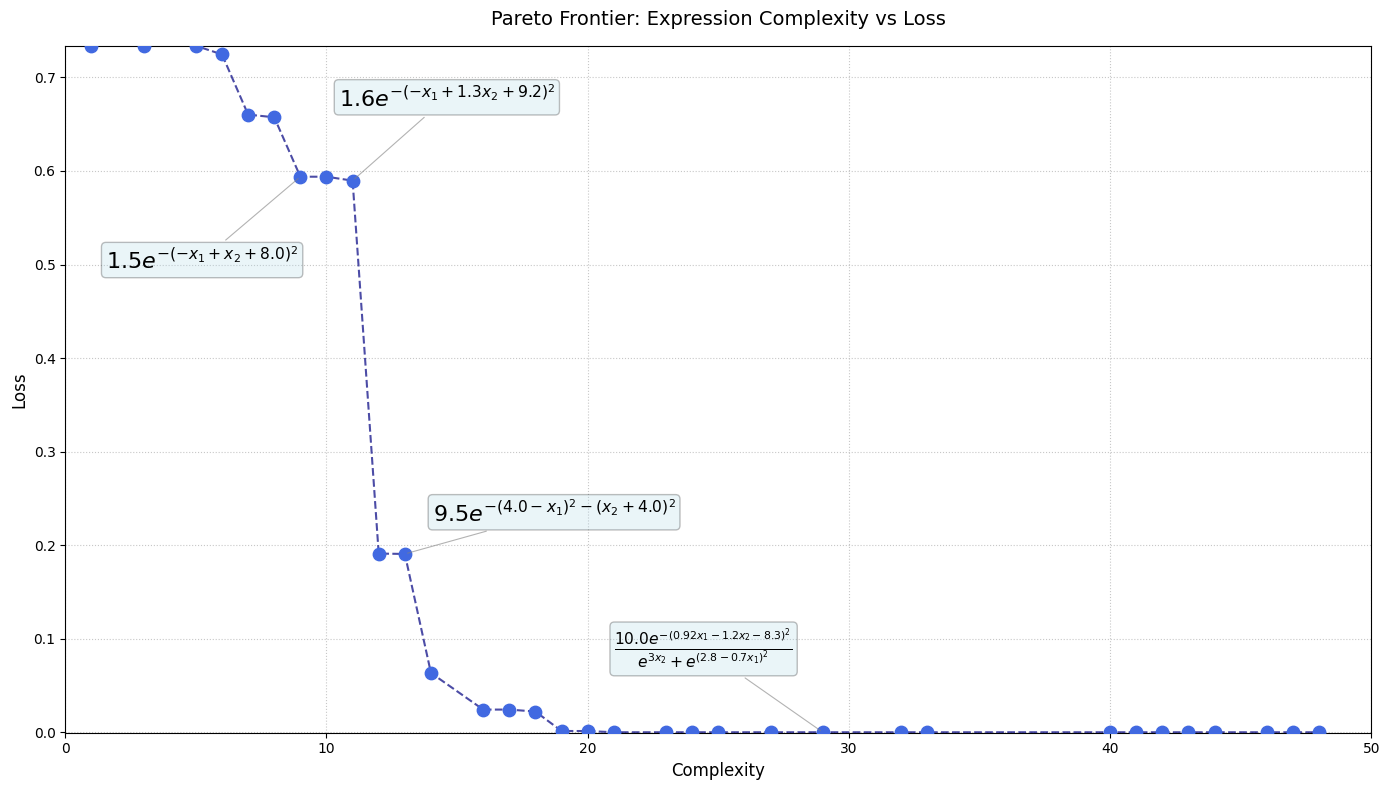

In [40]:
range_of_interest = (1, 48)
indices_of_interest = [i for i, c in enumerate(complexity) if range_of_interest[0] <= c <= range_of_interest[1]]
complexity = [complexity[i] for i in indices_of_interest]
loss = [loss[i] for i in indices_of_interest]
raw_equations = [raw_equations[i] for i in indices_of_interest]

# 2) Sympy setup
x1, x2, x3, x4 = sp.symbols('x1 x2 x3 x4')

# 3) Custom function to round constants only (not function arguments)
def round_constants(expr, ndigits=1):
    """
    Round every bare Float in `expr` so that, when printed,
    it has exactly `ndigits` digits after the decimal point
    in scientific notation (i.e. nd+1 significant figures).
    """
    def _is_leaf_float(e):
        return e.is_Float and not e.args

    def _round_sci(e):
        f = float(e)
        # format with `ndigits` places after the decimal in the mantissa:
        sci_str = f"{f:.{ndigits}e}"
        return sp.Float(sci_str)

    return expr.replace(_is_leaf_float, _round_sci)

# 4) Function to convert pow2 to squared form without evaluation
def convert_pow2(expr):
    # Find all pow2 calls
    if expr.func.__name__ == 'pow2':
        return sp.Pow(convert_pow2(expr.args[0]), 2, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow2(arg) for arg in expr.args]) if expr.args else expr

def convert_pow3(expr):
    # Find all pow3 calls
    if expr.func.__name__ == 'pow3':
        return sp.Pow(convert_pow3(expr.args[0]), 3, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow3(arg) for arg in expr.args]) if expr.args else expr

def convert_pow4(expr):
    # Find all pow4 calls
    if expr.func.__name__ == 'pow4':
        return sp.Pow(convert_pow4(expr.args[0]), 4, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow4(arg) for arg in expr.args]) if expr.args else expr

def convert_pow5(expr):
    # Find all pow5 calls
    if expr.func.__name__ == 'pow5':
        return sp.Pow(convert_pow5(expr.args[0]), 5, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow5(arg) for arg in expr.args]) if expr.args else expr

# 4) Function to convert pow_int without evaluation
def convert_pow_int(expr):
    # Find all pow_int calls
    if expr.func.__name__ == 'pow_int':
        base, exp = expr.args
        # If exp is literally an integer, convert to a Python int
        if exp.is_integer and exp.is_number:
            exp = int(exp)
        # Otherwise leave exp symbolic
        return sp.Pow(convert_pow_int(base), convert_pow_int(exp), evaluate=False)

    # Recursively descend into all other function applications
    if expr.args:
        return expr.func(*[convert_pow_int(arg) for arg in expr.args])
    else:
        return expr
    
def replace_pow_functions_recursive(expr: sp.Expr) -> sp.Expr:
    """
    Recursively replaces custom functions like powN(x) with standard power notation x**N.
    E.g. pow3(x + pow2(y)) → (x + y**2)**3
    """
    # First, apply recursively to all arguments (bottom-up),
    # so that nested pow-functions inside arguments get replaced too.
    expr = expr.xreplace({})  # no-op; just ensures expr is a Basic (not strictly needed)

    # Define replacement function
    def _repl(f):
        # check it's a function call
        if not isinstance(f, sp.Function):
            return f

        name = f.func.__name__
        if not name.startswith("pow"):
            return f

        # parse N from “powN”
        try:
            N = int(name[len("pow"):])
        except ValueError:
            return f

        if len(f.args) != 1:
            # unexpected arity, leave unchanged
            return f

        base = f.args[0]
        # Recursively transform the base
        new_base = replace_pow_functions_recursive(base)
        return new_base ** N

    # Use replace with map=False (so it returns an Expr)
    new_expr = expr.replace(
        lambda x: isinstance(x, sp.Function) and x.func.__name__.startswith("pow"),
        _repl,
        map=False
    )
    return new_expr

# 5) Build MathText labels
latex_labels = []
exprs_final = []
function_ready = []
for id, s in enumerate(raw_equations):
    try:
        # Pre-process pow2 -> custom function
        s_processed = s.replace('pow2', 'pow2_func')
        s_processed = s.replace('pow3', 'pow3_func')
        s_processed = s.replace('pow4', 'pow4_func')
        s_processed = s.replace('pow5', 'pow5_func')
        s_processed = s_processed.replace('pow_int', 'pow_int_func')
        
        # Define custom functions
        locals_dict = {
            'x1': x1,
            'x2': x2,
            'x3': x3,
            'x4': x4,
            'pow2_func': sp.Function('pow2'),
            'pow3_func': sp.Function('pow3'),
            'pow4_func': sp.Function('pow4'),
            'pow5_func': sp.Function('pow5'),
            'pow_int_func': sp.Function('pow_int'),
            'asin': sp.asin,
            'atan': sp.atan,
            'tan': sp.tan,
            'exp': sp.exp,
        }
        
        # Parse while preserving structure
        expr = parse_expr(s_processed, evaluate=False, local_dict=locals_dict)
        
        # Convert pow2_func to squared form
        expr_converted_pow2 = convert_pow2(expr)
        expr_converted_pow3 = convert_pow3(expr)
        expr_converted_pow4 = convert_pow4(expr)
        expr_converted_pow5 = convert_pow5(expr)
        expr_converted = convert_pow_int(expr_converted_pow5)
        
        # Round constants (only standalone floats)
        expr_converted_int1 = round_constants(expr_converted)
        expr_converted_int2 = round_constants(expr_converted_int1)
        expr_final = round_constants(expr_converted_int2)
        # expr_final = expr_final.simplify()
        # expr_final = expr_final.expand()
        exprs_final.append(expr_final)

        # Get MathText-friendly LaTeX
        mt = replace_pow_functions_recursive(expr_final)
        expr_converted_int1 = round_constants(mt)
        expr_converted_int2 = round_constants(expr_converted_int1)
        mt = round_constants(expr_converted_int2)
        mt = sp.latex(mt)
        latex_labels.append(f"${mt}$")
        
        # Replace 'exp' with 'np.exp'
        modified_expression = s.replace('exp', 'np.exp')
    
        # Replace 'log' with 'np.log'
        modified_expression = modified_expression.replace('log', 'np.log')
        function_ready.append(modified_expression)
        # Debug print
        print(f"Original at complexity {complexity[id]}: {s}")
        print(f"function_ready: {modified_expression}")
        print(f"Processed: {expr_final}")
        print(f"LaTeX: {mt}\n")
    except Exception as e:
        print(f"Error processing expression: {s}\n{e}")
        latex_labels.append(f"Error: {s}")

# 6) Manual offsets for clarity
offsets = [
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (-140, -60), (0, 0), (-10, 60), (0, 0),
    (20, 30), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (-150, 60), (0, 0), (0, 0),
]

# 7) Plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(complexity, loss, s=80, zorder=3, color='royalblue')
ax.plot(complexity, loss, linestyle='--', alpha=0.7, zorder=2, color='navy')

# Set axis limits
ax.set_xlim(min(complexity) - 1, max(complexity) + 2)
ax.set_ylim(min(loss) - 0.0005, max(loss))
fig.subplots_adjust(right=0.75)


skip_indices = []
keep_indices = [7-1, 9-1, 11-1, 23-1]
# Annotate with MathText labels
for i, (x, y, lbl, (dx, dy)) in enumerate(zip(complexity, loss, latex_labels, offsets)):
    if i in skip_indices or (i not in keep_indices):
        continue
    ax.annotate(
        lbl,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords='offset points',
        ha='left',
        va='center',
        fontsize=16,
        bbox=dict(boxstyle='round,pad=0.2', alpha=0.25, fc='lightblue'),
        arrowprops=dict(arrowstyle='-', lw=0.8, alpha=0.6, color='gray')
    )

ax.set_title("Pareto Frontier: Expression Complexity vs Loss", fontsize=14, pad=15)
ax.set_xlabel("Complexity", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

In [41]:
predicted_functions_i12 = [eval(f'lambda x1, x2: {str_func}', {'np':np, 'pow2':pow2, 'pow3':pow3, 'pow4':pow4, 'pow5':pow5}) for str_func in function_ready]

In [42]:
file_path = "data/pareto_results/gaussian_independent_set34_results.py"
exec(open(file_path).read())
raw_eqations_i34 = raw_equations
complexity_i34 = complexity
loss_i34 = loss

Original at complexity 1: 0.14949972761148317
function_ready: 0.14949972761148317
Processed: 0.150000000000000
LaTeX: 0.15

Original at complexity 2: pow2(0.38658105430966067)
function_ready: pow2(0.38658105430966067)
Processed: pow2(0.39)
LaTeX: 0.15

Original at complexity 4: 1.4496729709032465 * pow2(-0.32108719259507734)
function_ready: 1.4496729709032465 * pow2(-0.32108719259507734)
Processed: 1.4*pow2(-0.32)
LaTeX: 0.14

Original at complexity 6: 0.10294338957629132 / (exp(x1) + 0.4913456773732799)
function_ready: 0.10294338957629132 / (np.exp(x1) + 0.4913456773732799)
Processed: 0.1/(exp(x1) + 0.49)
LaTeX: \frac{0.1}{e^{x_{1}} + 0.49}

Original at complexity 7: exp(-0.5183636233331322 * pow2(3.9814098105294495 - x2))
function_ready: np.exp(-0.5183636233331322 * pow2(3.9814098105294495 - x2))
Processed: exp(-0.52*pow2(4.0 - x2))
LaTeX: e^{- 0.52 \left(4.0 - x_{2}\right)^{2}}

Original at complexity 8: pow3(exp(pow2(x2 - 3.996263733304581) * -0.17901756892642082))
function_ready: 

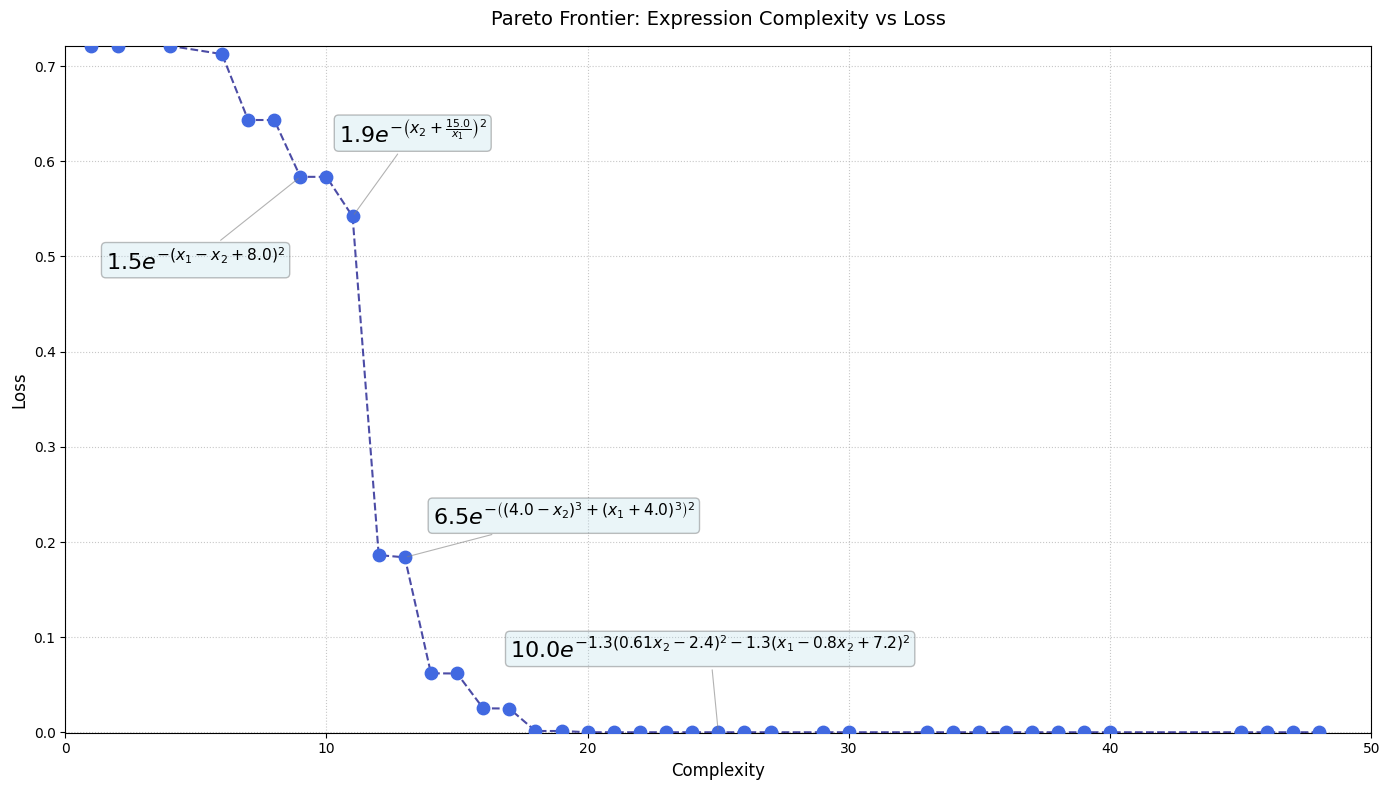

In [43]:
range_of_interest = (1, 48)
indices_of_interest = [i for i, c in enumerate(complexity) if range_of_interest[0] <= c <= range_of_interest[1]]
complexity = [complexity[i] for i in indices_of_interest]
loss = [loss[i] for i in indices_of_interest]
raw_equations = [raw_equations[i] for i in indices_of_interest]

# 2) Sympy setup
x1, x2, x3, x4 = sp.symbols('x1 x2 x3 x4')

# 3) Custom function to round constants only (not function arguments)
def round_constants(expr, ndigits=1):
    """
    Round every bare Float in `expr` so that, when printed,
    it has exactly `ndigits` digits after the decimal point
    in scientific notation (i.e. nd+1 significant figures).
    """
    def _is_leaf_float(e):
        return e.is_Float and not e.args

    def _round_sci(e):
        f = float(e)
        # format with `ndigits` places after the decimal in the mantissa:
        sci_str = f"{f:.{ndigits}e}"
        return sp.Float(sci_str)

    return expr.replace(_is_leaf_float, _round_sci)

# 4) Function to convert pow2 to squared form without evaluation
def convert_pow2(expr):
    # Find all pow2 calls
    if expr.func.__name__ == 'pow2':
        return sp.Pow(convert_pow2(expr.args[0]), 2, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow2(arg) for arg in expr.args]) if expr.args else expr

def convert_pow3(expr):
    # Find all pow3 calls
    if expr.func.__name__ == 'pow3':
        return sp.Pow(convert_pow3(expr.args[0]), 3, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow3(arg) for arg in expr.args]) if expr.args else expr

def convert_pow4(expr):
    # Find all pow4 calls
    if expr.func.__name__ == 'pow4':
        return sp.Pow(convert_pow4(expr.args[0]), 4, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow4(arg) for arg in expr.args]) if expr.args else expr

def convert_pow5(expr):
    # Find all pow5 calls
    if expr.func.__name__ == 'pow5':
        return sp.Pow(convert_pow5(expr.args[0]), 5, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow5(arg) for arg in expr.args]) if expr.args else expr

# 4) Function to convert pow_int without evaluation
def convert_pow_int(expr):
    # Find all pow_int calls
    if expr.func.__name__ == 'pow_int':
        base, exp = expr.args
        # If exp is literally an integer, convert to a Python int
        if exp.is_integer and exp.is_number:
            exp = int(exp)
        # Otherwise leave exp symbolic
        return sp.Pow(convert_pow_int(base), convert_pow_int(exp), evaluate=False)

    # Recursively descend into all other function applications
    if expr.args:
        return expr.func(*[convert_pow_int(arg) for arg in expr.args])
    else:
        return expr
    
def replace_pow_functions_recursive(expr: sp.Expr) -> sp.Expr:
    """
    Recursively replaces custom functions like powN(x) with standard power notation x**N.
    E.g. pow3(x + pow2(y)) → (x + y**2)**3
    """
    # First, apply recursively to all arguments (bottom-up),
    # so that nested pow-functions inside arguments get replaced too.
    expr = expr.xreplace({})  # no-op; just ensures expr is a Basic (not strictly needed)

    # Define replacement function
    def _repl(f):
        # check it's a function call
        if not isinstance(f, sp.Function):
            return f

        name = f.func.__name__
        if not name.startswith("pow"):
            return f

        # parse N from “powN”
        try:
            N = int(name[len("pow"):])
        except ValueError:
            return f

        if len(f.args) != 1:
            # unexpected arity, leave unchanged
            return f

        base = f.args[0]
        # Recursively transform the base
        new_base = replace_pow_functions_recursive(base)
        return new_base ** N

    # Use replace with map=False (so it returns an Expr)
    new_expr = expr.replace(
        lambda x: isinstance(x, sp.Function) and x.func.__name__.startswith("pow"),
        _repl,
        map=False
    )
    return new_expr

# 5) Build MathText labels
latex_labels = []
exprs_final = []
function_ready = []
for id, s in enumerate(raw_equations):
    try:
        # Pre-process pow2 -> custom function
        s_processed = s.replace('pow2', 'pow2_func')
        s_processed = s.replace('pow3', 'pow3_func')
        s_processed = s.replace('pow4', 'pow4_func')
        s_processed = s.replace('pow5', 'pow5_func')
        s_processed = s_processed.replace('pow_int', 'pow_int_func')
        
        # Define custom functions
        locals_dict = {
            'x1': x1,
            'x2': x2,
            'x3': x3,
            'x4': x4,
            'pow2_func': sp.Function('pow2'),
            'pow3_func': sp.Function('pow3'),
            'pow4_func': sp.Function('pow4'),
            'pow5_func': sp.Function('pow5'),
            'pow_int_func': sp.Function('pow_int'),
            'asin': sp.asin,
            'atan': sp.atan,
            'tan': sp.tan,
            'exp': sp.exp,
        }
        
        # Parse while preserving structure
        expr = parse_expr(s_processed, evaluate=False, local_dict=locals_dict)
        
        # Convert pow2_func to squared form
        expr_converted_pow2 = convert_pow2(expr)
        expr_converted_pow3 = convert_pow3(expr)
        expr_converted_pow4 = convert_pow4(expr)
        expr_converted_pow5 = convert_pow5(expr)
        expr_converted = convert_pow_int(expr_converted_pow5)
        
        # Round constants (only standalone floats)
        expr_converted_int1 = round_constants(expr_converted)
        expr_converted_int2 = round_constants(expr_converted_int1)
        expr_final = round_constants(expr_converted_int2)
        # expr_final = expr_final.simplify()
        # expr_final = expr_final.expand()
        exprs_final.append(expr_final)

        # Get MathText-friendly LaTeX
        mt = replace_pow_functions_recursive(expr_final)
        expr_converted_int1 = round_constants(mt)
        expr_converted_int2 = round_constants(expr_converted_int1)
        mt = round_constants(expr_converted_int2)
        mt = sp.latex(mt)
        latex_labels.append(f"${mt}$")
        
        # Replace 'exp' with 'np.exp'
        modified_expression = s.replace('exp', 'np.exp')
    
        # Replace 'log' with 'np.log'
        modified_expression = modified_expression.replace('log', 'np.log')
        function_ready.append(modified_expression)
        # Debug print
        print(f"Original at complexity {complexity[id]}: {s}")
        print(f"function_ready: {modified_expression}")
        print(f"Processed: {expr_final}")
        print(f"LaTeX: {mt}\n")
    except Exception as e:
        print(f"Error processing expression: {s}\n{e}")
        latex_labels.append(f"Error: {s}")

# 6) Manual offsets for clarity
offsets = [
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (-140, -60), (0, 0), (-10, 60), (0, 0),
    (20, 30), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (-150, 60), (0, 0), (0, 0),
]

# 7) Plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(complexity, loss, s=80, zorder=3, color='royalblue')
ax.plot(complexity, loss, linestyle='--', alpha=0.7, zorder=2, color='navy')

# Set axis limits
ax.set_xlim(min(complexity) - 1, max(complexity) + 2)
ax.set_ylim(min(loss) - 0.0005, max(loss))
fig.subplots_adjust(right=0.75)


skip_indices = []
keep_indices = [7-1, 9-1, 11-1, 23-1]
# Annotate with MathText labels
for i, (x, y, lbl, (dx, dy)) in enumerate(zip(complexity, loss, latex_labels, offsets)):
    if i in skip_indices or (i not in keep_indices):
        continue
    ax.annotate(
        lbl,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords='offset points',
        ha='left',
        va='center',
        fontsize=16,
        bbox=dict(boxstyle='round,pad=0.2', alpha=0.25, fc='lightblue'),
        arrowprops=dict(arrowstyle='-', lw=0.8, alpha=0.6, color='gray')
    )

ax.set_title("Pareto Frontier: Expression Complexity vs Loss", fontsize=14, pad=15)
ax.set_xlabel("Complexity", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

In [44]:
predicted_functions_i34 = [eval(f'lambda x1, x2: {str_func}', {'np':np, 'pow2':pow2, 'pow3':pow3, 'pow4':pow4, 'pow5':pow5}) for str_func in function_ready]

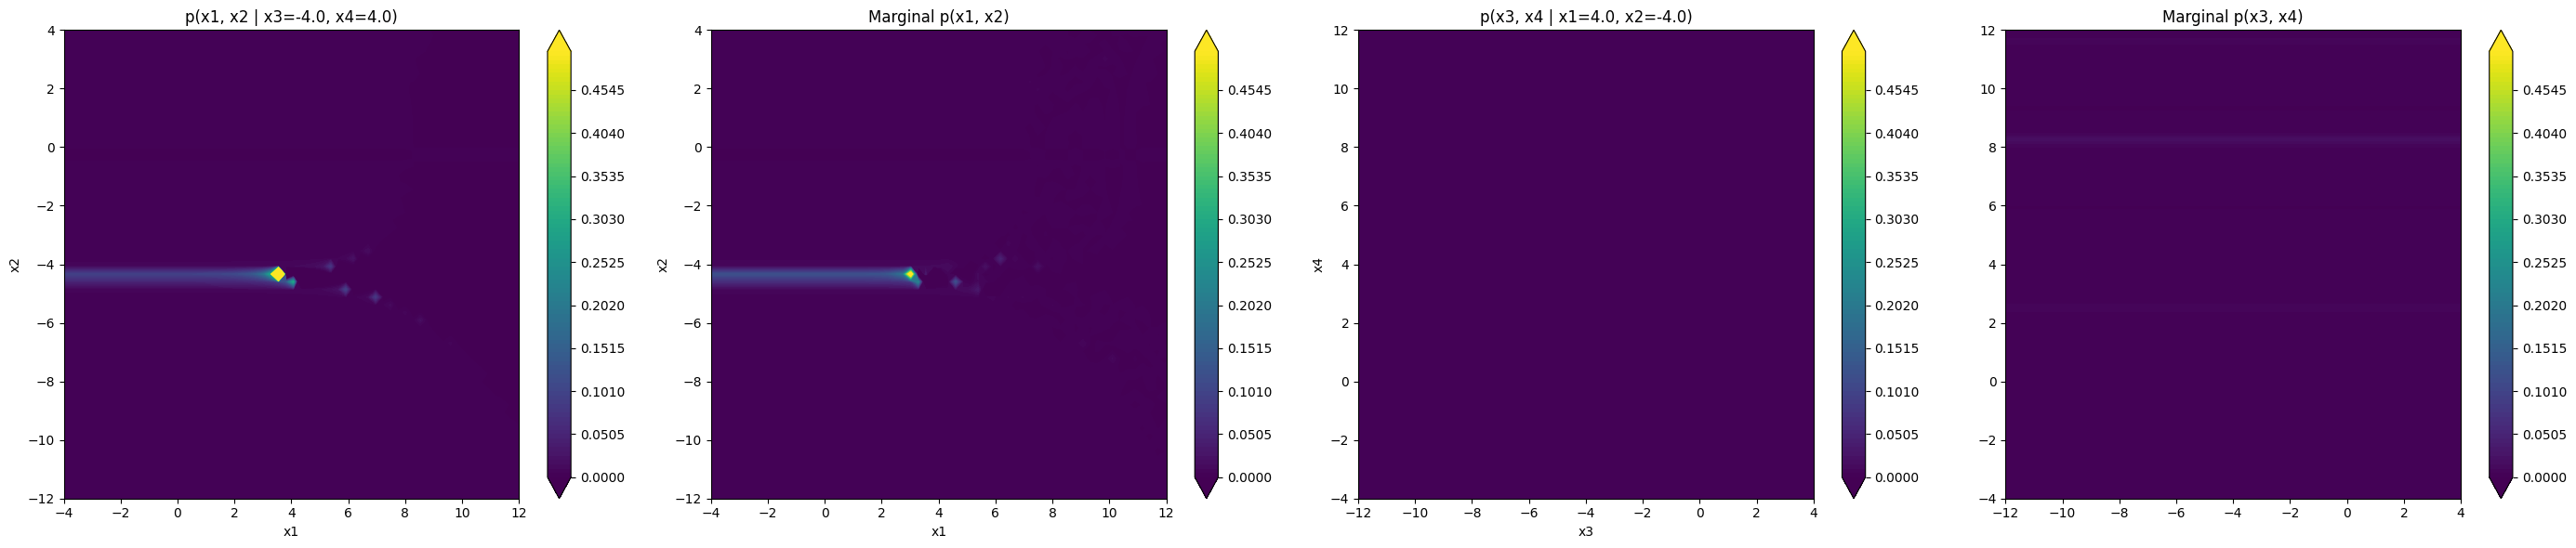

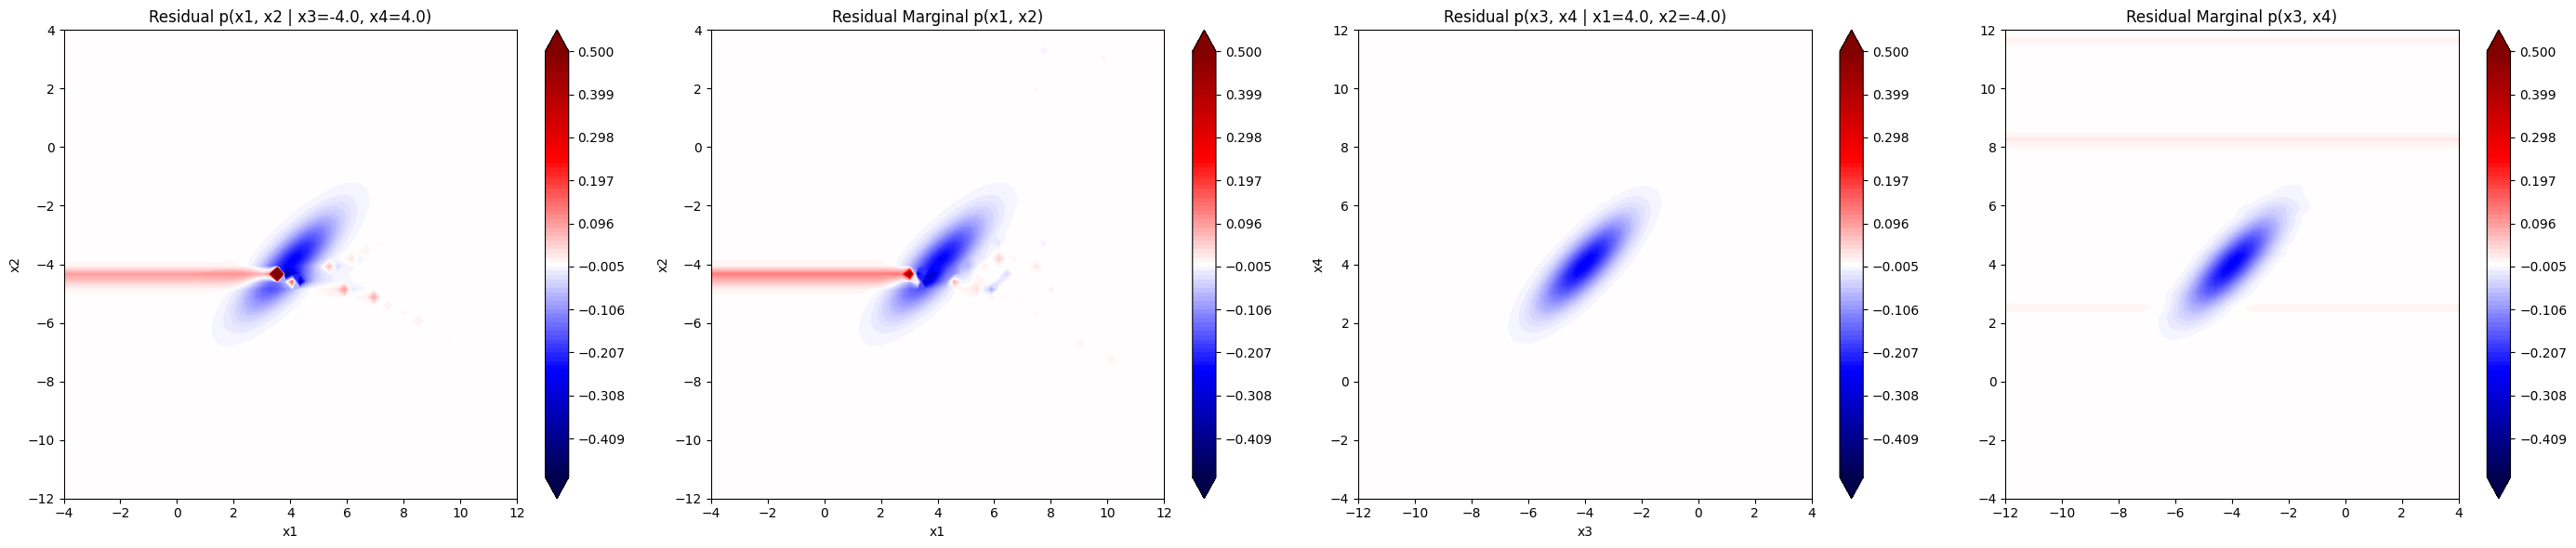

Complexity 27: Likelihood score: nan
complexity 27 :: min predict conditional 12: -0.32978102810072923, max predict conditional 12: 3.0397711165309214
complexity 27 :: min predict marginal 12: -0.15758866270653904, max predict marginal 12: 0.6303091401317128
complexity 27 :: min predict conditional 34: 0.0008890606045844066, max predict conditional 34: 0.002831146131762474
complexity 27 :: min predict marginal 34: -0.0016899072683641907, max predict marginal 34: 0.017732244071266525
max conditional p(x1,x2|x3=-4,x4=4) residual = 2.800852573153043
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.002831146131762474
max marginal p(x1,x2) residual = 2.800852573153043
max marginal p(x3,x4) residual = 0.002831146131762474



/tmp/ipykernel_2424218/553027239.py:115: RuntimeWarning: invalid value encountered in log
  likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))


In [45]:
func_predicted_density = predicted_functions[-1](grid_coordinates[:,0], grid_coordinates[:,1], grid_coordinates[:,2], grid_coordinates[:,3])/density_scale_factor
if func_predicted_density.size==1:
    func_predicted_density = func_predicted_density*np.ones(grid_coordinates[:,0].shape)
func_predicted_density = func_predicted_density.reshape(grids[0].shape)

func_total_mass = np.trapezoid(
    np.trapezoid(
      np.trapezoid(
        np.trapezoid(func_predicted_density, x=grid_axes[3], axis=3),
      x=grid_axes[2], axis=2),
    x=grid_axes[1], axis=1),
  x=grid_axes[0], axis=0)

X1, X2, func12_joint_density_on_slice, func12_conditional_density, func12_marginal_for_slice, func12_marginal_density = conditional_and_marginal_generation(
    joint_density=func_predicted_density,
    grids=grids,
    conditioning_xa_target=-4.0,
    conditioning_xb_target=4.0,
    ab_idx = (3,4),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
    total_mass = func_total_mass
)

X3, X4, func34_joint_density_on_slice, func34_conditional_density, func34_marginal_for_slice, func34_marginal_density = conditional_and_marginal_generation(
    joint_density=func_predicted_density,
    grids=grids,
    conditioning_xa_target=4.0,
    conditioning_xb_target=-4.0,
    ab_idx = (1,2),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
)
  
    # Get the title for the current function
title = latex_labels[i]

fig, axs = plt.subplots(1, 4, figsize=(28, 6))

cf00 = axs[0].contourf(X1, X2, func12_conditional_density, levels=levels_results, cmap="viridis", extend="both")
fig.colorbar(cf00, ax=axs[0])
axs[0].set_title("p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0].set_xlim([-4, 12])
axs[0].set_ylim([-12, 4])
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")

cf01 = axs[1].contourf(X1, X2, func12_marginal_density, levels=levels_results, cmap="viridis", extend="both")
fig.colorbar(cf01, ax=axs[1])
axs[1].set_title("Marginal p(x1, x2)")
axs[1].set_xlim([-4, 12])
axs[1].set_ylim([-12, 4])
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")

cf10 = axs[2].contourf(X3, X4, func34_conditional_density, levels=levels_results, cmap="viridis", extend="both")
fig.colorbar(cf10, ax=axs[2])
axs[2].set_title("p(x3, x4 | x1=4.0, x2=-4.0)")
axs[2].set_xlim([-12, 4])
axs[2].set_ylim([-4, 12])
axs[2].set_xlabel("x3")
axs[2].set_ylabel("x4")

cf11 = axs[3].contourf(X3, X4, func34_marginal_density, levels=levels_results, cmap="viridis", extend="both")
fig.colorbar(cf11, ax=axs[3])
axs[3].set_title("Marginal p(x3, x4)")
axs[3].set_xlim([-12, 4])
axs[3].set_ylim([-4, 12])
axs[2].set_xlabel("x3")
axs[2].set_ylabel("x4")
plt.tight_layout()
plt.show()
plt.close(fig) 
gc.collect()
fig, axs = plt.subplots(1, 4, figsize=(28, 6))

cf00 = axs[0].contourf(X1, X2, func12_conditional_density - ground_truth_cluster_1(X1, X2), levels=levels_results_residuals, cmap="seismic", extend="both")
fig.colorbar(cf00, ax=axs[0])
axs[0].set_title("Residual p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0].set_xlim([-4, 12])
axs[0].set_ylim([-12, 4])
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")

cf01 = axs[1].contourf(X1, X2, func12_marginal_density - ground_truth_cluster_1(X1, X2), levels=levels_results_residuals, cmap="seismic", extend="both")
fig.colorbar(cf01, ax=axs[1])
axs[1].set_title("Residual Marginal p(x1, x2)")
axs[1].set_xlim([-4, 12])
axs[1].set_ylim([-12, 4])
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")

cf10 = axs[2].contourf(X3, X4, func34_conditional_density - ground_truth_cluster_2(X3, X4), levels=levels_results_residuals, cmap="seismic", extend="both")
fig.colorbar(cf10, ax=axs[2])
axs[2].set_title("Residual p(x3, x4 | x1=4.0, x2=-4.0)")
axs[2].set_xlim([-12, 4])
axs[2].set_ylim([-4, 12])
axs[2].set_xlabel("x3")
axs[2].set_ylabel("x4")
cf11 = axs[3].contourf(X3, X4, func34_marginal_density - ground_truth_cluster_2(X3, X4), levels=levels_results_residuals, cmap="seismic", extend="both")
fig.colorbar(cf11, ax=axs[3])
axs[3].set_title("Residual Marginal p(x3, x4)")
axs[3].set_xlim([-12, 4])
axs[3].set_ylim([-4, 12])
axs[2].set_xlabel("x3")
axs[2].set_ylabel("x4")
plt.tight_layout()
plt.show()
plt.close(fig) 
gc.collect()
    
prediction_eval_at_samples = predicted_functions[-1](test_samples[:,0], test_samples[:,1], test_samples[:,2], test_samples[:,3])
likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))
print(f"Complexity {complexity[i]}: Likelihood score: {likelihood_score_of_prediction:,}")
print(f"complexity {complexity[i]} :: min predict conditional 12: {np.min(func12_conditional_density)}, max predict conditional 12: {np.max(func12_conditional_density)}")
print(f"complexity {complexity[i]} :: min predict marginal 12: {np.min(func12_marginal_density)}, max predict marginal 12: {np.max(func12_marginal_density)}")
print(f"complexity {complexity[i]} :: min predict conditional 34: {np.min(func34_conditional_density)}, max predict conditional 34: {np.max(func34_conditional_density)}")
print(f"complexity {complexity[i]} :: min predict marginal 34: {np.min(func34_marginal_density)}, max predict marginal 34: {np.max(func34_marginal_density)}")
print(f"max conditional p(x1,x2|x3=-4,x4=4) residual = {np.max(func12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"max conditional p(x3,x4|x1=4,x2=-4) residual = {np.max(func34_conditional_density - ground_truth_cluster_2(X3, X4))}")
print(f"max marginal p(x1,x2) residual = {np.max(func12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"max marginal p(x3,x4) residual = {np.max(func34_conditional_density - ground_truth_cluster_2(X3, X4))}\n")
   
del func_predicted_density

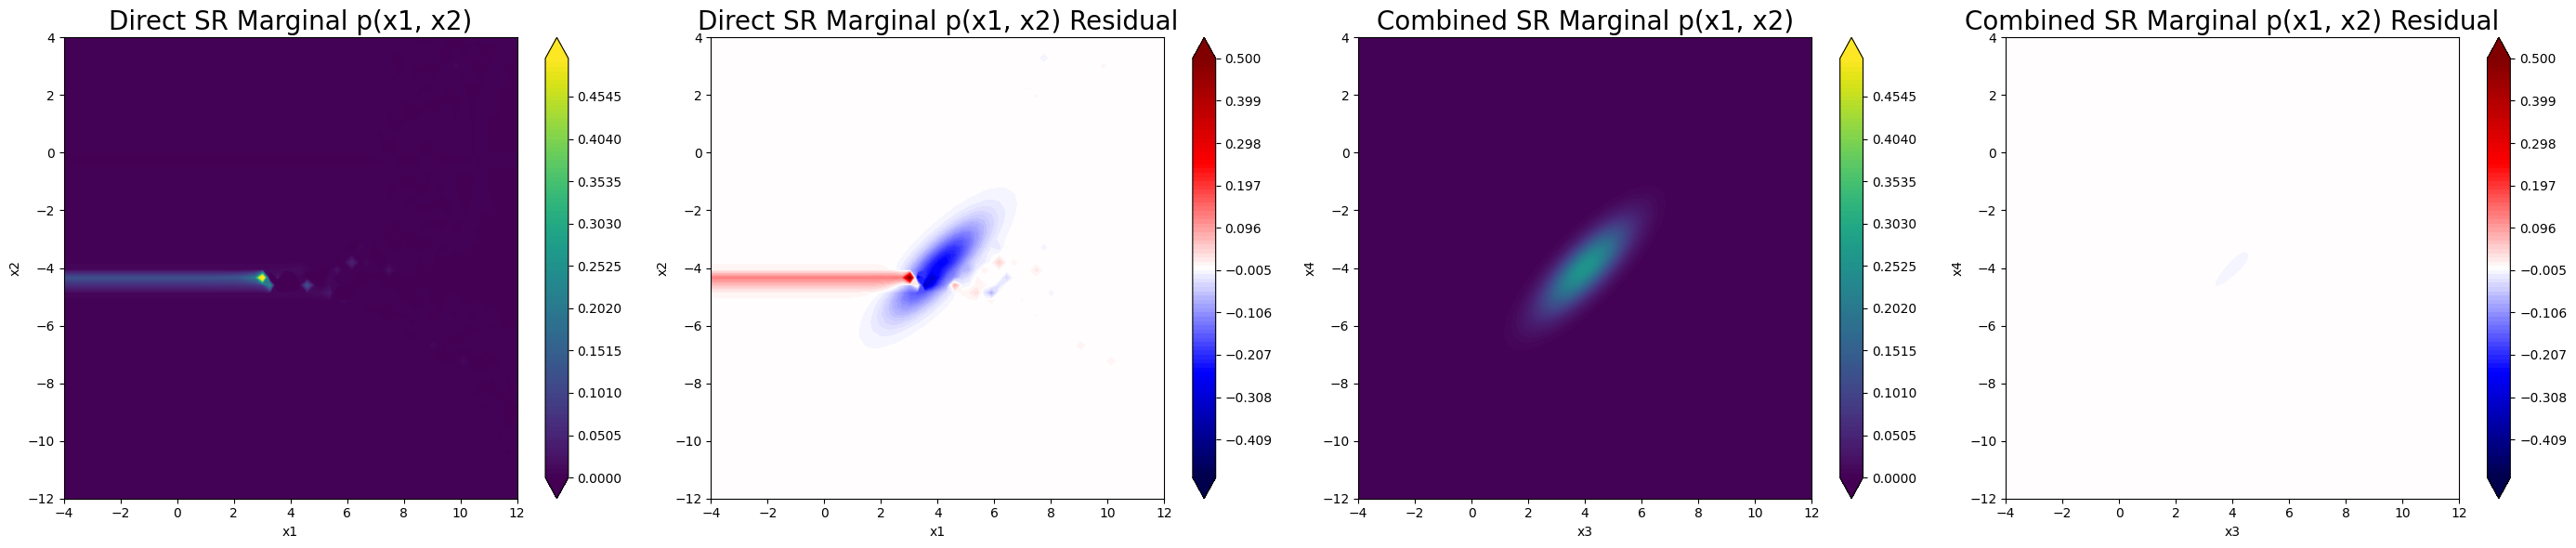

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_2424218/369941066.py:83: RuntimeWarning: invalid value encountered in log
  likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))


complexity 49 :: min predict conditional 12: 1.6432890632370752e-134, max predict conditional 12: 0.25794267679261035
complexity 49 :: min predict marginal 12: 1.6432890632370752e-134, max predict marginal 12: 0.25794267679261035
complexity 50 :: min predict conditional 34: 6.593662333202796e-135, max predict conditional 34: 0.258190461436206
complexity 50 :: min predict marginal 34: 6.593662333202796e-135, max predict marginal 34: 0.258190461436206
max conditional p(x1,x2|x3=-4,x4=4) residual = 0.002378175472876304
max conditional p(x3,x4|x1=4,x2=-4) residual = 0.0033717701770791114
max marginal p(x1,x2) residual = 0.002378175472876304
max marginal p(x3,x4) residual = 0.0033717701770791114



In [53]:
from config_management.data_config_4d_gaussian_independent12 import DataConfig as dc_12
from config_management.data_config_4d_gaussian_independent34 import DataConfig as dc_34


if DataConfig.slices is None:
    xmin, xmax = x1.min()-dc_12.grid_tolerance, x1.max()+dc_12.grid_tolerance
    ymin, ymax = x2.min()-dc_12.grid_tolerance, x2.max()+dc_12.grid_tolerance
    grids_12 = np.mgrid[xmin:xmax:dc_12.jxbins, ymin:ymax:dc_12.jxbins]
else:
    slices_12 = dc_12.slices
    grids_12 = np.mgrid[tuple(slices_12)]

if dc_34.slices is None:
    xmin, xmax = x1.min()-dc_34.grid_tolerance, x1.max()+dc_34.grid_tolerance
    ymin, ymax = x2.min()-dc_34.grid_tolerance, x2.max()+dc_34.grid_tolerance
    grids_34 = np.mgrid[xmin:xmax:dc_34.jxbins, ymin:ymax:dc_34.jxbins]
else:
    slices_34 = dc_34.slices
    grids_34 = np.mgrid[tuple(slices_34)]

grid_coordinates_12 = np.vstack([grids_12[0].ravel(), grids_12[1].ravel()])
grid_coordinates_12 = grid_coordinates_12.T

grid_coordinates_34 = np.vstack([grids_34[0].ravel(), grids_34[1].ravel()])
grid_coordinates_34 = grid_coordinates_34.T



func_predicted_density_i12 = predicted_functions_i12[-1](grid_coordinates_12[:,0], grid_coordinates_12[:,1])/density_scale_factor_i12
func_predicted_density_i34 = predicted_functions_i34[-1](grid_coordinates_34[:,0], grid_coordinates_34[:,1])/density_scale_factor_i34

func_predicted_density_i12 = func_predicted_density_i12.reshape(grids_12[0].shape)
func_predicted_density_i34 = func_predicted_density_i34.reshape(grids_34[0].shape)

# Get the title for the current function
title = latex_labels[i]

fig, axs = plt.subplots(1, 4, figsize=(28, 6))

cf00 = axs[0].contourf(X1, X2, func12_marginal_density, levels=levels_results, cmap="viridis", extend="both")
fig.colorbar(cf00, ax=axs[0])
axs[0].set_title("Direct SR Marginal p(x1, x2)", fontsize=20)
axs[0].set_xlim([-4, 12])
axs[0].set_ylim([-12, 4])
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")

cf01 = axs[1].contourf(X1, X2, func12_marginal_density - ground_truth_cluster_1(X1, X2), levels=levels_results_residuals, cmap="seismic", extend="both")
fig.colorbar(cf01, ax=axs[1])
axs[1].set_title("Direct SR Marginal p(x1, x2) Residual", fontsize=20)
axs[1].set_xlim([-4, 12])
axs[1].set_ylim([-12, 4])
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")

cf10 = axs[2].contourf(grids_12[0], grids_12[1], func_predicted_density_i12, levels=levels_results, cmap="viridis", extend="both")
fig.colorbar(cf10, ax=axs[2])
axs[2].set_title("Combined SR Marginal p(x1, x2)", fontsize=20)
axs[2].set_xlim([-4, 12])
axs[2].set_ylim([-12, 4])
axs[2].set_xlabel("x3")
axs[2].set_ylabel("x4")
plt.tight_layout()

cf11 = axs[3].contourf(grids_12[0], grids_12[1], func_predicted_density_i12 - ground_truth_cluster_1(grids_12[0], grids_12[1]), levels=levels_results_residuals, cmap="seismic", extend="both")
fig.colorbar(cf11, ax=axs[3])
axs[3].set_title("Combined SR Marginal p(x1, x2) Residual", fontsize=20)
axs[3].set_xlim([-4, 12])
axs[3].set_ylim([-12, 4])
axs[3].set_xlabel("x3")
axs[3].set_ylabel("x4")

plt.show()
plt.close(fig) 
gc.collect()

plt.tight_layout()
plt.show()
plt.close(fig) 
gc.collect()

prediction_eval_at_samples = predicted_functions[-1](test_samples[:,0], test_samples[:,1], test_samples[:,2], test_samples[:,3])
likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))

print(f"complexity {complexity_i12[-1]} :: min predict conditional 12: {np.min(func_predicted_density_i12)}, max predict conditional 12: {np.max(func_predicted_density_i12)}")
print(f"complexity {complexity_i12[-1]} :: min predict marginal 12: {np.min(func_predicted_density_i12)}, max predict marginal 12: {np.max(func_predicted_density_i12)}")
print(f"complexity {complexity_i34[-1]} :: min predict conditional 34: {np.min(func_predicted_density_i34)}, max predict conditional 34: {np.max(func_predicted_density_i34)}")
print(f"complexity {complexity_i34[-1]} :: min predict marginal 34: {np.min(func_predicted_density_i34)}, max predict marginal 34: {np.max(func_predicted_density_i34)}")
print(f"max conditional p(x1,x2|x3=-4,x4=4) residual = {np.max(func_predicted_density_i12 - ground_truth_cluster_1(grids_12[0], grids_12[1]))}")
print(f"max conditional p(x3,x4|x1=4,x2=-4) residual = {np.max(func_predicted_density_i34 - ground_truth_cluster_2(grids_34[0], grids_34[1]))}")
print(f"max marginal p(x1,x2) residual = {np.max(func_predicted_density_i12 - ground_truth_cluster_1(grids_12[0], grids_12[1]))}")
print(f"max marginal p(x3,x4) residual = {np.max(func_predicted_density_i34 - ground_truth_cluster_2(grids_34[0], grids_34[1]))}\n")
